# Cell 1 — Install core dependencies (OpenAI + HF stack)

In [1]:
# ============================================================
# Cell 1 — Install core dependencies
# ------------------------------------------------------------
# • Installs the OpenAI Python SDK (Responses API / GPT‑5.1)
# • Installs Hugging Face tooling and PyTorch add‑ons:
#     - transformers / accelerate / huggingface_hub
#     - bitsandbytes for optional 4‑bit loading
# • Installs common scientific stack for analysis/plots
# ============================================================

!pip -q install \
    openai \
    "transformers>=4.37.0" \
    accelerate \
    bitsandbytes \
    huggingface_hub \
    einops \
    numpy \
    matplotlib \
    tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 19.1 MB/s eta 0:00:00


# Cell 2 — Imports, environment introspection, and global RNG seeding

In [2]:
# ============================================================
# Cell 2 — Imports, environment checks, and global RNG seed
# ------------------------------------------------------------
# • Imports core libraries (torch, transformers, OpenAI client, etc.)
# • Prints Python / library versions and GPU status
# • Defines and applies a reproducible random seed
# ============================================================

import os
import sys
import platform
import random
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple

import numpy as np
import torch
from tqdm.auto import tqdm

from openai import OpenAI
from huggingface_hub import login as hf_login

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

# --- Version / environment introspection ---
print(f"Python version      : {sys.version.split()[0]}")
print(f"Platform            : {platform.platform()}")

print(f"PyTorch version     : {torch.__version__}")
print(f"CUDA available      : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device         : {torch.cuda.get_device_name(0)}")

# --- Global seed helper ---
def set_global_seed(seed: int = 1234) -> None:
    """
    Set RNG seeds for Python, NumPy, and PyTorch to improve reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

GLOBAL_SEED = 1234
set_global_seed(GLOBAL_SEED)
print(f"Global seed set to  : {GLOBAL_SEED}")

# --- Default device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Primary device      : {DEVICE}")


Python version      : 3.12.12
Platform            : Linux-6.6.105+-x86_64-with-glibc2.35
PyTorch version     : 2.9.0+cu126
CUDA available      : True
CUDA device         : Tesla T4
Global seed set to  : 1234
Primary device      : cuda


# Cell 3 — Mount Google Drive

In [3]:
# ============================================================
# Cell 3 — Mount Drive and create project directory
# ------------------------------------------------------------
# • Mounts Google Drive in Colab
# • Resolves the "MyDrive" root (supports both 'MyDrive' and 'My Drive')
# • Creates (if needed) the directory: 1 - RESEARCH / Pivotal
# • Exposes PROJECT_DIR for all subsequent cells
# ============================================================

from google.colab import drive  # type: ignore

drive.mount("/content/drive", force_remount=False)

DRIVE_ROOT = Path("/content/drive")

def resolve_my_drive(root: Path) -> Path:
    """
    Find the user's MyDrive folder under the mounted Google Drive.

    Supports both:
      • /content/drive/MyDrive
      • /content/drive/My Drive
    """
    candidates = ["MyDrive", "My Drive"]
    for name in candidates:
        candidate = root / name
        if candidate.exists():
            print(f"Using Google Drive base: {candidate}")
            return candidate
    raise FileNotFoundError(
        "Could not locate 'MyDrive' or 'My Drive' in the mounted Google Drive. "
        "Check that drive.mount(...) succeeded."
    )

MY_DRIVE = resolve_my_drive(DRIVE_ROOT)

# Target project directory: "1 - RESEARCH / Pivotal"
PROJECT_ROOT_FOLDER = "1 - RESEARCH"
PROJECT_SUBFOLDER = "Pivotal"

PROJECT_DIR = MY_DRIVE / PROJECT_ROOT_FOLDER / PROJECT_SUBFOLDER
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project directory created / found:\n  {PROJECT_DIR}")


Mounted at /content/drive
Using Google Drive base: /content/drive/MyDrive
Project directory created / found:
  /content/drive/MyDrive/1 - RESEARCH/Pivotal


# Cell 4 — Central configuration dataclass

In [4]:
# ============================================================
# Cell 4 — Configuration dataclass (paths, models, hyperparams)
# ------------------------------------------------------------
# • Collects all tunable parameters in one place:
#     - Project paths
#     - OpenAI / GPT‑5.1 settings
#     - HF model candidates and quantization settings
# • Instantiate CFG once and reference elsewhere to avoid magic numbers
# ============================================================

@dataclass
class ProjectConfig:
    # Paths
    project_dir: Path = PROJECT_DIR

    # OpenAI (GPT‑5.1) configuration
    openai_model: str = "gpt-5.1"
    openai_reasoning_effort: str = "medium"   # "none" | "low" | "medium" | "high"
    openai_text_verbosity: str = "medium"     # "low" | "medium" | "high"
    openai_max_output_tokens: int = 2048
    openai_store_state: bool = False          # stateful Responses API if desired

    # Hugging Face LLM configuration (7B-ish open model)
    # Ordered preference: Qwen2 → DeepSeek → Llama‑2
    hf_model_candidates: List[str] = field(default_factory=lambda: [
        "Qwen/Qwen2-7B-Instruct",         # 7B chat model with long context :contentReference[oaicite:3]{index=3}
        "deepseek-ai/deepseek-llm-7b-chat",
        "meta-llama/Llama-2-7b-hf",
    ])

    hf_use_4bit: bool = True                # True = bitsandbytes 4‑bit, False = full precision
    hf_max_new_tokens: int = 256
    hf_temperature: float = 0.7
    hf_top_p: float = 0.9

    # Reproducibility / misc
    seed: int = GLOBAL_SEED


CFG = ProjectConfig()
print(CFG)


ProjectConfig(project_dir=PosixPath('/content/drive/MyDrive/1 - RESEARCH/Pivotal'), openai_model='gpt-5.1', openai_reasoning_effort='medium', openai_text_verbosity='medium', openai_max_output_tokens=2048, openai_store_state=False, hf_model_candidates=['Qwen/Qwen2-7B-Instruct', 'deepseek-ai/deepseek-llm-7b-chat', 'meta-llama/Llama-2-7b-hf'], hf_use_4bit=True, hf_max_new_tokens=256, hf_temperature=0.7, hf_top_p=0.9, seed=1234)


# Cell 5 — Load Colab secrets

In [5]:
# ============================================================
# Cell 5 — Load Colab secrets and authenticate APIs
# ------------------------------------------------------------
# • Reads OPENAI_API_KEY and HFTOKEN from Colab secrets:
#     from google.colab import userdata
#     userdata.get("OPENAI_API_KEY")
#     userdata.get("HFTOKEN")
# • Sets environment variables to make CLI / libraries pick them up:
#     - OPENAI_API_KEY
#     - HF_TOKEN, HUGGINGFACEHUB_API_TOKEN
# • Instantiates:
#     - OpenAI client for GPT‑5.1 (Responses API)
#     - Hugging Face Hub auth for gated models if needed
# ============================================================

from google.colab import userdata  # type: ignore

# --- OpenAI key ---
openai_api_key: Optional[str] = userdata.get("OPENAI_API_KEY")
if not openai_api_key:
    raise RuntimeError(
        "OPENAI_API_KEY is not set in Colab secrets. "
        "Use 'Runtime → Secrets' to define it."
    )

os.environ["OPENAI_API_KEY"] = openai_api_key

# Instantiate OpenAI client (uses env var by default)
openai_client = OpenAI()  # or OpenAI(api_key=openai_api_key)
print("OpenAI client instantiated with Responses API support.")

# --- Hugging Face token ---
hf_token: Optional[str] = userdata.get("HFTOKEN")
if not hf_token:
    print(
        "Warning: HFTOKEN is not set in Colab secrets. "
        "Downloading gated HF models may fail. "
        "Set 'HFTOKEN' in Colab secrets for authenticated access."
    )
else:
    os.environ["HF_TOKEN"] = hf_token
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token
    # Programmatic login (respects HF_TOKEN env var precedence) :contentReference[oaicite:4]{index=4}
    hf_login(token=hf_token)
    print("Authenticated to Hugging Face Hub via HFTOKEN.")


OpenAI client instantiated with Responses API support.


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Authenticated to Hugging Face Hub via HFTOKEN.


# Cell 6 — Agentic Wrapper

In [6]:
# ============================================================
# Cell 6 — Agentic GPT-5.1 wrapper class (2025-stable, FIXED)
# ------------------------------------------------------------
# • Uses Responses API's output_text helper (recommended)
# • max_output_tokens is a top-level parameter
# • Streaming path uses response.output_text.delta events
# ============================================================

@dataclass
class AgentConfig:
    model: str = CFG.openai_model
    reasoning_effort: str = CFG.openai_reasoning_effort
    text_verbosity: str = CFG.openai_text_verbosity
    max_output_tokens: int = CFG.openai_max_output_tokens   # top-level
    store_state: bool = CFG.openai_store_state
    previous_response_id: Optional[str] = None              # conversation threading


DEFAULT_AGENT_SYSTEM_PROMPT = (
    "You are an expert in history, describe the history of Ancient Rome"
)


class AgenticGPT5:
    """
    Stable wrapper for GPT-5.1 via the OpenAI Responses API.

    Uses:
      • response.output_text for non-streaming calls
      • response.output_text.delta events for streaming
    """

    def __init__(self, client: OpenAI, config: Optional[AgentConfig] = None) -> None:
        self.client = client
        self.config = config or AgentConfig()
        self._last_response_id: Optional[str] = None

    # --------------------------------------------------------
    # Internal helper: extract visible text using output_text
    # --------------------------------------------------------
    def _extract_text(self, resp) -> str:
        """
        Use the SDK's output_text helper, which abstracts the
        nested output structure for plain-text use cases.
        """
        text = getattr(resp, "output_text", None)
        if text is None:
            raise RuntimeError(f"Response has no output_text field: {resp}")
        return text.strip()

    # --------------------------------------------------------
    # Main call method (non-streaming + streaming)
    # --------------------------------------------------------
    def run(
        self,
        user_prompt: str,
        system_prompt: str = DEFAULT_AGENT_SYSTEM_PROMPT,
        reasoning_effort: Optional[str] = None,
        text_verbosity: Optional[str] = None,
        max_output_tokens: Optional[int] = None,
        store_state: Optional[bool] = None,
        stream: bool = False,
    ) -> str:

        reasoning_effort = reasoning_effort or self.config.reasoning_effort
        text_verbosity = text_verbosity or self.config.text_verbosity
        max_output_tokens = max_output_tokens or self.config.max_output_tokens
        store_state = store_state if store_state is not None else self.config.store_state

        payload: Dict[str, Any] = {
            "model": self.config.model,
            "instructions": system_prompt,
            "input": user_prompt,
            "reasoning": {"effort": reasoning_effort},
            "text": {"verbosity": text_verbosity},
            "max_output_tokens": max_output_tokens,   # top-level, per GPT-5.1 docs
            "store": store_state,
        }

        if self.config.previous_response_id:
            payload["previous_response_id"] = self.config.previous_response_id

        # ---------------------------------------
        # NON-STREAMING (default)
        # ---------------------------------------
        if not stream:
            resp = self.client.responses.create(**payload)
            self._last_response_id = resp.id
            return self._extract_text(resp)

        # ---------------------------------------
        # STREAMING MODE
        # ---------------------------------------
        chunks: List[str] = []
        stream_iter = self.client.responses.create(stream=True, **payload)

        for event in stream_iter:
            # Python SDK exposes event.type and event.delta for text
            if getattr(event, "type", None) == "response.output_text.delta":
                chunks.append(event.delta)

        return "".join(chunks)

    @property
    def last_response_id(self) -> Optional[str]:
        return self._last_response_id


# Instantiate agent
gpt5_agent = AgenticGPT5(openai_client)
print("AgenticGPT5 instance is ready (2025-stable API, FIXED).")


# ============================================================
# Cell 7 — GPT-5.1 smoke test
# ------------------------------------------------------------
# • Confirms GPT-5.1 and the Responses API are functional
# • Performs a minimal round-trip with low reasoning + low verbosity
# ============================================================

test_prompt = (
    "In one paragraph, describe what this notebook skeleton is set up to do."
)

try:
    summary = gpt5_agent.run(
        user_prompt=test_prompt,
        reasoning_effort="low",
        text_verbosity="low",
        max_output_tokens=256,
    )
    print("GPT-5.1 test response:\n")
    print(summary)

except Exception as exc:
    print("GPT-5.1 test call failed:")
    print(repr(exc))


AgenticGPT5 instance is ready (2025-stable API, FIXED).
GPT-5.1 test response:

I don’t see the notebook skeleton in your message. Please paste the notebook (or a screenshot/text of its cells and headings), and I’ll describe in a single paragraph what it’s set up to do.


# Cell 7 — Minimal GPT (smoke test)

# Cell 8 — Helper Function (for HF models)

In [7]:
# ============================================================
# Cell 8 — Helper to load a ~7B HF causal LM (Qwen / DeepSeek / Llama)
# ------------------------------------------------------------
# • Tries model IDs from CFG.hf_model_candidates in order:
#     1. Qwen/Qwen2-7B-Instruct  (instruction-tuned, long context) :contentReference[oaicite:7]{index=7}
#     2. deepseek-ai/deepseek-llm-7b-chat
#     3. meta-llama/Llama-2-7b-hf
# • If CFG.hf_use_4bit is True, uses bitsandbytes 4‑bit quantization:
#     - QuantizationConfig(load_in_4bit=True, nf4, bfloat16 compute) :contentReference[oaicite:8]{index=8}
# • Returns (tokenizer, model, chosen_model_id)
# • Any failure to load all candidates raises a RuntimeError with last error.
# ============================================================

def load_open_source_causal_lm(
    model_ids: Sequence[str],
    use_4bit: bool = CFG.hf_use_4bit,
    token: Optional[str] = hf_token,
) -> Tuple[AutoTokenizer, AutoModelForCausalLM, str]:
    """
    Try to load a causal LM from a list of candidate HF model IDs.

    Parameters
    ----------
    model_ids:
        Ordered list of candidate Hugging Face model IDs.
    use_4bit:
        If True, attempts BitsAndBytes 4‑bit loading.
        If False, loads in standard (bfloat16/float16) precision.
    token:
        Optional HF API token for gated models.

    Returns
    -------
    tokenizer, model, chosen_model_id
    """
    last_error: Optional[BaseException] = None

    for mid in model_ids:
        print(f"\nTrying model: {mid}")
        try:
            # Tokenizer
            tok = AutoTokenizer.from_pretrained(
                mid,
                use_fast=True,
                token=token,
            )

            # Model kwargs
            model_kwargs: Dict[str, Any] = {
                "device_map": "auto",
                "token": token,
                "torch_dtype": "auto",
            }

            if use_4bit:
                # BitsAndBytes config for 4‑bit quantization
                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.bfloat16
                    if torch.cuda.is_available()
                    else torch.float32,
                    bnb_4bit_use_double_quant=False,
                )
                model_kwargs["quantization_config"] = bnb_config

            mdl = AutoModelForCausalLM.from_pretrained(mid, **model_kwargs)
            mdl.eval()

            print(f"✅ Successfully loaded HF model: {mid}")
            return tok, mdl, mid

        except Exception as exc:
            print(f"⚠️ Failed to load {mid}: {exc}")
            last_error = exc

    raise RuntimeError(
        f"Could not load any candidate model from: {model_ids}. "
        f"Last error: {last_error!r}"
    )


# Cell 9 — Load Open Source Model

In [8]:
# ============================================================
# Cell 9 — Load open-source 7B model and run a quick generation
# ------------------------------------------------------------
# • Calls load_open_source_causal_lm(...) with CFG.hf_model_candidates
# • Stores global references:
#     - HF_TOKENIZER, HF_MODEL, HF_MODEL_ID
# • Runs a short generation to confirm everything is wired up
# • Uses a simple chat-style prompt for instruct models
# ============================================================

HF_TOKENIZER, HF_MODEL, HF_MODEL_ID = load_open_source_causal_lm(
    CFG.hf_model_candidates,
    use_4bit=CFG.hf_use_4bit,
    token=hf_token,
)

print(f"Loaded open-source model:\n  {HF_MODEL_ID}")
print(f"Model on device(s)   : {HF_MODEL.device}")

def generate_with_open_model(
    user_text: str,
    system_text: str = "You are a helpful research assistant.",
    max_new_tokens: int = CFG.hf_max_new_tokens,
    temperature: float = CFG.hf_temperature,
    top_p: float = CFG.hf_top_p,
) -> str:
    """
    Convenience wrapper for one-shot generation with the open-source model.

    For chatty models like Qwen2-7B-Instruct, uses apply_chat_template
    if available; otherwise falls back to plain prompt concatenation.
    """
    HF_MODEL.to(DEVICE)

    if hasattr(HF_TOKENIZER, "apply_chat_template"):
        messages = [
            {"role": "system", "content": system_text},
            {"role": "user", "content": user_text},
        ]
        text = HF_TOKENIZER.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
        )
    else:
        text = system_text + "\n\nUser: " + user_text + "\nAssistant:"

    inputs = HF_TOKENIZER(
        [text],
        return_tensors="pt",
    ).to(DEVICE)

    with torch.no_grad():
        gen_ids = HF_MODEL.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
        )

    # Strip the prompt tokens from the generated sequence
    gen_only_ids = [
        out_ids[len(in_ids):]
        for in_ids, out_ids in zip(inputs["input_ids"], gen_ids)
    ]
    out_text = HF_TOKENIZER.batch_decode(
        gen_only_ids,
        skip_special_tokens=True,
    )[0]
    return out_text.strip()


# Quick smoke test for the HF model
try:
    demo_answer = generate_with_open_model(
        "Briefly explain what mechanistic interpretability is.",
        system_text="You are a technical but concise ML researcher.",
        max_new_tokens=128,
    )
    print("Open-source model test output:\n")
    print(demo_answer)
except Exception as exc:
    print("HF model generation test failed:")
    print(repr(exc))



Trying model: Qwen/Qwen2-7B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

✅ Successfully loaded HF model: Qwen/Qwen2-7B-Instruct
Loaded open-source model:
  Qwen/Qwen2-7B-Instruct
Model on device(s)   : cuda:0
Open-source model test output:

Mechanistic interpretability refers to the ability to understand and explain how a machine learning model makes its predictions by relating them to underlying, real-world mechanisms or principles that are comprehensible to humans. Unlike statistical interpretability, which focuses on understanding the statistical relationships within data, mechanistic interpretability aims to connect the model's decisions directly to known scientific laws, theories, or causal pathways.

In a mechanistic model, each component of the model is designed to reflect a specific mechanism or process from the domain being studied. This allows for insights into how different features or inputs influence the output in a way that aligns with our understanding of the subject


# Cell 10 — Hidden-state / activation extraction utilities

In [9]:
# ============================================================
# Cell 10 — Hidden-state / activation extraction utilities
# ------------------------------------------------------------
# • Provides simple mechanistic-interpretability primitives:
#     - get_hidden_states_for_text(...) uses output_hidden_states=True
#     - summarize_hidden_states(...) prints layer shapes and norms
# • Works with any transformers causal LM that supports hidden_states
# • Uses CPU copies for activation inspection to avoid GPU bloat
# ============================================================

def get_hidden_states_for_text(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    text: str,
    device: torch.device = DEVICE,
    max_length: Optional[int] = None,
) -> Tuple[Tuple[torch.Tensor, ...], Dict[str, torch.Tensor]]:
    """
    Run a single forward pass with output_hidden_states=True and
    return the tuple of hidden states along with a small cache dict.

    hidden_states[i].shape is typically (batch, sequence_length, hidden_size)
    where i = 0 is embeddings and i > 0 correspond to transformer layers.
    """
    model.to(device)

    inputs = tokenizer(
        [text],
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        out = model(
            **inputs,
            output_hidden_states=True,
            use_cache=False,
        )

    hidden_states: Tuple[torch.Tensor, ...] = out.hidden_states  # type: ignore

    # Cache last-token activations per layer on CPU for easy analysis
    cache: Dict[str, torch.Tensor] = {}
    for idx, h in enumerate(hidden_states):
        # Take the last token ([-1]) for each layer
        last_tok = h[0, -1].detach().to("cpu")  # (hidden_size,)
        cache[f"layer_{idx:02d}"] = last_tok

    return hidden_states, cache


def summarize_hidden_states(cache: Dict[str, torch.Tensor]) -> None:
    """
    Print simple diagnostics for each cached layer activation:
      • Dimensionality
      • Mean and standard deviation
      • L2 norm
    """
    print("Activation summary (last-token, per layer):")
    for name, vec in cache.items():
        vec_f = vec.float()
        mean = float(vec_f.mean())
        std = float(vec_f.std())
        l2 = float(torch.linalg.norm(vec_f))
        print(
            f"  {name:>10s} | dim={vec_f.shape[-1]:4d} "
            f"| mean={mean:+.4f} | std={std:.4f} | L2={l2:.4f}"
        )


# Cell 11 — Example: extract activations on a simple prompt and run diagnostics

In [10]:
# ============================================================
# Cell 11 — Example activation extraction and diagnostics
# ------------------------------------------------------------
# • Demonstrates how to:
#     - Build a chat-style text for the open-source model
#     - Extract hidden states + per-layer last-token activations
#     - Print basic statistics for mechanistic interpretability
# • This is intentionally minimal; you can extend it with:
#     - Logit lens
#     - Layer ablation
#     - Subspace projections, etc.
# ============================================================

example_system = "You are a factual, terse assistant."
example_user = "Summarise the concept of representation geometry in transformer models."

if hasattr(HF_TOKENIZER, "apply_chat_template"):
    messages = [
        {"role": "system", "content": example_system},
        {"role": "user", "content": example_user},
    ]
    example_text = HF_TOKENIZER.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
    )
else:
    example_text = example_system + "\n\nUser: " + example_user + "\nAssistant:"

hidden_states, act_cache = get_hidden_states_for_text(
    HF_MODEL,
    HF_TOKENIZER,
    example_text,
)

print(f"Number of hidden_state tensors (including embeddings): {len(hidden_states)}")
print(f"Example layer 0 shape: {tuple(hidden_states[0].shape)}")
print(f"Example last layer shape: {tuple(hidden_states[-1].shape)}\n")

summarize_hidden_states(act_cache)


Number of hidden_state tensors (including embeddings): 29
Example layer 0 shape: (1, 30, 3584)
Example last layer shape: (1, 30, 3584)

Activation summary (last-token, per layer):
    layer_00 | dim=3584 | mean=-0.0001 | std=0.0124 | L2=0.7445
    layer_01 | dim=3584 | mean=-0.0027 | std=0.1692 | L2=10.1321
    layer_02 | dim=3584 | mean=-0.0070 | std=0.2227 | L2=13.3347
    layer_03 | dim=3584 | mean=-0.0075 | std=0.2530 | L2=15.1522
    layer_04 | dim=3584 | mean=-0.0047 | std=0.2715 | L2=16.2527
    layer_05 | dim=3584 | mean=-0.0040 | std=0.3251 | L2=19.4634
    layer_06 | dim=3584 | mean=-0.0014 | std=0.3891 | L2=23.2905
    layer_07 | dim=3584 | mean=-0.0028 | std=0.4339 | L2=25.9747
    layer_08 | dim=3584 | mean=+0.0035 | std=0.4851 | L2=29.0373
    layer_09 | dim=3584 | mean=+0.0133 | std=0.5757 | L2=34.4671
    layer_10 | dim=3584 | mean=+0.0056 | std=0.6048 | L2=36.2067
    layer_11 | dim=3584 | mean=+0.0010 | std=0.6698 | L2=40.0908
    layer_12 | dim=3584 | mean=+0.0031 | 

# Cell 12 — Placeholder for deeper mechanistic experiments (hooks, ablations, probes)

In [11]:
# ============================================================
# Cell 12 — Skeleton for deeper mechanistic interpretability tools
# ------------------------------------------------------------
# • Provides a reusable ActivationHookManager for forward hooks:
#     - register_layer_hooks(model) to attach hooks to each block
#     - clear() / remove() to manage memory and lifecycle
# • Sketches a tiny ablation utility for "zeroing out" one layer's
#   residual stream and measuring impact on logits.
# • Intended as a starting point; you can plug in your own metrics,
#   probes, and experimental protocols here.
# ============================================================

from typing import Callable
import torch.nn as nn
import torch.nn.functional as F

class ActivationHookManager:
    """
    Manage forward hooks on a transformer model to capture activations.

    This class is generic and assumes the model has an attribute
    like `model.layers` or `model.transformer.layers` that can be
    iterated over. You can adapt `register_layer_hooks` to your
    specific architecture (e.g. Qwen2, Llama‑2, etc.).
    """

    def __init__(self) -> None:
        self.cache: Dict[str, torch.Tensor] = {}
        self._handles: List[torch.utils.hooks.RemovableHandle] = []

    def _hook_fn(self, name: str) -> Callable:
        def hook(
            module: nn.Module,
            inputs: Tuple[torch.Tensor, ...],
            output: torch.Tensor,
        ) -> None:
            # Store on CPU to reduce GPU memory pressure
            self.cache[name] = output.detach().to("cpu")
        return hook

    def register_layer_hooks(self, model: nn.Module, prefix: str = "block") -> None:
        """
        Attach hooks to each transformer block in model.model.layers
        (Qwen/Llama style). Modify as needed for other architectures.
        """
        # Try common attribute names
        blocks = None
        for attr in ("model.layers", "transformer.h", "gpt_neox.layers"):
            try:
                blocks = eval(f"model.{attr}")  # noqa: S307 (controlled string)
                break
            except Exception:
                continue

        if blocks is None:
            raise AttributeError(
                "Could not locate transformer block list on model. "
                "Adapt ActivationHookManager.register_layer_hooks(...) "
                "to your model's architecture."
            )

        for idx, block in enumerate(blocks):
            name = f"{prefix}_{idx:02d}"
            handle = block.register_forward_hook(self._hook_fn(name))
            self._handles.append(handle)

    def clear(self) -> None:
        """Clear cached activations without removing hooks."""
        self.cache.clear()

    def remove(self) -> None:
        """Remove all hooks and clear cache."""
        for h in self._handles:
            h.remove()
        self._handles.clear()
        self.cache.clear()


def ablate_single_layer_residual(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    text: str,
    layer_index: int,
    device: torch.device = DEVICE,
) -> Dict[str, Any]:
    """
    Very small example of a "mechanistic" intervention:
      • Run a baseline forward pass on `text`
      • Register a hook that zeros the residual stream at `layer_index`
      • Run a second forward pass with ablation
      • Compare logits for the last token (L2 distance)

    This is a toy template; for serious experiments you'll want
    much more control and logging.
    """
    model.to(device)
    inputs = tokenizer([text], return_tensors="pt").to(device)

    with torch.no_grad():
        base_out = model(**inputs, use_cache=False)
        base_logits = base_out.logits[0, -1]  # (vocab_size,)

    # Identify blocks as in ActivationHookManager
    blocks = None
    for attr in ("model.layers", "transformer.h", "gpt_neox.layers"):
        try:
            blocks = eval(f"model.{attr}")  # noqa: S307
            break
        except Exception:
            continue
    if blocks is None:
        raise AttributeError("Could not locate transformer block list on model.")

    if not (0 <= layer_index < len(blocks)):
        raise IndexError(
            f"layer_index {layer_index} is out of range for {len(blocks)} blocks."
        )

    def zero_residual_hook(
        module: nn.Module,
        inputs: Tuple[torch.Tensor, ...],
        output: torch.Tensor,
    ) -> torch.Tensor:
        # Assume output is residual stream-like; adjust if architecture differs
        return torch.zeros_like(output)

    handle = blocks[layer_index].register_forward_hook(zero_residual_hook)

    with torch.no_grad():
        abl_out = model(**inputs, use_cache=False)
        abl_logits = abl_out.logits[0, -1]

    handle.remove()

    diff = abl_logits - base_logits
    l2 = float(torch.linalg.norm(diff.float()))
    return {
        "base_logits": base_logits.detach().cpu(),
        "ablated_logits": abl_logits.detach().cpu(),
        "l2_diff": l2,
        "layer_index": layer_index,
    }


print(
    "ActivationHookManager and ablate_single_layer_residual are defined.\n"
    "Use these as building blocks for your mechanistic experiments."
)


ActivationHookManager and ablate_single_layer_residual are defined.
Use these as building blocks for your mechanistic experiments.


# PSI Experiments

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
def V(x):
    """
    Anharmonic confining potential:
    V(x) = x^4 - 2 x^2 + 2 x
    """
    return x**4 - 2.0 * x**2 + 2.0 * x


In [14]:
# Domain parameters
L = 6.0              # domain is [-L, L]
N = 1200             # number of grid points

x = torch.linspace(-L, L, N, device=device)
dx = x[1] - x[0]

x.requires_grad_(True)


tensor([-6.0000, -5.9900, -5.9800,  ...,  5.9800,  5.9900,  6.0000],
       device='cuda:0', requires_grad=True)

In [15]:
class WaveFunction(nn.Module):
    def __init__(self, hidden_dim=64, depth=3, alpha=0.5):
        super().__init__()
        self.alpha = alpha

        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x_in = x.unsqueeze(1)
        f = self.net(x_in).squeeze(1)
        envelope = torch.exp(-self.alpha * x**2)
        return envelope * f


In [16]:
psi_model = WaveFunction(hidden_dim=64, depth=3, alpha=0.5).to(device)


In [17]:
def energy_functional(psi, x, dx):
    """
    Computes the variational energy E[psi]
    """
    # First derivative via autodiff
    dpsi_dx = torch.autograd.grad(
        psi,
        x,
        grad_outputs=torch.ones_like(psi),
        create_graph=True
    )[0]

    kinetic = 0.5 * torch.sum(dpsi_dx**2) * dx
    potential = torch.sum(V(x) * psi**2) * dx
    norm = torch.sum(psi**2) * dx

    return (kinetic + potential) / norm


In [18]:
optimizer = optim.AdamW(psi_model.parameters(), lr=1e-3, weight_decay=1e-6)

num_steps = 5000
energy_history = []

for step in range(num_steps):
    optimizer.zero_grad()

    psi = psi_model(x)
    energy = energy_functional(psi, x, dx)

    energy.backward()
    optimizer.step()

    energy_history.append(energy.item())

    if step % 500 == 0:
        print(f"Step {step:5d} | Energy = {energy.item():.6f}")


Step     0 | Energy = 0.685366
Step   500 | Energy = -1.545597
Step  1000 | Energy = -1.545874
Step  1500 | Energy = -1.546848
Step  2000 | Energy = -1.547093
Step  2500 | Energy = -1.547217
Step  3000 | Energy = -1.547285
Step  3500 | Energy = -1.547316
Step  4000 | Energy = -1.547330
Step  4500 | Energy = -1.547338


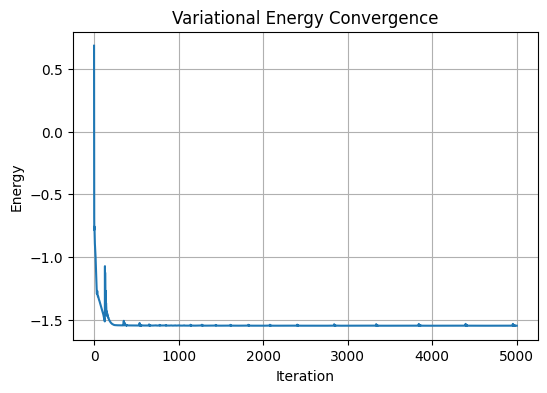

In [19]:
plt.figure(figsize=(6,4))
plt.plot(energy_history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Variational Energy Convergence")
plt.grid(True)
plt.show()


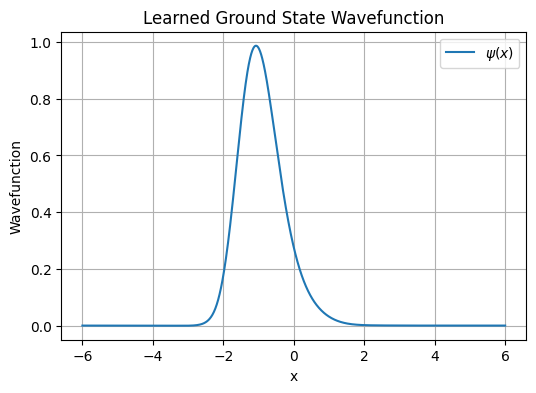

In [21]:
with torch.no_grad():
    psi_final = psi_model(x)
    norm = torch.sqrt(torch.sum(psi_final**2) * dx)
    psi_final = psi_final / norm

plt.figure(figsize=(6,4))
plt.plot(
    x.detach().cpu().numpy(),
    psi_final.detach().cpu().numpy(),
    label=r"$\psi(x)$"
)

plt.xlabel("x")
plt.ylabel("Wavefunction")
plt.title("Learned Ground State Wavefunction")
plt.grid(True)
plt.legend()
plt.show()


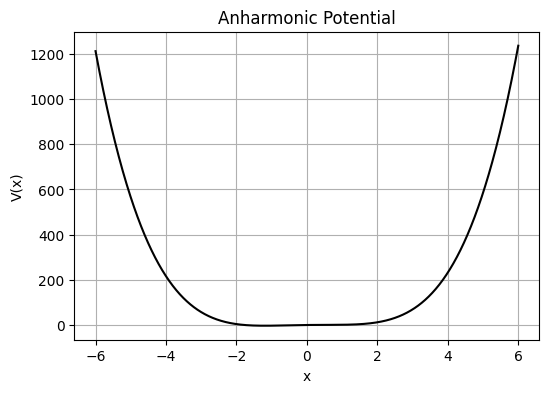

In [24]:
# Autodiff grid (used for energy computation)
x = torch.linspace(-L, L, N, device=device, requires_grad=True)
dx = x[1] - x[0]

# Non-grad grid (used only for plotting)
x_plot = x.detach()


plt.figure(figsize=(6,4))
plt.plot(
    x_plot.cpu().numpy(),
    V(x_plot).cpu().numpy(),
    color="black"
)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Anharmonic Potential")
plt.grid(True)
plt.show()


In [25]:
final_energy = energy_history[-1]
final_energy


-1.547266644445879

# Extended Experiments

The first basic experiment above was completed quickly so I decided to check the results with more comprehensive experiments. Also generated using LLM-coding assistants.

# Stage 0: Environment setup, device, and output folders

In [26]:
# ============================================
# Stage 0 — Environment + experiment scaffolding
# ============================================
# Purpose:
# - Ensure reproducibility (seeds)
# - Use GPU (A100) if available
# - Create required output folder structure:
#     "1 - RESEARCH/PSITest" and subfolders for runs/logs/figures/data/checkpoints

import os, json, time, math, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# Reference solver dependencies (CPU)
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# ---------- Reproducibility ----------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU name:", torch.cuda.get_device_name(0))

# ---------- Numeric precision ----------
# float64: better physics accuracy (often worth it for variational PDE problems)
# float32: faster. With an A100, float64 is still quite usable for this scale.
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# ---------- Output folders ----------
BASE_DIR = Path("1 - RESEARCH/PSITest")  # required
RUN_ID = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = BASE_DIR / "runs" / RUN_ID

DIR_DATA = RUN_DIR / "data"
DIR_FIGS = RUN_DIR / "figures"
DIR_CKPT = RUN_DIR / "checkpoints"
DIR_LOGS = RUN_DIR / "logs"

for p in [BASE_DIR, RUN_DIR, DIR_DATA, DIR_FIGS, DIR_CKPT, DIR_LOGS]:
    p.mkdir(parents=True, exist_ok=True)

print("Run directory:", RUN_DIR.resolve())

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def save_fig(fig, name: str, dpi: int = 180):
    out = DIR_FIGS / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)


Device: cuda
GPU name: Tesla T4
Run directory: /content/1 - RESEARCH/PSITest/runs/20251215_002508


# Stage 1: Define potential, domain, grid, and plotting helpers

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/01_potential.png


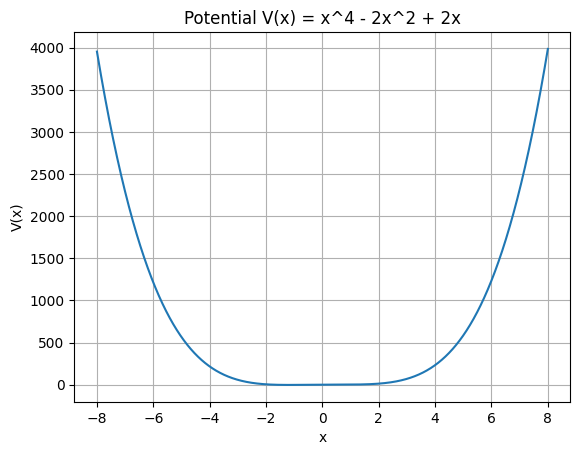

In [27]:
# ============================================
# Stage 1 — Physics definition + discretization
# ============================================
# Purpose:
# - Define potential V(x) = x^4 - 2x^2 + 2x
# - Choose domain [-L, L] and a uniform grid
# - Implement trapz integration on uniform grid
# - Basic visualization of potential

# --- Hyperparameters for discretization ---
L = 8.0          # domain half-width
N = 4096         # number of grid points
x_np = np.linspace(-L, L, N)
dx = x_np[1] - x_np[0]

# Torch versions for training
x = torch.tensor(x_np, device=device, dtype=DTYPE)

def V_torch(x: torch.Tensor) -> torch.Tensor:
    """Anharmonic confining potential V(x) = x^4 - 2x^2 + 2x."""
    return x**4 - 2.0*x**2 + 2.0*x

Vx = V_torch(x)

def trapz_uniform(y: torch.Tensor, dx: float) -> torch.Tensor:
    """
    Trapezoidal integral on a uniform grid:
      ∫ y dx ≈ dx * (0.5*y0 + y1 + ... + y_{N-2} + 0.5*y_{N-1})
    Differentiable w.r.t y.
    """
    return dx * (0.5*y[0] + y[1:-1].sum() + 0.5*y[-1])

# Save run config early
config = {
    "seed": SEED,
    "dtype": str(DTYPE),
    "device": str(device),
    "L": L,
    "N": N,
    "dx": dx,
}
save_json(config, DIR_DATA / "config.json")

# --- Visualize the potential ---
fig = plt.figure()
plt.plot(x_np, (x_np**4 - 2*x_np**2 + 2*x_np))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Potential V(x) = x^4 - 2x^2 + 2x")
plt.grid(True)
save_fig(fig, "01_potential.png")
plt.show()


# Stage 2: Reference eigensolver via finite differences (baseline validation)

Reference ground energy (FD eigensolver): -1.5473806477778949
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/02_reference_wavefunction.png


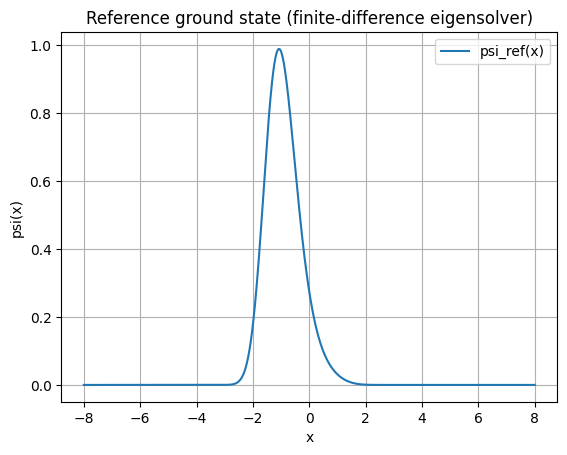

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/03_reference_density.png


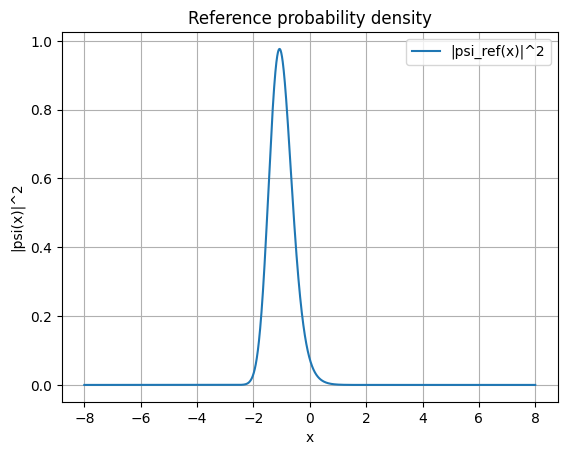

In [28]:
# ============================================
# Stage 2 — Reference solution (finite-difference eigensolver)
# ============================================
# Purpose:
# - Discretize H = -1/2 d^2/dx^2 + V(x) with Dirichlet boundaries psi(±L)=0
# - Compute smallest eigenvalue/eigenvector using sparse eigensolver
# - Normalize wavefunction in continuous sense (∫|psi|^2 dx = 1)
# - Save baseline to disk for later comparison

# Interior points for Dirichlet BCs (exclude endpoints)
x_int = x_np[1:-1]
Nint = x_int.size

V_int = x_int**4 - 2*x_int**2 + 2*x_int  # numpy

# Kinetic operator with central differences:
# (-1/2) d^2/dx^2 ≈ (-1/2) * (psi_{i+1} - 2 psi_i + psi_{i-1}) / dx^2
# => main diag:  1/dx^2, off diag: -1/(2 dx^2)
main = (1.0 / dx**2) * np.ones(Nint)
off  = (-1.0 / (2.0 * dx**2)) * np.ones(Nint - 1)

T = sp.diags([off, main, off], offsets=[-1, 0, 1], format="csr")
Vmat = sp.diags(V_int, offsets=0, format="csr")
H = T + Vmat

# Smallest algebraic eigenpair
# (k=1, which="SA" = smallest algebraic)
evals, evecs = spla.eigsh(H, k=1, which="SA", tol=1e-10, maxiter=5_000)
E0_ref = float(evals[0])
psi0_ref = np.array(evecs[:, 0], dtype=np.float64)

# Continuous normalization: ∫ |psi|^2 dx = 1 on interior with dx
norm_ref = np.sqrt(dx * np.sum(psi0_ref**2))
psi0_ref = psi0_ref / norm_ref

# Pad with boundary zeros for plotting on full grid
psi0_full = np.zeros_like(x_np, dtype=np.float64)
psi0_full[1:-1] = psi0_ref

print("Reference ground energy (FD eigensolver):", E0_ref)

# Save reference results
np.savez(
    DIR_DATA / "reference_fd.npz",
    x=x_np,
    V=(x_np**4 - 2*x_np**2 + 2*x_np),
    E0_ref=E0_ref,
    psi0_ref=psi0_full
)

# Plot reference wavefunction and probability density
fig = plt.figure()
plt.plot(x_np, psi0_full, label="psi_ref(x)")
plt.xlabel("x")
plt.ylabel("psi(x)")
plt.title("Reference ground state (finite-difference eigensolver)")
plt.grid(True)
plt.legend()
save_fig(fig, "02_reference_wavefunction.png")
plt.show()

fig = plt.figure()
plt.plot(x_np, psi0_full**2, label="|psi_ref(x)|^2")
plt.xlabel("x")
plt.ylabel("|psi(x)|^2")
plt.title("Reference probability density")
plt.grid(True)
plt.legend()
save_fig(fig, "03_reference_density.png")
plt.show()


# Stage 3: Neural-network wavefunction ansatz

In [29]:
# ============================================
# Stage 3 — Variational ansatz (neural wavefunction)
# ============================================
# Purpose:
# - Define a small MLP f_theta(x)
# - Wrap it with an envelope to enforce decay and boundary conditions
# - Use a positive amplitude (Softplus) to bias toward a nodeless ground state

class MLP(nn.Module):
    def __init__(self, hidden=64, depth=3, act="tanh"):
        super().__init__()
        acts = {"tanh": nn.Tanh(), "silu": nn.SiLU(), "gelu": nn.GELU()}
        activation = acts[act]

        layers = [nn.Linear(1, hidden), activation]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), activation]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class WaveFunction(nn.Module):
    """
    psi_theta(x) = envelope(x) * softplus( f_theta(x) )

    envelope(x) ensures:
    - psi(±L)=0 (Dirichlet) via (1 - (x/L)^2)
    - additional decay via exp(-a x^2)
    """
    def __init__(self, L: float, hidden=64, depth=3, act="tanh", a=0.5):
        super().__init__()
        self.L = float(L)
        self.a = float(a)
        self.f = MLP(hidden=hidden, depth=depth, act=act)

    def envelope(self, x):
        # x is torch tensor on device
        # (1 - (x/L)^2) makes psi exactly 0 at boundaries
        # exp(-a x^2) improves decay inside the box
        return torch.exp(-self.a * x**2) * (1.0 - (x / self.L)**2).clamp(min=0.0)

    def forward(self, x):
        # x shape: [N] or [N,1]
        if x.ndim == 1:
            x_in = x[:, None]
        else:
            x_in = x
        amp = F.softplus(self.f(x_in)).squeeze(-1) + 1e-12
        return self.envelope(x) * amp

# Instantiate model
model = WaveFunction(L=L, hidden=64, depth=3, act="tanh", a=0.35).to(device)

# Quick forward pass sanity check
with torch.no_grad():
    psi_test = model(x)
print("psi_test shape:", psi_test.shape, "dtype:", psi_test.dtype)


psi_test shape: torch.Size([4096]) dtype: torch.float64


# Stage 4: Differentiable energy functional

In [30]:
# ============================================
# Stage 4 — Energy functional (differentiable)
# ============================================
# Purpose:
# - Compute E = <psi|H|psi> / <psi|psi>
# - Use stable form:
#     <psi|H|psi> = ∫ [ 0.5 |dpsi/dx|^2 + V(x)|psi|^2 ] dx
# - Use central finite differences for dpsi/dx
# - Return diagnostics: kinetic, potential, norm, boundary mass

def grad_central(psi: torch.Tensor, dx: float) -> torch.Tensor:
    """
    Central difference derivative (dpsi/dx), differentiable w.r.t psi.
    One-sided at boundaries.
    """
    d = torch.empty_like(psi)
    d[1:-1] = (psi[2:] - psi[:-2]) / (2.0 * dx)
    d[0] = (psi[1] - psi[0]) / dx
    d[-1] = (psi[-1] - psi[-2]) / dx
    return d

def energy_functional(model: nn.Module, x: torch.Tensor, Vx: torch.Tensor, dx: float):
    """
    Returns:
      E, kinetic, potential, norm, boundary_mass
    where boundary_mass is probability mass in the outer 10% of the domain
    (a practical diagnostic: should be tiny if L is large enough).
    """
    psi = model(x)
    psi2 = psi**2

    norm = trapz_uniform(psi2, dx)

    dpsi = grad_central(psi, dx)
    kinetic = 0.5 * trapz_uniform(dpsi**2, dx)
    potential = trapz_uniform(Vx * psi2, dx)

    E = (kinetic + potential) / norm

    # Boundary mass diagnostic (outer 10% on each side)
    n_edge = max(1, int(0.10 * psi.numel()))
    boundary_mass = (
        trapz_uniform(psi2[:n_edge], dx) + trapz_uniform(psi2[-n_edge:], dx)
    ) / norm

    return E, kinetic / norm, potential / norm, norm, boundary_mass

# Sanity check value before training
E0, K0, U0, N0, bm0 = energy_functional(model, x, Vx, dx)
print("Initial E:", float(E0.detach().cpu()))
print("Initial K,U:", float(K0.detach().cpu()), float(U0.detach().cpu()))
print("Initial norm (unnormalized):", float(N0.detach().cpu()))
print("Initial boundary mass:", float(bm0.detach().cpu()))


Initial E: 0.26856578617966553
Initial K,U: 0.19232276643201981 0.07624301974764575
Initial norm (unnormalized): 1.1985093435307264
Initial boundary mass: 3.2656849338553247e-15


# Stage 5: Training loop (AdamW + checkpoints + logs)

In [31]:
# ============================================
# Stage 5 — Optimization loop
# ============================================
# Purpose:
# - Minimize variational energy using AdamW
# - Record metrics each step
# - Save logs and periodic checkpoints to required folders

steps = 6000
lr = 2e-3
weight_decay = 1e-6
grad_clip = 1.0
ckpt_every = 1000
print_every = 200

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

log_rows = []

t0 = time.time()
for step in range(1, steps + 1):
    optimizer.zero_grad(set_to_none=True)

    E, K, U, norm, boundary_mass = energy_functional(model, x, Vx, dx)

    E.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    # record
    row = {
        "step": step,
        "E": float(E.detach().cpu()),
        "K": float(K.detach().cpu()),
        "U": float(U.detach().cpu()),
        "norm": float(norm.detach().cpu()),
        "boundary_mass": float(boundary_mass.detach().cpu()),
        "E_ref": E0_ref,
        "E_minus_ref": float(E.detach().cpu()) - E0_ref,
    }
    log_rows.append(row)

    if step % print_every == 0 or step == 1:
        elapsed = time.time() - t0
        print(
            f"[{step:5d}/{steps}] "
            f"E={row['E']:.8f}  (E-Eref)={row['E_minus_ref']:+.3e}  "
            f"bm={row['boundary_mass']:.3e}  elapsed={elapsed:.1f}s"
        )

    if step % ckpt_every == 0:
        ckpt_path = DIR_CKPT / f"model_step_{step:06d}.pt"
        torch.save(
            {
                "step": step,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "config": config,
            },
            ckpt_path,
        )
        print("Saved checkpoint:", ckpt_path)

# Save training log
df_log = pd.DataFrame(log_rows)
log_path = DIR_LOGS / "training_log.csv"
df_log.to_csv(log_path, index=False)
print("Saved log:", log_path)

# Save final model
final_model_path = DIR_CKPT / "model_final.pt"
torch.save({"model_state": model.state_dict(), "config": config}, final_model_path)
print("Saved final model:", final_model_path)


[    1/6000] E=0.26856579  (E-Eref)=+1.816e+00  bm=3.266e-15  elapsed=0.1s
[  200/6000] E=-1.54679536  (E-Eref)=+5.853e-04  bm=2.357e-17  elapsed=1.0s
[  400/6000] E=-1.54713103  (E-Eref)=+2.496e-04  bm=7.924e-18  elapsed=1.8s
[  600/6000] E=-1.54724124  (E-Eref)=+1.394e-04  bm=3.630e-18  elapsed=2.7s
[  800/6000] E=-1.54729343  (E-Eref)=+8.722e-05  bm=1.918e-18  elapsed=3.6s
[ 1000/6000] E=-1.54732463  (E-Eref)=+5.602e-05  bm=1.110e-18  elapsed=4.5s
Saved checkpoint: 1 - RESEARCH/PSITest/runs/20251215_002508/checkpoints/model_step_001000.pt
[ 1200/6000] E=-1.54714361  (E-Eref)=+2.370e-04  bm=5.917e-19  elapsed=5.4s
[ 1400/6000] E=-1.54735719  (E-Eref)=+2.346e-05  bm=4.411e-19  elapsed=6.2s
[ 1600/6000] E=-1.54736592  (E-Eref)=+1.473e-05  bm=3.083e-19  elapsed=7.1s
[ 1800/6000] E=-1.54737132  (E-Eref)=+9.324e-06  bm=1.926e-19  elapsed=8.0s
[ 2000/6000] E=-1.54737599  (E-Eref)=+4.657e-06  bm=1.539e-19  elapsed=8.9s
Saved checkpoint: 1 - RESEARCH/PSITest/runs/20251215_002508/checkpoints/

# Stage 5b (optional): LBFGS refinement pass

In [32]:
# ============================================
# Stage 5b — Optional: LBFGS refinement
# ============================================
# Purpose:
# - Use a second-stage optimizer (quasi-Newton) for fine convergence.
# - Keep it short; LBFGS is more expensive per step.

use_lbfgs = True
if use_lbfgs:
    lbfgs_steps = 250
    lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=lbfgs_steps, line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad(set_to_none=True)
        E, *_ = energy_functional(model, x, Vx, dx)
        E.backward()
        return E

    E_before = float(energy_functional(model, x, Vx, dx)[0].detach().cpu())
    lbfgs.step(closure)
    E_after = float(energy_functional(model, x, Vx, dx)[0].detach().cpu())
    print("LBFGS refinement: E before -> after:", E_before, "->", E_after)

    # Save post-LBFGS model
    torch.save({"model_state": model.state_dict(), "config": config}, DIR_CKPT / "model_final_lbfgs.pt")


LBFGS refinement: E before -> after: -1.5473712198420388 -> -1.5473947288359042


# Stage 6: Final evaluation

In [33]:
# ============================================
# Stage 6 — Final evaluation + comparison to reference
# ============================================
# Purpose:
# - Compute final energy and diagnostics
# - Normalize psi_nn so ∫|psi|^2 dx = 1
# - Compute overlap with reference solution for validation
# - Save arrays for downstream use

@torch.no_grad()
def normalize_wavefunction(psi: torch.Tensor, dx: float) -> torch.Tensor:
    norm = torch.sqrt(trapz_uniform(psi**2, dx))
    return psi / norm

with torch.no_grad():
    psi_nn = model(x)
    psi_nn = normalize_wavefunction(psi_nn, dx)
    E_nn, K_nn, U_nn, norm_nn, bm_nn = energy_functional(lambda z: psi_nn, x, Vx, dx)  # fixed psi

E_nn = float(E_nn.cpu())
K_nn = float(K_nn.cpu())
U_nn = float(U_nn.cpu())
bm_nn = float(bm_nn.cpu())

print("Final NN energy:", E_nn)
print("Reference energy:", E0_ref)
print("Delta:", E_nn - E0_ref)
print("Kinetic:", K_nn, "Potential:", U_nn)
print("Boundary mass:", bm_nn)

# Bring to CPU numpy for saving/plotting
psi_nn_np = psi_nn.detach().cpu().numpy()

# Align sign with reference for clean comparison (both represent same physical state)
# Choose sign that maximizes overlap.
overlap_pos = dx * np.sum(psi_nn_np * psi0_full)
if overlap_pos < 0:
    psi_nn_np = -psi_nn_np
overlap = dx * np.sum(psi_nn_np * psi0_full)

print("Overlap <psi_nn|psi_ref>:", overlap)

# Save final results
np.savez(
    DIR_DATA / "final_results.npz",
    x=x_np,
    V=(x_np**4 - 2*x_np**2 + 2*x_np),
    E_nn=E_nn,
    E_ref=E0_ref,
    overlap=overlap,
    psi_nn=psi_nn_np,
    psi_ref=psi0_full,
)
print("Saved:", DIR_DATA / "final_results.npz")


Final NN energy: -1.5473947288359042
Reference energy: -1.5473806477778949
Delta: -1.4081058009374203e-05
Kinetic: 0.7462661809551108 Potential: -2.293660909791015
Boundary mass: 3.986595513731347e-21
Overlap <psi_nn|psi_ref>: 0.9999999978904969
Saved: 1 - RESEARCH/PSITest/runs/20251215_002508/data/final_results.npz


# Stage 7: Visualizations

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/10_energy_vs_step.png


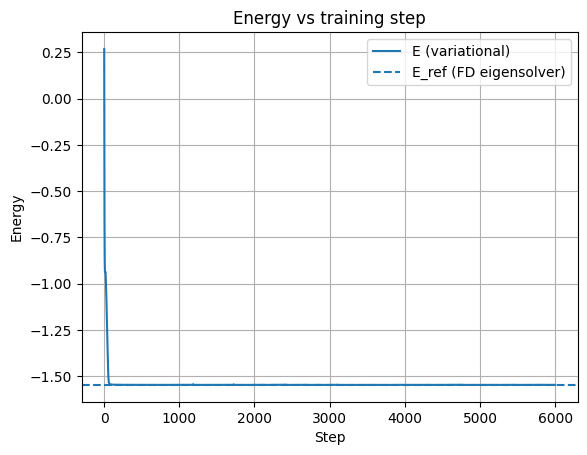

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/11_energy_error_vs_step.png


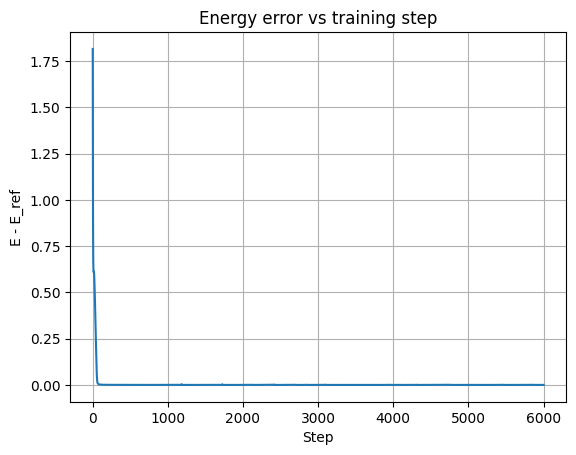

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/12_energy_decomposition.png


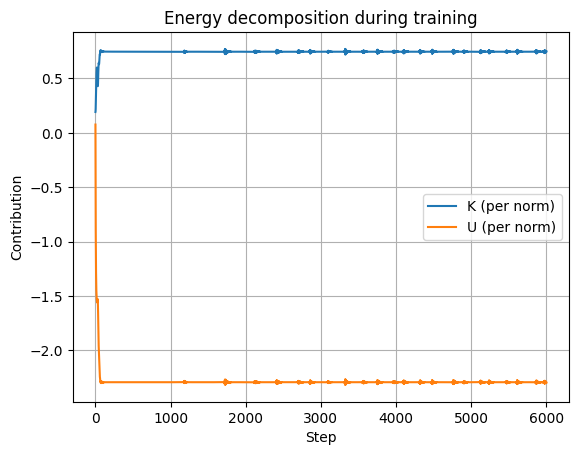

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/13_boundary_mass.png


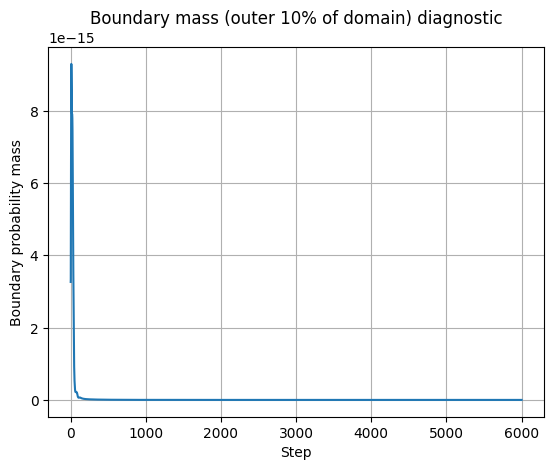

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/14_wavefunction_comparison.png


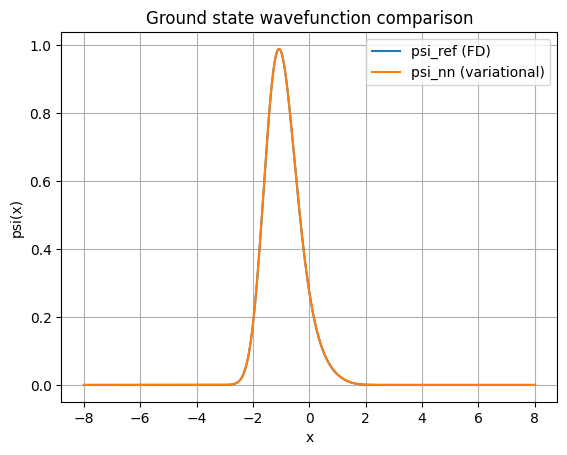

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/15_density_comparison.png


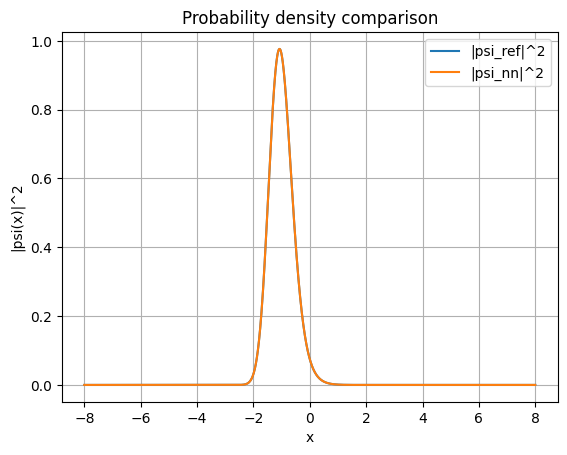

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/figures/16_potential_and_density.png


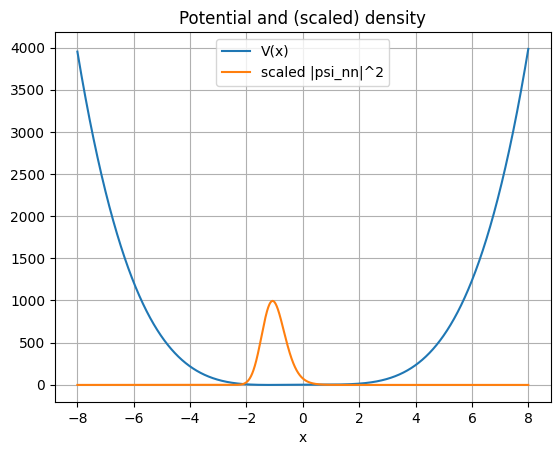

In [34]:
# ============================================
# Stage 7 — Visualizations
# ============================================
# Purpose:
# - Plot energy vs step (and E - E_ref)
# - Plot wavefunction comparison
# - Plot probability density comparison
# - Plot boundary mass diagnostic
# - Save all figures to "1 - RESEARCH/PSITest/.../figures"

df_log = pd.read_csv(DIR_LOGS / "training_log.csv")

# --- Energy vs step ---
fig = plt.figure()
plt.plot(df_log["step"], df_log["E"], label="E (variational)")
plt.axhline(E0_ref, linestyle="--", label="E_ref (FD eigensolver)")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.title("Energy vs training step")
plt.grid(True)
plt.legend()
save_fig(fig, "10_energy_vs_step.png")
plt.show()

# --- Energy error vs step ---
fig = plt.figure()
plt.plot(df_log["step"], df_log["E_minus_ref"])
plt.xlabel("Step")
plt.ylabel("E - E_ref")
plt.title("Energy error vs training step")
plt.grid(True)
save_fig(fig, "11_energy_error_vs_step.png")
plt.show()

# --- Kinetic and Potential contributions ---
fig = plt.figure()
plt.plot(df_log["step"], df_log["K"], label="K (per norm)")
plt.plot(df_log["step"], df_log["U"], label="U (per norm)")
plt.xlabel("Step")
plt.ylabel("Contribution")
plt.title("Energy decomposition during training")
plt.grid(True)
plt.legend()
save_fig(fig, "12_energy_decomposition.png")
plt.show()

# --- Boundary mass diagnostic ---
fig = plt.figure()
plt.plot(df_log["step"], df_log["boundary_mass"])
plt.xlabel("Step")
plt.ylabel("Boundary probability mass")
plt.title("Boundary mass (outer 10% of domain) diagnostic")
plt.grid(True)
save_fig(fig, "13_boundary_mass.png")
plt.show()

# --- Wavefunction comparison ---
fig = plt.figure()
plt.plot(x_np, psi0_full, label="psi_ref (FD)")
plt.plot(x_np, psi_nn_np, label="psi_nn (variational)")
plt.xlabel("x")
plt.ylabel("psi(x)")
plt.title("Ground state wavefunction comparison")
plt.grid(True)
plt.legend()
save_fig(fig, "14_wavefunction_comparison.png")
plt.show()

# --- Probability density comparison ---
fig = plt.figure()
plt.plot(x_np, psi0_full**2, label="|psi_ref|^2")
plt.plot(x_np, psi_nn_np**2, label="|psi_nn|^2")
plt.xlabel("x")
plt.ylabel("|psi(x)|^2")
plt.title("Probability density comparison")
plt.grid(True)
plt.legend()
save_fig(fig, "15_density_comparison.png")
plt.show()

# --- Potential with density overlay (scaled for readability) ---
fig = plt.figure()
V_plot = x_np**4 - 2*x_np**2 + 2*x_np
rho = psi_nn_np**2
rho_scaled = rho / rho.max() * (V_plot.max() - V_plot.min()) * 0.25 + V_plot.min()

plt.plot(x_np, V_plot, label="V(x)")
plt.plot(x_np, rho_scaled, label="scaled |psi_nn|^2")
plt.xlabel("x")
plt.title("Potential and (scaled) density")
plt.grid(True)
plt.legend()
save_fig(fig, "16_potential_and_density.png")
plt.show()


# Additional: excited state (orthogonality penalty)

In [35]:
# ============================================
# Optional — Excited state via orthogonality penalty
# ============================================
# Purpose:
# - Demonstrate extension: compute first excited state by enforcing orthogonality to ground.
# - Uses the learned ground state psi_nn (or reference) as psi0.

do_excited = False
if do_excited:
    psi0_fixed = torch.tensor(psi_nn_np, device=device, dtype=DTYPE)  # learned ground
    psi0_fixed = psi0_fixed / torch.sqrt(trapz_uniform(psi0_fixed**2, dx))

    model1 = WaveFunction(L=L, hidden=64, depth=3, act="tanh", a=0.35).to(device)
    opt1 = torch.optim.AdamW(model1.parameters(), lr=2e-3)

    lam = 50.0
    steps1 = 8000
    log1 = []

    for step in range(1, steps1 + 1):
        opt1.zero_grad(set_to_none=True)

        psi1 = model1(x)
        # Normalize psi1 (helps orthogonality conditioning)
        norm1 = torch.sqrt(trapz_uniform(psi1**2, dx))
        psi1n = psi1 / norm1

        # Energy of normalized psi
        dpsi1 = grad_central(psi1n, dx)
        K1 = 0.5 * trapz_uniform(dpsi1**2, dx)
        U1 = trapz_uniform(Vx * (psi1n**2), dx)
        E1 = K1 + U1

        overlap10 = trapz_uniform(psi1n * psi0_fixed, dx)
        loss = E1 + lam * overlap10**2

        loss.backward()
        opt1.step()

        if step % 400 == 0:
            print(step, "E1:", float(E1.detach().cpu()), "overlap:", float(overlap10.detach().cpu()))
        log1.append([step, float(E1.detach().cpu()), float(overlap10.detach().cpu())])

    np.savetxt(DIR_LOGS / "excited_log.csv", np.array(log1), delimiter=",", header="step,E1,overlap", comments="")


# Extensions



In [36]:
# ============================================
# Stage 8 — Reusable experiment components
# ============================================
# Purpose:
# - Turn the earlier one-off implementation into reusable functions so that:
#   (a) excited states are just "same training loop + orthogonality"
#   (b) different potentials are just swapping V(x)
#   (c) architecture/ansatz exploration is just swapping model factories
#   (d) hyperparameter studies become easy loops producing tables/plots
#   (e) eigensolver comparison works for multiple states consistently
#
# Relation to overall problem:
# - Enables systematic experiments that build on the base variational solver. :contentReference[oaicite:1]{index=1}

import os, json, time, math
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.optimize import linear_sum_assignment

# ---------- Folder plumbing ----------
# Expect BASE_DIR / RUN_DIR / DIR_* from earlier stages.
# If not present (e.g. someone runs this cell standalone), create them.
try:
    BASE_DIR
except NameError:
    BASE_DIR = Path("1 - RESEARCH/PSITest")
    BASE_DIR.mkdir(parents=True, exist_ok=True)

try:
    RUN_DIR
except NameError:
    RUN_ID = time.strftime("%Y%m%d_%H%M%S")
    RUN_DIR = BASE_DIR / "runs" / RUN_ID
    RUN_DIR.mkdir(parents=True, exist_ok=True)

EXT_DIR = RUN_DIR / "extensions"
EXT_DIR.mkdir(parents=True, exist_ok=True)

def exp_dir(tag: str) -> Path:
    """Create and return an experiment subdirectory under this run."""
    d = EXT_DIR / tag
    (d / "data").mkdir(parents=True, exist_ok=True)
    (d / "figures").mkdir(parents=True, exist_ok=True)
    (d / "checkpoints").mkdir(parents=True, exist_ok=True)
    (d / "logs").mkdir(parents=True, exist_ok=True)
    return d

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def save_fig_to(fig, fig_dir: Path, name: str, dpi: int = 180):
    fig_dir.mkdir(parents=True, exist_ok=True)
    out = fig_dir / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)

# ---------- Numerics helpers ----------
# These mirror the base solution but are re-defined here for safety/idempotence.

def make_grid(L: float, N: int, device: torch.device, dtype: torch.dtype):
    """Uniform grid on [-L, L]. Returns (x_np, x_torch, dx)."""
    x_np = np.linspace(-L, L, N)
    dx = x_np[1] - x_np[0]
    x = torch.tensor(x_np, device=device, dtype=dtype)
    return x_np, x, dx

def trapz_uniform(y: torch.Tensor, dx: float) -> torch.Tensor:
    """Trapezoidal integral on a uniform grid; differentiable w.r.t y."""
    return dx * (0.5*y[0] + y[1:-1].sum() + 0.5*y[-1])

def grad_central(psi: torch.Tensor, dx: float) -> torch.Tensor:
    """Central difference derivative; one-sided at boundaries."""
    d = torch.empty_like(psi)
    d[1:-1] = (psi[2:] - psi[:-2]) / (2.0 * dx)
    d[0] = (psi[1] - psi[0]) / dx
    d[-1] = (psi[-1] - psi[-2]) / dx
    return d

@torch.no_grad()
def normalize_psi(psi: torch.Tensor, dx: float) -> torch.Tensor:
    """Normalize so ∫|psi|^2 dx = 1."""
    nrm = torch.sqrt(trapz_uniform(psi**2, dx))
    return psi / (nrm + 1e-18)

def energy_from_normalized_psi(psi_n: torch.Tensor, Vx: torch.Tensor, dx: float):
    """
    Energy for a *normalized* wavefunction.
    E = ∫ [ 0.5 |psi'|^2 + V|psi|^2 ] dx
    """
    dpsi = grad_central(psi_n, dx)
    K = 0.5 * trapz_uniform(dpsi**2, dx)
    U = trapz_uniform(Vx * (psi_n**2), dx)
    E = K + U
    return E, K, U

def boundary_mass(psi_n: torch.Tensor, dx: float, frac: float = 0.10) -> torch.Tensor:
    """Probability mass in the outer frac of the domain (both sides)."""
    n_edge = max(1, int(frac * psi_n.numel()))
    mass = trapz_uniform(psi_n[:n_edge]**2, dx) + trapz_uniform(psi_n[-n_edge:]**2, dx)
    return mass


# Stage 9: Eigensolver comparison

In [37]:
# ============================================
# Stage 9 — Numerical eigensolver (finite-difference, k states)
# ============================================
# Purpose:
# - Produce a high-quality reference spectrum {E_n, psi_n(x)} for comparison.
# - Works for the ground state and excited states.
# - This is the "ground truth" benchmark for the variational results. :contentReference[oaicite:3]{index=3}

def fd_eigensolve_k(x_np: np.ndarray, V_np: np.ndarray, dx: float, k: int = 6):
    """
    Dirichlet boundaries psi(±L)=0, interior FD discretization.
    Returns:
      evals: shape (k,)
      psis:  shape (k, N_full) (padded with boundary zeros), each normalized to ∫|psi|^2 dx = 1
    """
    assert x_np.ndim == 1 and V_np.shape == x_np.shape
    N_full = x_np.size
    V_int = V_np[1:-1]
    Nint = V_int.size

    # Kinetic operator: (-1/2)d^2/dx^2
    main = (1.0 / dx**2) * np.ones(Nint)
    off  = (-1.0 / (2.0 * dx**2)) * np.ones(Nint - 1)
    T = sp.diags([off, main, off], offsets=[-1, 0, 1], format="csr")
    Vmat = sp.diags(V_int, offsets=0, format="csr")
    H = T + Vmat

    # eigsh returns k smallest algebraic eigenpairs (for confining potentials)
    evals, evecs = spla.eigsh(H, k=k, which="SA", tol=1e-10, maxiter=20_000)

    # Sort by energy
    idx = np.argsort(evals)
    evals = np.array(evals[idx], dtype=np.float64)
    evecs = np.array(evecs[:, idx], dtype=np.float64)  # interior vectors

    # Normalize each eigenvector in continuous sense and pad
    psis = np.zeros((k, N_full), dtype=np.float64)
    for i in range(k):
        psi_int = evecs[:, i]
        psi_int = psi_int / np.sqrt(dx * np.sum(psi_int**2))
        psis[i, 1:-1] = psi_int

    return evals, psis

def plot_reference_spectrum(x_np, V_np, evals, psis, out_dir: Path, tag: str):
    fig_dir = out_dir / "figures"

    # Potential + energies
    fig = plt.figure()
    plt.plot(x_np, V_np, label="V(x)")
    for n, En in enumerate(evals):
        plt.axhline(En, linestyle="--", label=f"E{n}={En:.4f}" if n < 6 else None)
    plt.xlabel("x"); plt.ylabel("Energy / Potential")
    plt.title(f"Reference spectrum (FD): {tag}")
    plt.grid(True)
    plt.legend(ncol=2, fontsize=9)
    save_fig_to(fig, fig_dir, f"ref_spectrum_{tag}.png")
    plt.show()

    # Wavefunctions
    fig = plt.figure()
    for n in range(min(len(evals), 6)):
        plt.plot(x_np, psis[n], label=f"psi{n}")
    plt.xlabel("x"); plt.ylabel("psi_n(x)")
    plt.title(f"Reference eigenfunctions (first 6): {tag}")
    plt.grid(True)
    plt.legend()
    save_fig_to(fig, fig_dir, f"ref_wavefunctions_{tag}.png")
    plt.show()


# Stage 10: Configurations for experiments etc

In [38]:
# ============================================
# Stage 10 — Potential registry (swap V(x) easily)
# ============================================
# Purpose:
# - Define several confining potentials (all grow ~ x^4 or x^2 at infinity)
# - Allow easy experimentation via a single name + parameters. :contentReference[oaicite:5]{index=5}

@dataclass
class PotentialSpec:
    name: str
    fn_torch: Callable[[torch.Tensor], torch.Tensor]
    fn_numpy: Callable[[np.ndarray], np.ndarray]
    recommended_L: float

def make_potentials() -> Dict[str, PotentialSpec]:
    pots = {}

    # Original assignment potential
    pots["quartic_tilted"] = PotentialSpec(
        name="quartic_tilted",
        fn_torch=lambda x: x**4 - 2.0*x**2 + 2.0*x,
        fn_numpy=lambda x: x**4 - 2.0*x**2 + 2.0*x,
        recommended_L=8.0,
    )

    # Harmonic oscillator (omega=1): V=0.5 x^2
    pots["harmonic"] = PotentialSpec(
        name="harmonic",
        fn_torch=lambda x: 0.5 * x**2,
        fn_numpy=lambda x: 0.5 * x**2,
        recommended_L=6.0,
    )

    # Symmetric double well: x^4 - a x^2  (a=2 gives two wells)
    a = 2.0
    pots["double_well_a2"] = PotentialSpec(
        name="double_well_a2",
        fn_torch=lambda x, a=a: x**4 - a*x**2,
        fn_numpy=lambda x, a=a: x**4 - a*x**2,
        recommended_L=8.0,
    )

    # Stiffer quartic: x^4 + 0.5 x^2
    alpha = 0.5
    pots["quartic_plus_quadratic"] = PotentialSpec(
        name="quartic_plus_quadratic",
        fn_torch=lambda x, alpha=alpha: x**4 + alpha*x**2,
        fn_numpy=lambda x, alpha=alpha: x**4 + alpha*x**2,
        recommended_L=7.0,
    )

    return pots

POTENTIALS = make_potentials()

def plot_potential(x_np: np.ndarray, V_np: np.ndarray, out_dir: Path, tag: str):
    fig = plt.figure()
    plt.plot(x_np, V_np)
    plt.xlabel("x"); plt.ylabel("V(x)")
    plt.title(f"Potential: {tag}")
    plt.grid(True)
    save_fig_to(fig, out_dir / "figures", f"potential_{tag}.png")
    plt.show()


In [39]:
## Example

# ============================================
# Stage 10 — Potential registry (swap V(x) easily)
# ============================================
# Purpose:
# - Define several confining potentials (all grow ~ x^4 or x^2 at infinity)
# - Allow easy experimentation via a single name + parameters. :contentReference[oaicite:5]{index=5}

@dataclass
class PotentialSpec:
    name: str
    fn_torch: Callable[[torch.Tensor], torch.Tensor]
    fn_numpy: Callable[[np.ndarray], np.ndarray]
    recommended_L: float

def make_potentials() -> Dict[str, PotentialSpec]:
    pots = {}

    # Original assignment potential
    pots["quartic_tilted"] = PotentialSpec(
        name="quartic_tilted",
        fn_torch=lambda x: x**4 - 2.0*x**2 + 2.0*x,
        fn_numpy=lambda x: x**4 - 2.0*x**2 + 2.0*x,
        recommended_L=8.0,
    )

    # Harmonic oscillator (omega=1): V=0.5 x^2
    pots["harmonic"] = PotentialSpec(
        name="harmonic",
        fn_torch=lambda x: 0.5 * x**2,
        fn_numpy=lambda x: 0.5 * x**2,
        recommended_L=6.0,
    )

    # Symmetric double well: x^4 - a x^2  (a=2 gives two wells)
    a = 2.0
    pots["double_well_a2"] = PotentialSpec(
        name="double_well_a2",
        fn_torch=lambda x, a=a: x**4 - a*x**2,
        fn_numpy=lambda x, a=a: x**4 - a*x**2,
        recommended_L=8.0,
    )

    # Stiffer quartic: x^4 + 0.5 x^2
    alpha = 0.5
    pots["quartic_plus_quadratic"] = PotentialSpec(
        name="quartic_plus_quadratic",
        fn_torch=lambda x, alpha=alpha: x**4 + alpha*x**2,
        fn_numpy=lambda x, alpha=alpha: x**4 + alpha*x**2,
        recommended_L=7.0,
    )

    return pots

POTENTIALS = make_potentials()

def plot_potential(x_np: np.ndarray, V_np: np.ndarray, out_dir: Path, tag: str):
    fig = plt.figure()
    plt.plot(x_np, V_np)
    plt.xlabel("x"); plt.ylabel("V(x)")
    plt.title(f"Potential: {tag}")
    plt.grid(True)
    save_fig_to(fig, out_dir / "figures", f"potential_{tag}.png")
    plt.show()


# Stage 11: Different network architectures

In [40]:
# ============================================
# Stage 11 — Model/ansatz registry (swap architectures)
# ============================================
# Purpose:
# - Provide several wavefunction parameterizations:
#   A) Plain MLP + envelope
#   B) Fourier-feature MLP (often helps oscillations / excited states)
#   C) SIREN (sin activations; good for representing oscillatory modes)
#   D) RBF mixture (interpretable basis-like ansatz)
#
# Relation to overall problem:
# - Same variational objective, different representational biases. :contentReference[oaicite:7]{index=7}

class Envelope(nn.Module):
    """Dirichlet-ish envelope: forces psi(±L)=0 and adds Gaussian decay."""
    def __init__(self, L: float, a: float = 0.35):
        super().__init__()
        self.L = float(L)
        self.a = float(a)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # (1 - (x/L)^2) makes psi exactly 0 at boundaries; clamp to avoid negative tails
        return torch.exp(-self.a * x**2) * (1.0 - (x / self.L)**2).clamp(min=0.0)

class PlainMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int, depth: int, act: str):
        super().__init__()
        acts = {"tanh": nn.Tanh(), "silu": nn.SiLU(), "gelu": nn.GELU()}
        activation = acts[act]
        layers = [nn.Linear(in_dim, hidden), activation]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), activation]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class WaveAnsatz(nn.Module):
    """
    Generic wrapper:
      psi(x) = envelope(x) * amplitude(x)
    where amplitude can be signed (excited states) or positive (ground-state bias).
    """
    def __init__(self, core: nn.Module, envelope: Envelope, positive: bool):
        super().__init__()
        self.core = core
        self.envelope = envelope
        self.positive = positive

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 1:
            x_in = x[:, None]
        else:
            x_in = x
        raw = self.core(x_in).squeeze(-1)
        amp = (F.softplus(raw) + 1e-12) if self.positive else raw
        return self.envelope(x) * amp

# ---- Fourier features ----
class FourierFeatures(nn.Module):
    """Random Fourier feature map for 1D inputs."""
    def __init__(self, num_features: int, scale: float = 3.0):
        super().__init__()
        self.num_features = int(num_features)
        # Fixed random frequencies (not trained)
        B = torch.randn(self.num_features, 1) * scale
        self.register_buffer("B", B)

    def forward(self, x1: torch.Tensor) -> torch.Tensor:
        # x1 shape: [N,1]
        proj = 2.0 * math.pi * (x1 @ self.B.T)  # [N, F]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # [N, 2F]

class FourierMLPCore(nn.Module):
    def __init__(self, num_fourier: int, hidden: int, depth: int, act: str, scale: float = 3.0, include_x: bool = True):
        super().__init__()
        self.ff = FourierFeatures(num_fourier, scale=scale)
        in_dim = (2 * num_fourier) + (1 if include_x else 0)
        self.include_x = include_x
        self.mlp = PlainMLP(in_dim=in_dim, hidden=hidden, depth=depth, act=act)

    def forward(self, x1: torch.Tensor) -> torch.Tensor:
        feats = self.ff(x1)
        if self.include_x:
            feats = torch.cat([x1, feats], dim=-1)
        return self.mlp(feats)

# ---- SIREN ----
class SineLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, is_first: bool, omega0: float = 30.0):
        super().__init__()
        self.omega0 = omega0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)

        # SIREN-style init (simplified)
        with torch.no_grad():
            if is_first:
                self.linear.weight.uniform_(-1/in_features, 1/in_features)
            else:
                bound = math.sqrt(6/in_features) / omega0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, x):
        return torch.sin(self.omega0 * self.linear(x))

class SirenCore(nn.Module):
    def __init__(self, hidden: int = 64, depth: int = 3, omega0: float = 30.0):
        super().__init__()
        layers = [SineLayer(1, hidden, is_first=True, omega0=omega0)]
        for _ in range(depth - 1):
            layers.append(SineLayer(hidden, hidden, is_first=False, omega0=omega0))
        self.net = nn.Sequential(*layers)
        self.final = nn.Linear(hidden, 1)

    def forward(self, x1):
        h = self.net(x1)
        return self.final(h)

# ---- RBF mixture ----
class RBFCore(nn.Module):
    """
    amplitude(x) = Σ w_i exp(-0.5 * ((x - mu_i)/sigma_i)^2)
    """
    def __init__(self, M: int = 32, init_span: float = 3.0):
        super().__init__()
        self.M = int(M)
        mu = torch.linspace(-init_span, init_span, M)
        log_sigma = torch.zeros(M) + math.log(0.7)
        w = torch.randn(M) * 0.1
        self.mu = nn.Parameter(mu)
        self.log_sigma = nn.Parameter(log_sigma)
        self.w = nn.Parameter(w)

    def forward(self, x1):
        # x1: [N,1]
        x = x1.squeeze(-1)  # [N]
        sigma = torch.exp(self.log_sigma) + 1e-8  # [M]
        # [N, M]
        z = (x[:, None] - self.mu[None, :]) / sigma[None, :]
        phi = torch.exp(-0.5 * z**2)
        out = phi @ self.w[:, None]  # [N,1]
        return out

# ---- Model factory registry ----
@dataclass
class ModelSpec:
    name: str
    factory: Callable[..., nn.Module]

def make_model_specs() -> Dict[str, ModelSpec]:
    specs = {}

    def make_plain(L, positive, hidden=64, depth=3, act="tanh", a=0.35):
        env = Envelope(L=L, a=a)
        core = PlainMLP(in_dim=1, hidden=hidden, depth=depth, act=act)
        return WaveAnsatz(core=core, envelope=env, positive=positive)

    def make_fourier(L, positive, hidden=64, depth=3, act="tanh", a=0.35, num_fourier=16, ff_scale=3.0):
        env = Envelope(L=L, a=a)
        core = FourierMLPCore(num_fourier=num_fourier, hidden=hidden, depth=depth, act=act, scale=ff_scale, include_x=True)
        return WaveAnsatz(core=core, envelope=env, positive=positive)

    def make_siren(L, positive, hidden=64, depth=3, a=0.35, omega0=30.0):
        env = Envelope(L=L, a=a)
        core = SirenCore(hidden=hidden, depth=depth, omega0=omega0)
        return WaveAnsatz(core=core, envelope=env, positive=positive)

    def make_rbf(L, positive, M=48, a=0.35):
        env = Envelope(L=L, a=a)
        core = RBFCore(M=M, init_span=min(3.0, 0.5*L))
        return WaveAnsatz(core=core, envelope=env, positive=positive)

    specs["plain_mlp"] = ModelSpec("plain_mlp", make_plain)
    specs["fourier_mlp"] = ModelSpec("fourier_mlp", make_fourier)
    specs["siren"] = ModelSpec("siren", make_siren)
    specs["rbf"] = ModelSpec("rbf", make_rbf)
    return specs

MODEL_SPECS = make_model_specs()


# Stage 12: Excited states via orthogonality penalties

In [41]:
# ============================================
# Stage 12 — Generic trainer (supports orthogonality for excited states)
# ============================================
# Purpose:
# - Train a model to minimize energy.
# - Optionally include orthogonality penalty to a list of prior states:
#     loss = E[psi] + λ Σ_m <psi|psi_m>^2
# - Works for ground state (no penalty) and excited states (with penalty). :contentReference[oaicite:9]{index=9}

@dataclass
class TrainConfig:
    steps: int = 6000
    lr: float = 2e-3
    weight_decay: float = 1e-6
    grad_clip: float = 1.0
    print_every: int = 250
    ckpt_every: int = 2000
    use_lbfgs: bool = False
    lbfgs_steps: int = 250
    lam_ortho: float = 50.0  # strength of orthogonality penalty for excited states

def train_wavefunction(
    model: nn.Module,
    x: torch.Tensor,
    Vx: torch.Tensor,
    dx: float,
    out_dir: Path,
    cfg: TrainConfig,
    orthonormal_to: Optional[List[torch.Tensor]] = None,  # each is normalized on same grid
    tag: str = "model",
):
    model = model.to(x.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    logs = []
    orthonormal_to = orthonormal_to or []

    t0 = time.time()
    for step in range(1, cfg.steps + 1):
        opt.zero_grad(set_to_none=True)

        psi = model(x)
        psi_n = psi / (torch.sqrt(trapz_uniform(psi**2, dx)) + 1e-18)  # normalize inside loop

        E, K, U = energy_from_normalized_psi(psi_n, Vx, dx)

        # Orthogonality penalty for excited states
        overlaps = []
        ortho_pen = torch.tensor(0.0, device=x.device, dtype=psi_n.dtype)
        for psi_prev in orthonormal_to:
            ov = trapz_uniform(psi_n * psi_prev, dx)
            overlaps.append(ov)
            ortho_pen = ortho_pen + ov**2

        loss = E + cfg.lam_ortho * ortho_pen

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()

        bm = boundary_mass(psi_n, dx).detach().cpu().item()

        row = {
            "step": step,
            "E": float(E.detach().cpu()),
            "K": float(K.detach().cpu()),
            "U": float(U.detach().cpu()),
            "loss": float(loss.detach().cpu()),
            "boundary_mass": float(bm),
            "ortho_pen": float(ortho_pen.detach().cpu()),
        }
        # log overlaps for debugging
        for j, ov in enumerate(overlaps):
            row[f"overlap_with_{j}"] = float(ov.detach().cpu())

        logs.append(row)

        if step % cfg.print_every == 0 or step == 1:
            elapsed = time.time() - t0
            print(f"[{tag}] step={step:5d}/{cfg.steps} E={row['E']:.8f} loss={row['loss']:.8f} bm={bm:.2e} elapsed={elapsed:.1f}s")

        if step % cfg.ckpt_every == 0:
            ckpt_path = out_dir / "checkpoints" / f"{tag}_step_{step:06d}.pt"
            torch.save({"step": step, "model_state": model.state_dict(), "train_cfg": cfg.__dict__}, ckpt_path)

    # Optional LBFGS refinement (good for final polish)
    if cfg.use_lbfgs:
        lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=cfg.lbfgs_steps, line_search_fn="strong_wolfe")

        def closure():
            lbfgs.zero_grad(set_to_none=True)
            psi = model(x)
            psi_n = psi / (torch.sqrt(trapz_uniform(psi**2, dx)) + 1e-18)
            E, _, _ = energy_from_normalized_psi(psi_n, Vx, dx)
            # keep orthogonality consistent in LBFGS phase too
            ortho_pen = torch.tensor(0.0, device=x.device, dtype=psi_n.dtype)
            for psi_prev in orthonormal_to:
                ov = trapz_uniform(psi_n * psi_prev, dx)
                ortho_pen = ortho_pen + ov**2
            loss = E + cfg.lam_ortho * ortho_pen
            loss.backward()
            return loss

        lbfgs.step(closure)

    # Final normalized psi and diagnostics
    with torch.no_grad():
        psi_final = normalize_psi(model(x), dx)
        E_final, K_final, U_final = energy_from_normalized_psi(psi_final, Vx, dx)
        bm_final = float(boundary_mass(psi_final, dx).detach().cpu())

    # Save logs + final arrays
    df = pd.DataFrame(logs)
    df.to_csv(out_dir / "logs" / f"{tag}_train_log.csv", index=False)
    torch.save({"model_state": model.state_dict(), "train_cfg": cfg.__dict__}, out_dir / "checkpoints" / f"{tag}_final.pt")

    np.savez(
        out_dir / "data" / f"{tag}_final.npz",
        psi=psi_final.detach().cpu().numpy(),
        E=float(E_final.detach().cpu()),
        K=float(K_final.detach().cpu()),
        U=float(U_final.detach().cpu()),
        boundary_mass=bm_final,
    )

    return {
        "model": model,
        "df": df,
        "psi": psi_final.detach(),  # torch tensor on device
        "E": float(E_final.detach().cpu()),
        "K": float(K_final.detach().cpu()),
        "U": float(U_final.detach().cpu()),
        "boundary_mass": bm_final,
    }

def plot_training_curves(df: pd.DataFrame, out_dir: Path, tag: str):
    fig_dir = out_dir / "figures"

    fig = plt.figure()
    plt.plot(df["step"], df["E"], label="E")
    plt.plot(df["step"], df["loss"], label="loss")
    plt.xlabel("step"); plt.ylabel("value")
    plt.title(f"Training curves: {tag}")
    plt.grid(True); plt.legend()
    save_fig_to(fig, fig_dir, f"{tag}_training_curves.png")
    plt.show()

    fig = plt.figure()
    plt.plot(df["step"], df["boundary_mass"])
    plt.xlabel("step"); plt.ylabel("boundary mass")
    plt.title(f"Boundary mass diagnostic: {tag}")
    plt.grid(True)
    save_fig_to(fig, fig_dir, f"{tag}_boundary_mass.png")
    plt.show()


# Stage 13: Find excited states

In [42]:
# ============================================
# Stage 13 — Excited states (sequential training)
# ============================================
# Purpose:
# - Compute first K states by training K separate models:
#   psi_0: minimize E[psi]
#   psi_n: minimize E[psi] + λ Σ_{m<n} <psi|psi_m>^2
#
# Relation to overall problem:
# - Extends variational method to excited states via orthogonality. :contentReference[oaicite:11]{index=11}

def find_states_sequential(
    x_np: np.ndarray,
    x: torch.Tensor,
    dx: float,
    V_np: np.ndarray,
    Vx: torch.Tensor,
    out_dir: Path,
    model_spec: ModelSpec,
    K: int = 4,
    train_cfg: Optional[TrainConfig] = None,
    model_kwargs: Optional[dict] = None,
):
    train_cfg = train_cfg or TrainConfig()
    model_kwargs = model_kwargs or {}

    fig_dir = out_dir / "figures"
    save_json(
        {"model": model_spec.name, "K": K, "train_cfg": train_cfg.__dict__, "model_kwargs": model_kwargs},
        out_dir / "data" / "sequential_states_config.json"
    )

    states = []
    prev_psis = []  # normalized torch tensors
    for n in range(K):
        # Ground state is typically nodeless; positive amplitude can help.
        # For excited states, allow sign changes.
        positive = (n == 0)

        model = model_spec.factory(L=(x_np[-1]), positive=positive, **model_kwargs)  # L is domain half-width

        result = train_wavefunction(
            model=model,
            x=x,
            Vx=Vx,
            dx=dx,
            out_dir=out_dir,
            cfg=train_cfg,
            orthonormal_to=prev_psis,
            tag=f"state_{n:02d}_{model_spec.name}",
        )
        plot_training_curves(result["df"], out_dir, tag=f"state_{n:02d}_{model_spec.name}")

        prev_psis.append(result["psi"])
        states.append(result)

        print(f"State {n}: E={result['E']:.10f}, boundary_mass={result['boundary_mass']:.2e}")

    # Save energies summary
    energies = [s["E"] for s in states]
    pd.DataFrame({"n": list(range(K)), "E": energies}).to_csv(out_dir / "data" / "variational_energies.csv", index=False)

    # Plot wavefunctions
    fig = plt.figure()
    for n, s in enumerate(states):
        plt.plot(x_np, s["psi"].detach().cpu().numpy(), label=f"nn psi{n}")
    plt.xlabel("x"); plt.ylabel("psi_n(x)")
    plt.title(f"Variational eigenfunctions (sequential): {model_spec.name}")
    plt.grid(True); plt.legend()
    save_fig_to(fig, fig_dir, f"nn_wavefunctions_{model_spec.name}.png")
    plt.show()

    return states


[state_00_fourier_mlp] step=    1/6000 E=0.49974483 loss=0.49974483 bm=4.02e-15 elapsed=0.0s
[state_00_fourier_mlp] step=  300/6000 E=-1.54509738 loss=-1.54509738 bm=1.68e-15 elapsed=2.0s
[state_00_fourier_mlp] step=  600/6000 E=-1.54687029 loss=-1.54687029 bm=1.38e-15 elapsed=3.6s
[state_00_fourier_mlp] step=  900/6000 E=-1.54670416 loss=-1.54670416 bm=1.27e-15 elapsed=5.0s
[state_00_fourier_mlp] step= 1200/6000 E=-1.54523424 loss=-1.54523424 bm=1.20e-15 elapsed=6.5s
[state_00_fourier_mlp] step= 1500/6000 E=-1.54625591 loss=-1.54625591 bm=1.16e-15 elapsed=8.0s
[state_00_fourier_mlp] step= 1800/6000 E=-1.54731357 loss=-1.54731357 bm=1.10e-15 elapsed=9.4s
[state_00_fourier_mlp] step= 2100/6000 E=-1.54732243 loss=-1.54732243 bm=1.07e-15 elapsed=10.9s
[state_00_fourier_mlp] step= 2400/6000 E=-1.54736851 loss=-1.54736851 bm=1.04e-15 elapsed=12.3s
[state_00_fourier_mlp] step= 2700/6000 E=-1.54737089 loss=-1.54737089 bm=9.93e-16 elapsed=14.2s
[state_00_fourier_mlp] step= 3000/6000 E=-1.54737

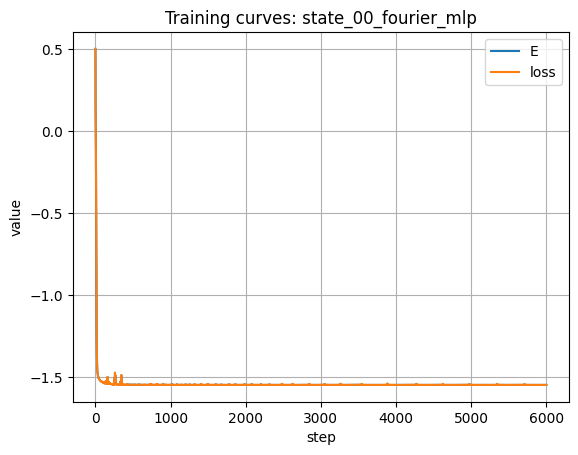

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/state_00_fourier_mlp_boundary_mass.png


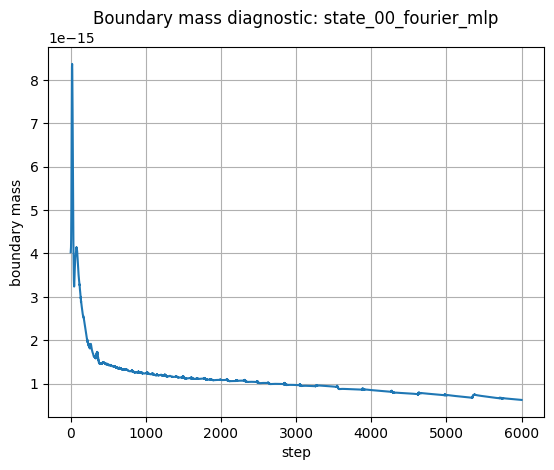

State 0: E=-1.5473886932, boundary_mass=6.23e-16
[state_01_fourier_mlp] step=    1/6000 E=41.60169639 loss=68.76828271 bm=4.24e-15 elapsed=0.0s
[state_01_fourier_mlp] step=  300/6000 E=0.91729573 loss=0.92724301 bm=6.53e-16 elapsed=1.6s
[state_01_fourier_mlp] step=  600/6000 E=0.90896300 loss=0.91523002 bm=4.82e-16 elapsed=3.2s
[state_01_fourier_mlp] step=  900/6000 E=0.90959954 loss=0.90966060 bm=2.15e-16 elapsed=4.7s
[state_01_fourier_mlp] step= 1200/6000 E=0.90556148 loss=0.90953017 bm=2.22e-16 elapsed=6.3s
[state_01_fourier_mlp] step= 1500/6000 E=0.90723069 loss=0.90723598 bm=1.41e-16 elapsed=8.2s
[state_01_fourier_mlp] step= 1800/6000 E=0.90308788 loss=0.90600067 bm=1.50e-16 elapsed=10.2s
[state_01_fourier_mlp] step= 2100/6000 E=0.90224041 loss=0.90224041 bm=1.45e-16 elapsed=11.8s
[state_01_fourier_mlp] step= 2400/6000 E=0.90241902 loss=0.90250755 bm=1.43e-16 elapsed=13.3s
[state_01_fourier_mlp] step= 2700/6000 E=0.90451682 loss=0.90465687 bm=1.71e-16 elapsed=14.9s
[state_01_fouri

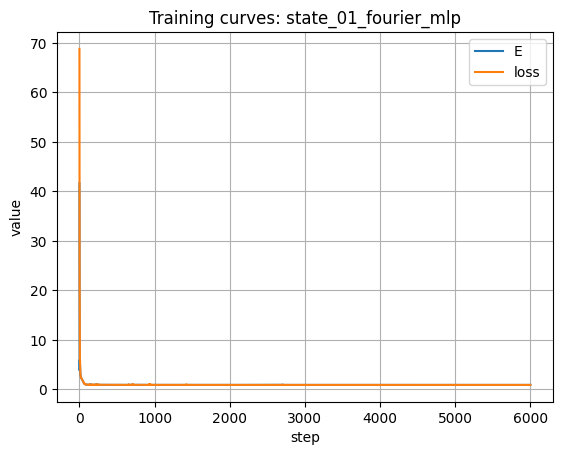

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/state_01_fourier_mlp_boundary_mass.png


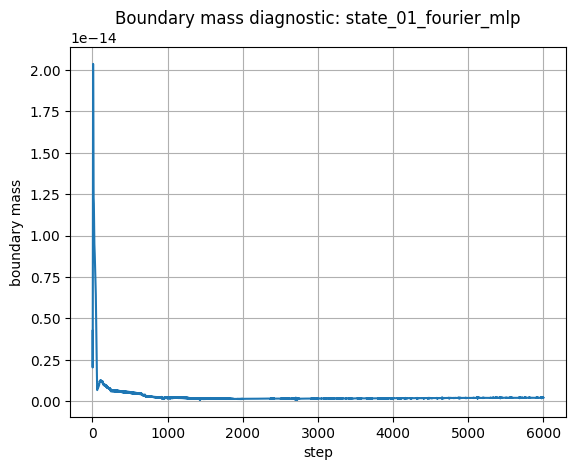

State 1: E=0.9020260393, boundary_mass=2.23e-16
[state_02_fourier_mlp] step=    1/6000 E=38.71433844 loss=91.59301657 bm=7.92e-15 elapsed=0.0s
[state_02_fourier_mlp] step=  300/6000 E=2.52335561 loss=2.52541203 bm=1.43e-15 elapsed=1.7s
[state_02_fourier_mlp] step=  600/6000 E=2.50495985 loss=2.51320402 bm=1.13e-15 elapsed=3.4s
[state_02_fourier_mlp] step=  900/6000 E=2.50322874 loss=2.50737836 bm=7.54e-16 elapsed=5.1s
[state_02_fourier_mlp] step= 1200/6000 E=2.50270624 loss=2.50273058 bm=6.04e-16 elapsed=6.8s
[state_02_fourier_mlp] step= 1500/6000 E=2.50105939 loss=2.50357312 bm=5.01e-16 elapsed=8.6s
[state_02_fourier_mlp] step= 1800/6000 E=2.50018464 loss=2.51176973 bm=4.34e-16 elapsed=10.9s
[state_02_fourier_mlp] step= 2100/6000 E=2.49878431 loss=2.50280402 bm=3.94e-16 elapsed=12.8s
[state_02_fourier_mlp] step= 2400/6000 E=2.49973384 loss=2.50095794 bm=3.33e-16 elapsed=14.4s
[state_02_fourier_mlp] step= 2700/6000 E=2.50487334 loss=2.50527409 bm=2.87e-16 elapsed=16.1s
[state_02_fourie

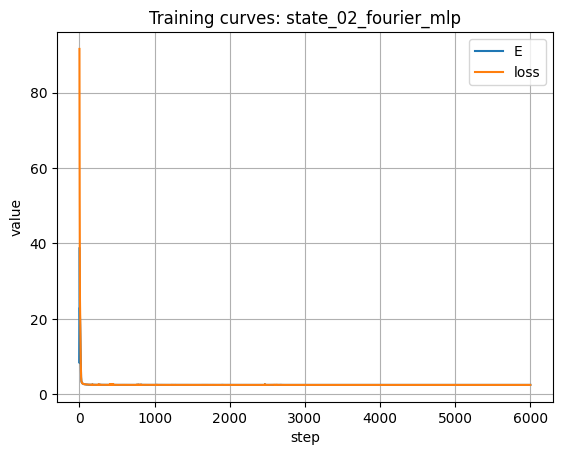

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/state_02_fourier_mlp_boundary_mass.png


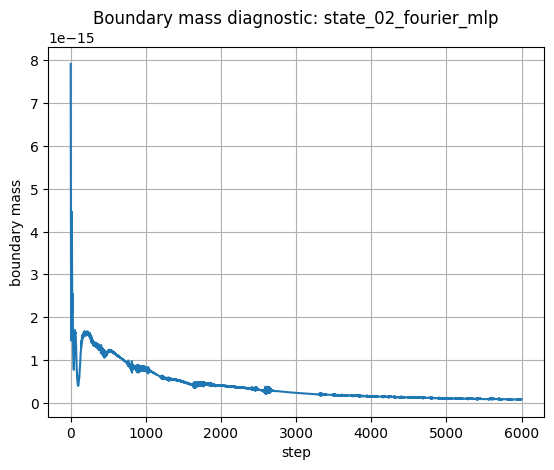

State 2: E=2.4970803406, boundary_mass=2.09e-17
[state_03_fourier_mlp] step=    1/6000 E=65.60798587 loss=89.34880297 bm=9.39e-15 elapsed=0.0s
[state_03_fourier_mlp] step=  300/6000 E=4.66191658 loss=4.67679060 bm=5.14e-15 elapsed=1.9s
[state_03_fourier_mlp] step=  600/6000 E=4.63965440 loss=4.64862578 bm=3.41e-15 elapsed=3.7s
[state_03_fourier_mlp] step=  900/6000 E=4.63667634 loss=4.64011747 bm=2.23e-15 elapsed=5.6s
[state_03_fourier_mlp] step= 1200/6000 E=4.64873167 loss=4.70688553 bm=1.44e-15 elapsed=7.7s
[state_03_fourier_mlp] step= 1500/6000 E=4.63807621 loss=4.65280882 bm=1.06e-15 elapsed=10.0s
[state_03_fourier_mlp] step= 1800/6000 E=4.63674280 loss=4.63807547 bm=9.14e-16 elapsed=11.9s
[state_03_fourier_mlp] step= 2100/6000 E=4.63688780 loss=4.63923492 bm=6.87e-16 elapsed=13.7s
[state_03_fourier_mlp] step= 2400/6000 E=4.63367299 loss=4.63659070 bm=5.01e-16 elapsed=15.5s
[state_03_fourier_mlp] step= 2700/6000 E=4.63430249 loss=4.63621900 bm=4.29e-16 elapsed=17.4s
[state_03_fouri

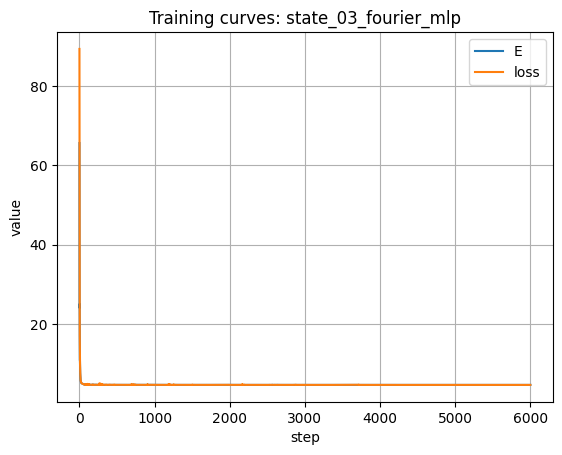

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/state_03_fourier_mlp_boundary_mass.png


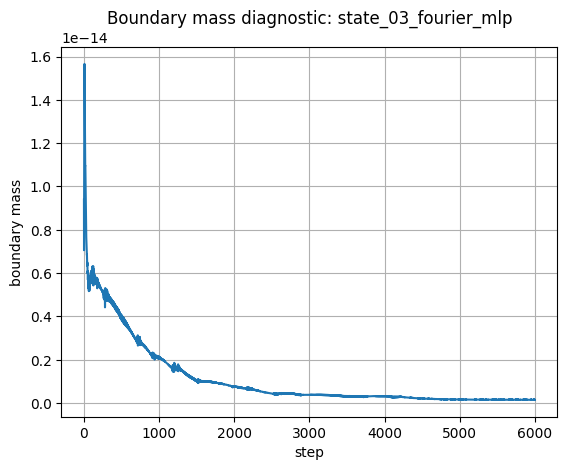

State 3: E=4.6309118355, boundary_mass=8.03e-17
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/nn_wavefunctions_fourier_mlp.png


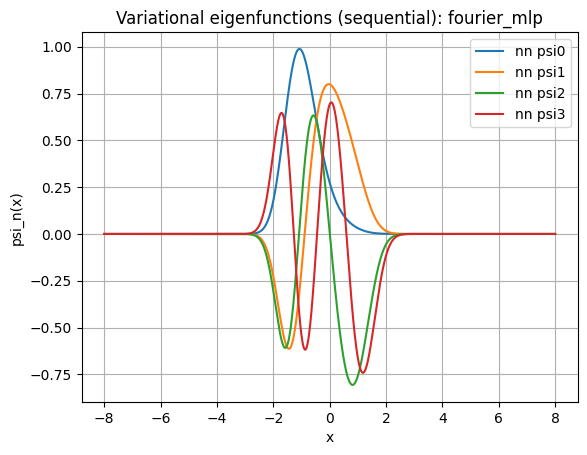

In [43]:
# Example: excited states for the assignment potential
pot = POTENTIALS["quartic_tilted"]
tag = pot.name

out = exp_dir(f"excited_{tag}")

L = pot.recommended_L
N = 4096
x_np, x, dx = make_grid(L, N, device=device, dtype=torch.get_default_dtype())
V_np = pot.fn_numpy(x_np)
Vx = pot.fn_torch(x)

# Reference spectrum (for later comparison)
k_ref = 6
evals_ref, psis_ref = fd_eigensolve_k(x_np, V_np, dx, k=k_ref)
np.savez(out / "data" / "reference_fd_k.npz", x=x_np, V=V_np, evals=evals_ref, psis=psis_ref)

# Variational excited states
train_cfg = TrainConfig(steps=6000, lr=2e-3, lam_ortho=80.0, print_every=300, ckpt_every=3000, use_lbfgs=True)

# Choose an ansatz (try: "plain_mlp", "fourier_mlp", "siren", "rbf")
model_spec = MODEL_SPECS["fourier_mlp"]
states = find_states_sequential(
    x_np=x_np, x=x, dx=dx, V_np=V_np, Vx=Vx,
    out_dir=out,
    model_spec=model_spec,
    K=4,
    train_cfg=train_cfg,
    model_kwargs={"hidden": 64, "depth": 3, "act": "tanh", "a": 0.35, "num_fourier": 24, "ff_scale": 2.5},
)


# Stage 14: Compare variational states to FD eigensolver

In [44]:
# ============================================
# Stage 14 — Quantitative comparison to eigensolver (matching by overlap)
# ============================================
# Purpose:
# - Build overlap matrix O_ij = |<psi_nn_i | psi_ref_j>|
# - Use Hungarian algorithm to match NN states to reference states
# - Produce a summary table: energies, deltas, overlaps
# - Plot matched wavefunctions overlays

def overlap_matrix(psiA: np.ndarray, psiB: np.ndarray, dx: float) -> np.ndarray:
    """
    psiA: (KA, N), psiB: (KB, N)
    Returns O: (KA, KB), O_ij = |∫ psiA_i psiB_j dx|
    """
    return np.abs(dx * (psiA @ psiB.T))

def match_by_max_overlap(psi_nn: np.ndarray, psi_ref: np.ndarray, dx: float):
    O = overlap_matrix(psi_nn, psi_ref, dx)
    # Hungarian assignment maximizes overlap => minimize cost = -O
    row_ind, col_ind = linear_sum_assignment(-O)
    return O, row_ind, col_ind

def compare_to_reference(
    x_np: np.ndarray,
    dx: float,
    evals_ref: np.ndarray,
    psis_ref: np.ndarray,
    states: List[dict],
    out_dir: Path,
    tag: str,
):
    fig_dir = out_dir / "figures"
    psi_nn = np.stack([s["psi"].detach().cpu().numpy() for s in states], axis=0)
    E_nn = np.array([s["E"] for s in states], dtype=np.float64)

    # Normalize again defensively
    psi_nn = psi_nn / np.sqrt(dx * np.sum(psi_nn**2, axis=1, keepdims=True))
    psi_ref = psis_ref[:psi_nn.shape[0]]
    E_ref = evals_ref[:psi_nn.shape[0]]

    O, nn_idx, ref_idx = match_by_max_overlap(psi_nn, psi_ref, dx)

    rows = []
    for i_nn, j_ref in zip(nn_idx, ref_idx):
        # Align sign for plotting (maximizes actual overlap)
        sgn = np.sign(dx * np.sum(psi_nn[i_nn] * psi_ref[j_ref])) or 1.0
        ov = dx * np.sum((sgn*psi_nn[i_nn]) * psi_ref[j_ref])
        rows.append({
            "nn_state": int(i_nn),
            "ref_state": int(j_ref),
            "E_nn": float(E_nn[i_nn]),
            "E_ref": float(E_ref[j_ref]),
            "delta": float(E_nn[i_nn] - E_ref[j_ref]),
            "abs_overlap": float(abs(ov)),
        })

    df = pd.DataFrame(rows).sort_values("ref_state")
    df.to_csv(out_dir / "data" / f"comparison_{tag}.csv", index=False)
    print(df)

    # Plot overlaps as heatmap-like image (no explicit color choice; matplotlib default)
    fig = plt.figure()
    plt.imshow(O, aspect="auto")
    plt.colorbar()
    plt.xlabel("ref state j")
    plt.ylabel("nn state i")
    plt.title(f"|Overlap| matrix: {tag}")
    save_fig_to(fig, fig_dir, f"overlap_matrix_{tag}.png")
    plt.show()

    # Plot energy spectrum comparison
    fig = plt.figure()
    plt.plot(np.arange(len(E_ref)), E_ref, marker="o", label="FD reference")
    plt.plot(np.arange(len(E_nn)), E_nn, marker="x", label="Variational (NN order)")
    plt.xlabel("state index")
    plt.ylabel("Energy")
    plt.title(f"Energy spectrum comparison: {tag}")
    plt.grid(True)
    plt.legend()
    save_fig_to(fig, fig_dir, f"spectrum_comparison_{tag}.png")
    plt.show()

    # Overlay matched wavefunctions
    for r in df.itertuples(index=False):
        i_nn = r.nn_state
        j_ref = r.ref_state
        sgn = np.sign(dx * np.sum(psi_nn[i_nn] * psi_ref[j_ref])) or 1.0

        fig = plt.figure()
        plt.plot(x_np, psi_ref[j_ref], label=f"ref psi{j_ref}")
        plt.plot(x_np, sgn*psi_nn[i_nn], label=f"nn psi{int(i_nn)} (matched)")
        plt.xlabel("x"); plt.ylabel("psi(x)")
        plt.title(f"Matched wavefunction: nn {i_nn} ↔ ref {j_ref} (|overlap|={r.abs_overlap:.4f})")
        plt.grid(True)
        plt.legend()
        save_fig_to(fig, fig_dir, f"match_nn{i_nn}_ref{j_ref}_{tag}.png")
        plt.show()

    return df, O


   nn_state  ref_state      E_nn     E_ref     delta  abs_overlap
0         0          0 -1.547389 -1.547381 -0.000008          1.0
1         1          1  0.902026  0.902052 -0.000025          1.0
2         2          2  2.497080  2.497144 -0.000064          1.0
3         3          3  4.630912  4.631078 -0.000167          1.0
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/overlap_matrix_quartic_tilted_fourier_mlp.png


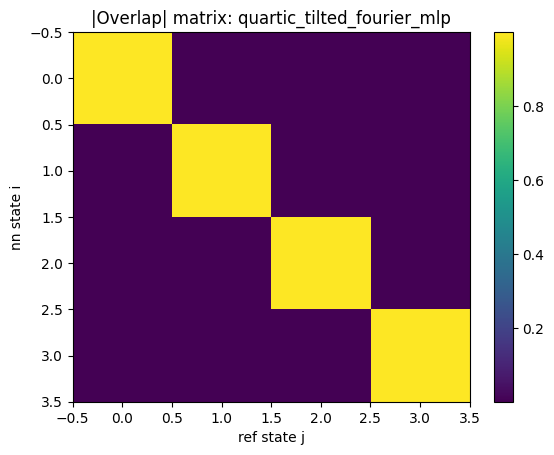

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/spectrum_comparison_quartic_tilted_fourier_mlp.png


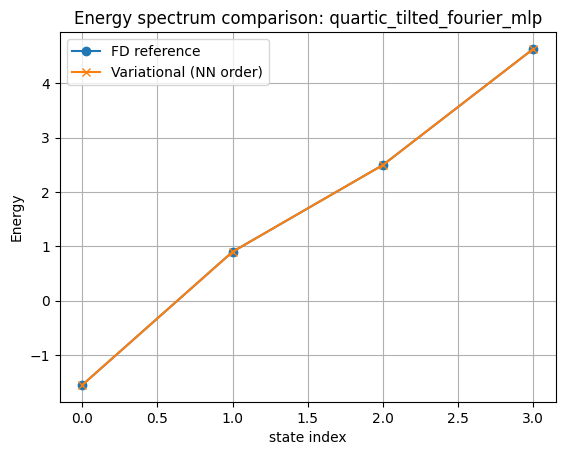

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/match_nn0_ref0_quartic_tilted_fourier_mlp.png


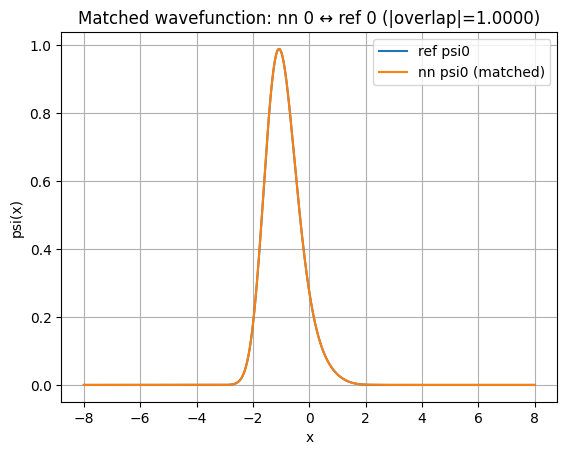

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/match_nn1_ref1_quartic_tilted_fourier_mlp.png


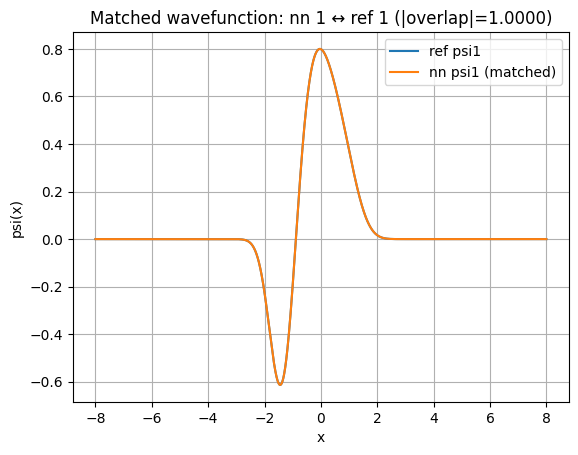

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/match_nn2_ref2_quartic_tilted_fourier_mlp.png


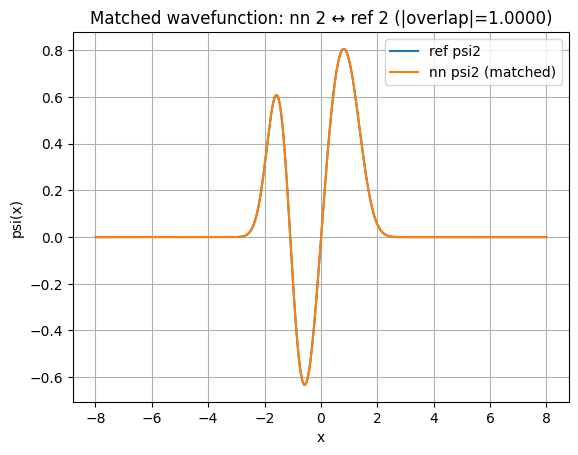

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/excited_quartic_tilted/figures/match_nn3_ref3_quartic_tilted_fourier_mlp.png


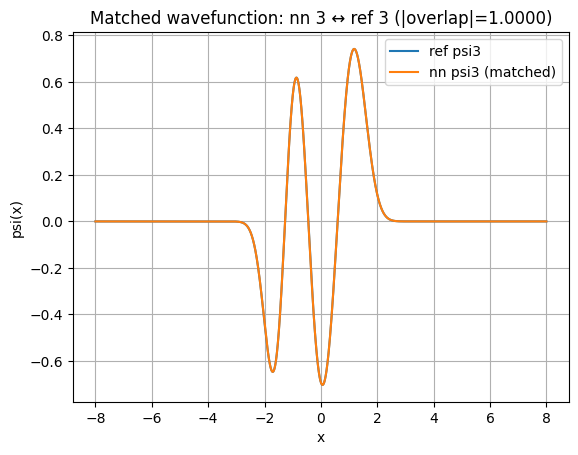

In [45]:
# Compare trained states to reference eigensolver
ref = np.load(out / "data" / "reference_fd_k.npz")
evals_ref = ref["evals"]
psis_ref = ref["psis"]
df_cmp, O = compare_to_reference(
    x_np=x_np, dx=dx,
    evals_ref=evals_ref, psis_ref=psis_ref,
    states=states,
    out_dir=out,
    tag=f"{pot.name}_{MODEL_SPECS['fourier_mlp'].name}",
)


# Stage 15: Hyperparameter tuning


In [46]:
# ============================================
# Stage 15 — Hyperparameter dependence (sweeps)
# ============================================
# Purpose:
# - Run multiple short trainings under different hyperparameters
# - Compare final E (and optionally E - E_ref) across configs
# - Save a sweep CSV + visualization plots
#
# Relation to overall problem:
# - Shows stability / sensitivity of the variational optimization. :contentReference[oaicite:14]{index=14}

def run_sweep(
    x_np: np.ndarray,
    x: torch.Tensor,
    dx: float,
    V_np: np.ndarray,
    Vx: torch.Tensor,
    out_dir: Path,
    pot_name: str,
    model_spec: ModelSpec,
    evals_ref: Optional[np.ndarray] = None,
    n_trials: int = 18,
    steps: int = 2500,
    seed0: int = 1234,
):
    sweep_dir = out_dir / "sweeps"
    (sweep_dir / "figures").mkdir(parents=True, exist_ok=True)
    (sweep_dir / "data").mkdir(parents=True, exist_ok=True)

    rng = np.random.default_rng(seed0)

    # Simple random sweep spaces (adjust as desired)
    lr_choices = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    hidden_choices = [32, 64, 128]
    depth_choices = [2, 3, 4]
    a_choices = [0.10, 0.25, 0.35, 0.60]
    act_choices = ["tanh", "silu", "gelu"]

    rows = []
    for t in range(n_trials):
        lr = float(rng.choice(lr_choices))
        hidden = int(rng.choice(hidden_choices))
        depth = int(rng.choice(depth_choices))
        a = float(rng.choice(a_choices))
        act = str(rng.choice(act_choices))

        # Per-trial output isolation
        trial_dir = sweep_dir / f"trial_{t:03d}"
        (trial_dir / "data").mkdir(parents=True, exist_ok=True)
        (trial_dir / "figures").mkdir(parents=True, exist_ok=True)
        (trial_dir / "checkpoints").mkdir(parents=True, exist_ok=True)
        (trial_dir / "logs").mkdir(parents=True, exist_ok=True)

        cfg = TrainConfig(steps=steps, lr=lr, lam_ortho=0.0, print_every=10_000, ckpt_every=10_000, use_lbfgs=False)

        # Ground-state run: allow positive amplitude bias if you want; keep consistent across sweep
        model = model_spec.factory(L=x_np[-1], positive=True, hidden=hidden, depth=depth, act=act, a=a)

        res = train_wavefunction(model, x, Vx, dx, trial_dir, cfg, orthonormal_to=None, tag="ground")

        Eref0 = float(evals_ref[0]) if evals_ref is not None else np.nan
        rows.append({
            "trial": t,
            "lr": lr,
            "hidden": hidden,
            "depth": depth,
            "act": act,
            "a": a,
            "E": res["E"],
            "E_ref0": Eref0,
            "E_minus_ref0": (res["E"] - Eref0) if evals_ref is not None else np.nan,
            "boundary_mass": res["boundary_mass"],
        })
        print(f"[sweep t={t}] E={res['E']:.8f} lr={lr} hidden={hidden} depth={depth} act={act} a={a}")

    df = pd.DataFrame(rows)
    df.to_csv(sweep_dir / "data" / "sweep_results.csv", index=False)
    print("Saved sweep CSV:", sweep_dir / "data" / "sweep_results.csv")

    # Visualizations (matplotlib defaults, no manual colors)
    fig = plt.figure()
    plt.scatter(np.log10(df["lr"]), df["E_minus_ref0"] if evals_ref is not None else df["E"])
    plt.xlabel("log10(lr)")
    plt.ylabel("E - E_ref0" if evals_ref is not None else "E")
    plt.title(f"Sweep: energy vs learning rate ({pot_name}, {model_spec.name})")
    plt.grid(True)
    save_fig_to(fig, sweep_dir / "figures", "sweep_energy_vs_lr.png")
    plt.show()

    fig = plt.figure()
    plt.scatter(df["hidden"], df["E_minus_ref0"] if evals_ref is not None else df["E"])
    plt.xlabel("hidden size")
    plt.ylabel("E - E_ref0" if evals_ref is not None else "E")
    plt.title(f"Sweep: energy vs hidden size ({pot_name}, {model_spec.name})")
    plt.grid(True)
    save_fig_to(fig, sweep_dir / "figures", "sweep_energy_vs_hidden.png")
    plt.show()

    fig = plt.figure()
    plt.scatter(df["depth"], df["E_minus_ref0"] if evals_ref is not None else df["E"])
    plt.xlabel("depth")
    plt.ylabel("E - E_ref0" if evals_ref is not None else "E")
    plt.title(f"Sweep: energy vs depth ({pot_name}, {model_spec.name})")
    plt.grid(True)
    save_fig_to(fig, sweep_dir / "figures", "sweep_energy_vs_depth.png")
    plt.show()

    # Best config
    key = "E_minus_ref0" if evals_ref is not None else "E"
    best = df.sort_values(key).iloc[0]
    print("Best trial (by", key, "):")
    print(best)

    return df


[ground] step=    1/2500 E=0.71316089 loss=0.71316089 bm=1.59e-11 elapsed=0.0s
[sweep t=0] E=-1.54568223 lr=0.01 hidden=128 depth=4 act=tanh a=0.25
[ground] step=    1/2500 E=8.85114382 loss=8.85114382 bm=4.18e-06 elapsed=0.0s
[sweep t=1] E=-1.54738305 lr=0.01 hidden=32 depth=2 act=tanh a=0.1
[ground] step=    1/2500 E=9.29552600 loss=9.29552600 bm=4.87e-06 elapsed=0.0s
[sweep t=2] E=-1.54733812 lr=0.001 hidden=32 depth=4 act=gelu a=0.1
[ground] step=    1/2500 E=-0.03652594 loss=-0.03652594 bm=4.06e-24 elapsed=0.0s
[sweep t=3] E=-1.54737623 lr=0.0003 hidden=128 depth=4 act=tanh a=0.6
[ground] step=    1/2500 E=0.27638333 loss=0.27638333 bm=5.54e-15 elapsed=0.0s
[sweep t=4] E=-1.54738004 lr=0.001 hidden=64 depth=2 act=gelu a=0.35
[ground] step=    1/2500 E=0.22521794 loss=0.22521794 bm=4.49e-15 elapsed=0.0s
[sweep t=5] E=-1.54739416 lr=0.01 hidden=64 depth=4 act=gelu a=0.35
[ground] step=    1/2500 E=0.19548956 loss=0.19548956 bm=8.48e-15 elapsed=0.0s
[sweep t=6] E=-1.54739081 lr=0.01 

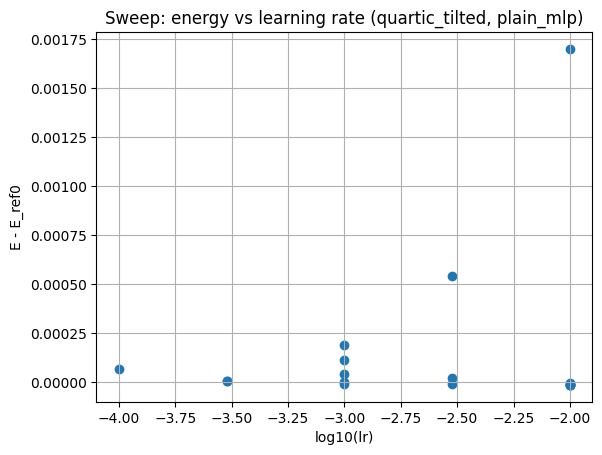

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/sweep_quartic_tilted_plain/sweeps/figures/sweep_energy_vs_hidden.png


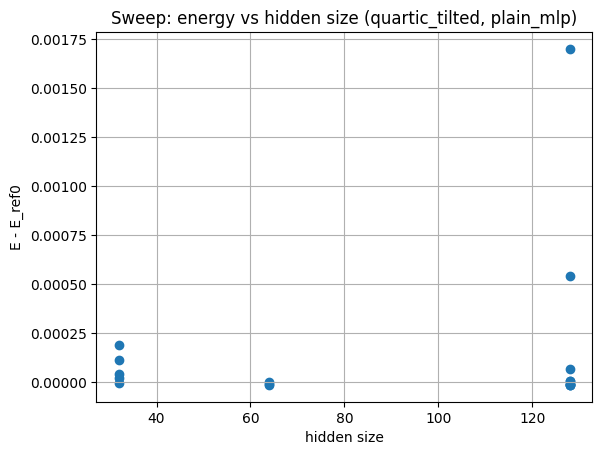

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/sweep_quartic_tilted_plain/sweeps/figures/sweep_energy_vs_depth.png


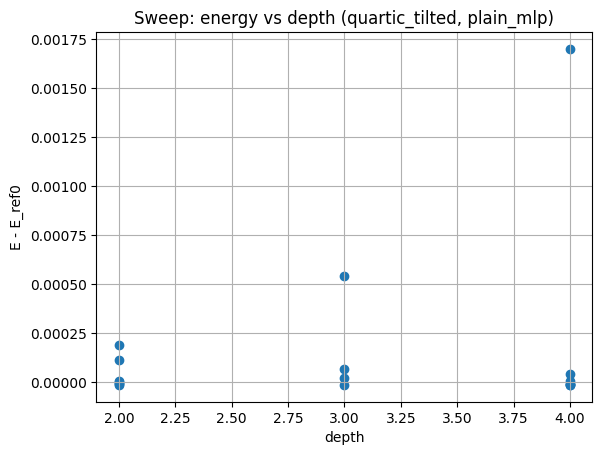

Best trial (by E_minus_ref0 ):
trial                  17
lr                   0.01
hidden                128
depth                   4
act                  gelu
a                    0.25
E               -1.547395
E_ref0          -1.547381
E_minus_ref0    -0.000014
boundary_mass         0.0
Name: 17, dtype: object


In [47]:
# Example hyperparameter sweep on a given potential + model
pot = POTENTIALS["quartic_tilted"]
out = exp_dir(f"sweep_{pot.name}_plain")

L = pot.recommended_L
N = 4096
x_np, x, dx = make_grid(L, N, device=device, dtype=torch.get_default_dtype())
V_np = pot.fn_numpy(x_np)
Vx = pot.fn_torch(x)

evals_ref, psis_ref = fd_eigensolve_k(x_np, V_np, dx, k=6)
model_spec = MODEL_SPECS["plain_mlp"]

df_sweep = run_sweep(
    x_np=x_np, x=x, dx=dx, V_np=V_np, Vx=Vx,
    out_dir=out,
    pot_name=pot.name,
    model_spec=model_spec,
    evals_ref=evals_ref,
    n_trials=18,
    steps=2500
)


# Stage 16: Multiple potentials

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/potential_quartic_tilted.png


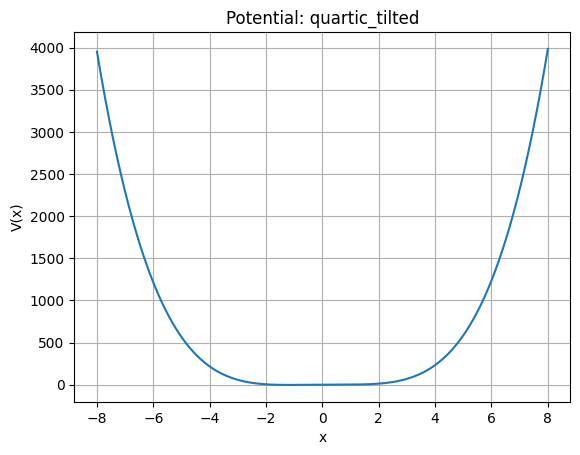

[state_00_plain_mlp] step=    1/4500 E=0.00654709 loss=0.00654709 bm=4.29e-15 elapsed=0.0s
[state_00_plain_mlp] step=  400/4500 E=-1.54712395 loss=-1.54712395 bm=4.89e-18 elapsed=2.0s
[state_00_plain_mlp] step=  800/4500 E=-1.54721449 loss=-1.54721449 bm=9.74e-19 elapsed=4.3s
[state_00_plain_mlp] step= 1200/4500 E=-1.54727596 loss=-1.54727596 bm=3.70e-19 elapsed=6.5s
[state_00_plain_mlp] step= 1600/4500 E=-1.54730407 loss=-1.54730407 bm=2.00e-19 elapsed=8.4s
[state_00_plain_mlp] step= 2000/4500 E=-1.54732738 loss=-1.54732738 bm=1.23e-19 elapsed=10.3s
[state_00_plain_mlp] step= 2400/4500 E=-1.54734370 loss=-1.54734370 bm=8.72e-20 elapsed=12.3s
[state_00_plain_mlp] step= 2800/4500 E=-1.54735931 loss=-1.54735931 bm=5.32e-20 elapsed=14.2s
[state_00_plain_mlp] step= 3200/4500 E=-1.54736913 loss=-1.54736913 bm=4.75e-20 elapsed=16.3s
[state_00_plain_mlp] step= 3600/4500 E=-1.54737677 loss=-1.54737677 bm=4.19e-20 elapsed=18.7s
[state_00_plain_mlp] step= 4000/4500 E=-1.54738451 loss=-1.54738451

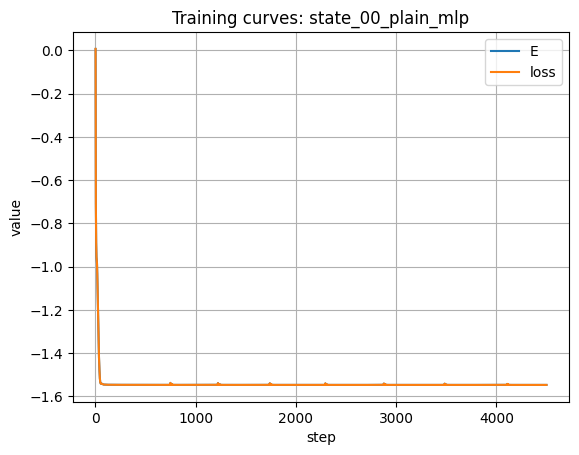

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/state_00_plain_mlp_boundary_mass.png


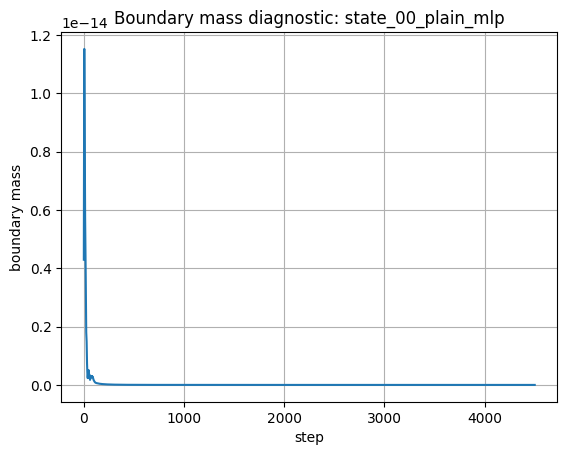

State 0: E=-1.5473943301, boundary_mass=1.46e-21
[state_01_plain_mlp] step=    1/4500 E=-0.67105769 loss=57.26094206 bm=9.18e-16 elapsed=0.0s
[state_01_plain_mlp] step=  400/4500 E=0.91767491 loss=0.92743491 bm=6.25e-16 elapsed=2.1s
[state_01_plain_mlp] step=  800/4500 E=0.90960864 loss=0.92501166 bm=4.72e-16 elapsed=4.1s
[state_01_plain_mlp] step= 1200/4500 E=0.90487825 loss=0.91864006 bm=4.19e-16 elapsed=6.8s
[state_01_plain_mlp] step= 1600/4500 E=0.90314319 loss=0.92950940 bm=2.48e-16 elapsed=9.0s
[state_01_plain_mlp] step= 2000/4500 E=0.90325614 loss=0.94615953 bm=1.34e-16 elapsed=11.1s
[state_01_plain_mlp] step= 2400/4500 E=0.90241034 loss=0.90332749 bm=1.69e-16 elapsed=13.1s
[state_01_plain_mlp] step= 2800/4500 E=0.90232334 loss=0.90350050 bm=1.37e-16 elapsed=15.2s
[state_01_plain_mlp] step= 3200/4500 E=0.90228514 loss=0.90306417 bm=1.16e-16 elapsed=17.2s
[state_01_plain_mlp] step= 3600/4500 E=0.90223313 loss=0.90417019 bm=1.02e-16 elapsed=19.9s
[state_01_plain_mlp] step= 4000/45

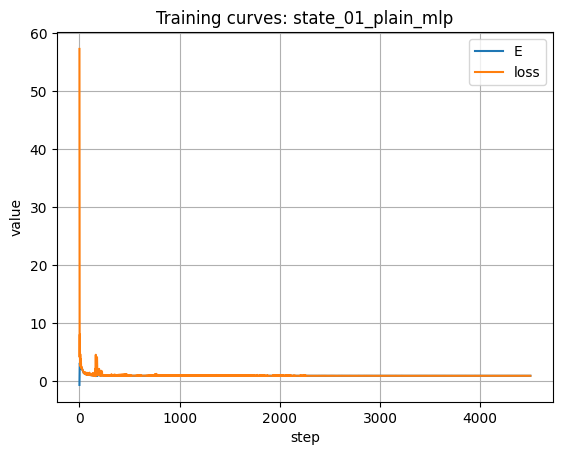

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/state_01_plain_mlp_boundary_mass.png


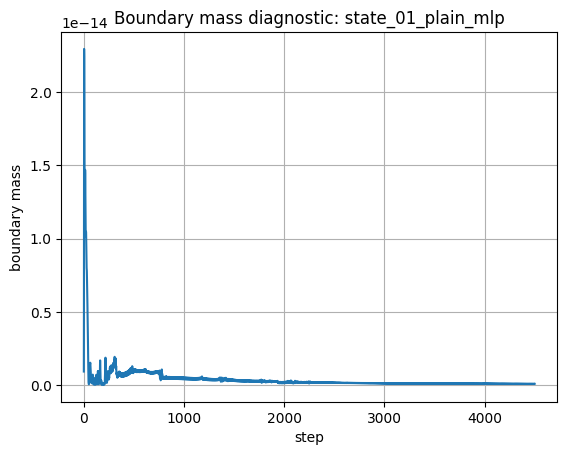

State 1: E=0.9020254751, boundary_mass=1.22e-18
[state_02_plain_mlp] step=    1/4500 E=1.04178821 loss=65.60171019 bm=5.74e-15 elapsed=0.0s
[state_02_plain_mlp] step=  400/4500 E=3.02075878 loss=3.19969089 bm=9.65e-15 elapsed=2.2s
[state_02_plain_mlp] step=  800/4500 E=2.68490995 loss=2.76685953 bm=3.39e-16 elapsed=5.0s
[state_02_plain_mlp] step= 1200/4500 E=2.56102198 loss=2.66075743 bm=1.42e-15 elapsed=7.4s
[state_02_plain_mlp] step= 1600/4500 E=2.51238310 loss=2.55297455 bm=4.33e-15 elapsed=9.7s
[state_02_plain_mlp] step= 2000/4500 E=2.50348196 loss=2.52204558 bm=3.70e-15 elapsed=11.9s
[state_02_plain_mlp] step= 2400/4500 E=2.50152116 loss=2.51124875 bm=2.84e-15 elapsed=14.1s
[state_02_plain_mlp] step= 2800/4500 E=2.49982842 loss=2.51611068 bm=2.03e-15 elapsed=16.6s
[state_02_plain_mlp] step= 3200/4500 E=2.49874396 loss=2.50986752 bm=1.45e-15 elapsed=19.3s
[state_02_plain_mlp] step= 3600/4500 E=2.49797692 loss=2.52520506 bm=8.93e-16 elapsed=21.5s
[state_02_plain_mlp] step= 4000/4500

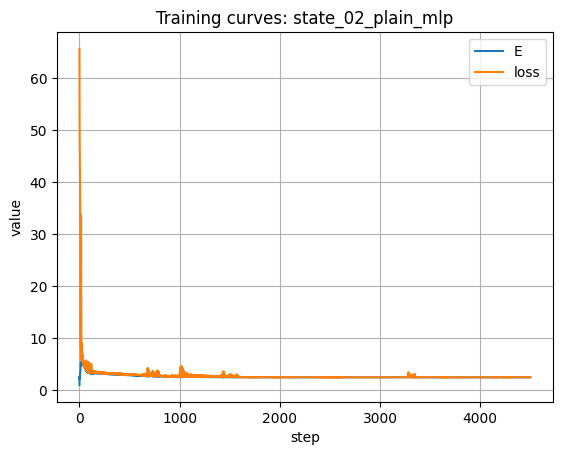

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/state_02_plain_mlp_boundary_mass.png


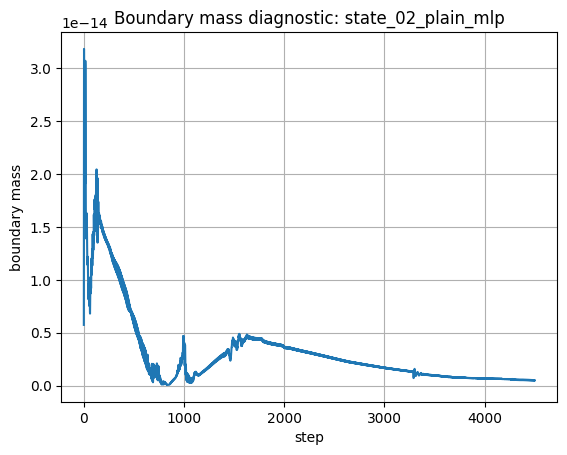

State 2: E=2.4970880992, boundary_mass=6.52e-18
[state_03_plain_mlp] step=    1/4500 E=0.52935450 loss=69.54853014 bm=5.99e-14 elapsed=0.0s
[state_03_plain_mlp] step=  400/4500 E=4.91331205 loss=5.91626232 bm=6.29e-16 elapsed=2.4s
[state_03_plain_mlp] step=  800/4500 E=4.78853113 loss=5.04020524 bm=3.37e-15 elapsed=4.8s
[state_03_plain_mlp] step= 1200/4500 E=4.70659444 loss=4.73627930 bm=1.39e-14 elapsed=7.2s
[state_03_plain_mlp] step= 1600/4500 E=4.66853369 loss=4.70247688 bm=9.82e-15 elapsed=9.5s
[state_03_plain_mlp] step= 2000/4500 E=4.65429559 loss=4.69180398 bm=5.70e-15 elapsed=12.5s
[state_03_plain_mlp] step= 2400/4500 E=4.64226520 loss=4.67438893 bm=1.54e-15 elapsed=15.1s
[state_03_plain_mlp] step= 2800/4500 E=4.64315649 loss=4.67331509 bm=6.45e-16 elapsed=17.5s
[state_03_plain_mlp] step= 3200/4500 E=4.63371828 loss=4.66131090 bm=1.41e-17 elapsed=19.9s
[state_03_plain_mlp] step= 3600/4500 E=4.65167829 loss=4.78765816 bm=1.11e-16 elapsed=22.2s
[state_03_plain_mlp] step= 4000/4500

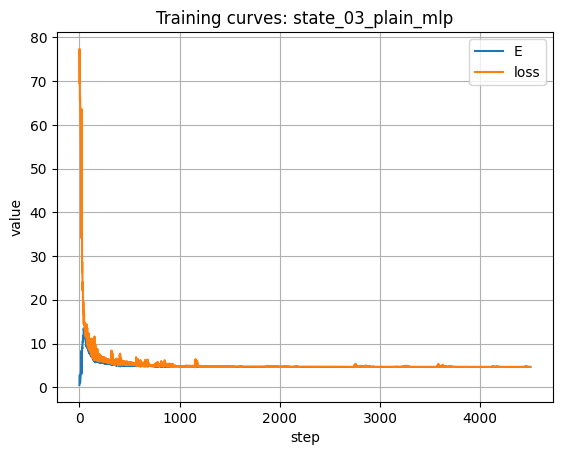

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/state_03_plain_mlp_boundary_mass.png


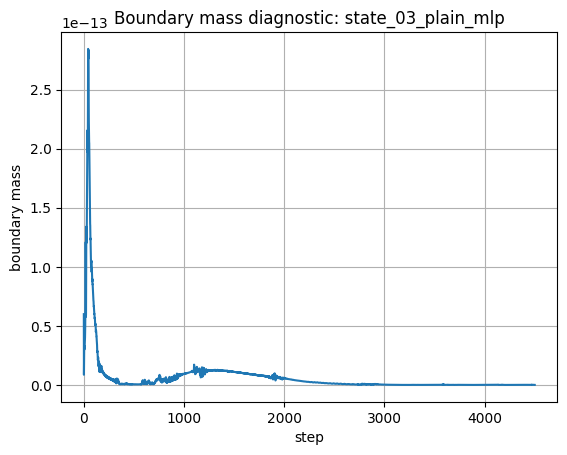

State 3: E=4.6309364362, boundary_mass=1.21e-16
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/nn_wavefunctions_plain_mlp.png


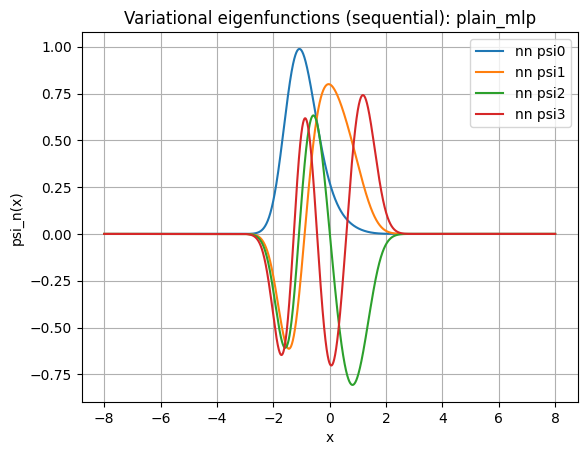

   nn_state  ref_state      E_nn     E_ref     delta  abs_overlap
0         0          0 -1.547394 -1.547381 -0.000014          1.0
1         1          1  0.902025  0.902052 -0.000026          1.0
2         2          2  2.497088  2.497144 -0.000056          1.0
3         3          3  4.630936  4.631078 -0.000142          1.0
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/overlap_matrix_quartic_tilted_plain_mlp.png


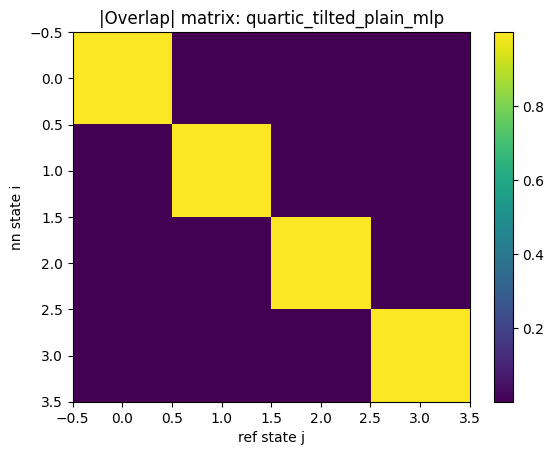

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/spectrum_comparison_quartic_tilted_plain_mlp.png


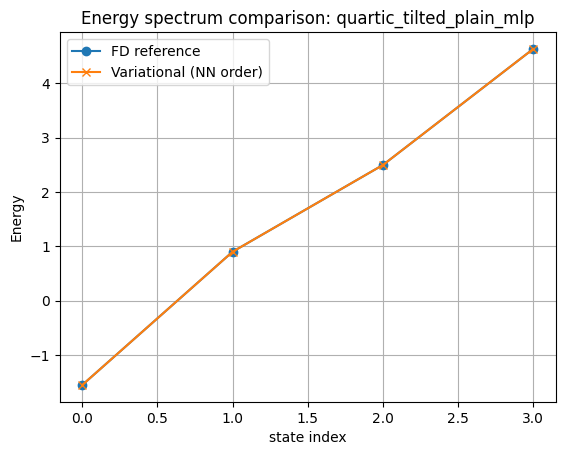

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/match_nn0_ref0_quartic_tilted_plain_mlp.png


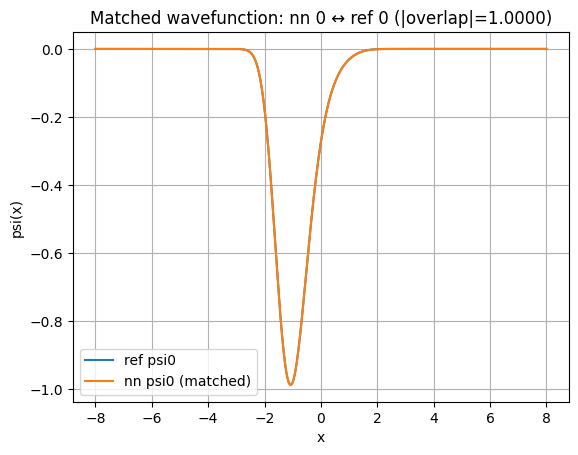

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/match_nn1_ref1_quartic_tilted_plain_mlp.png


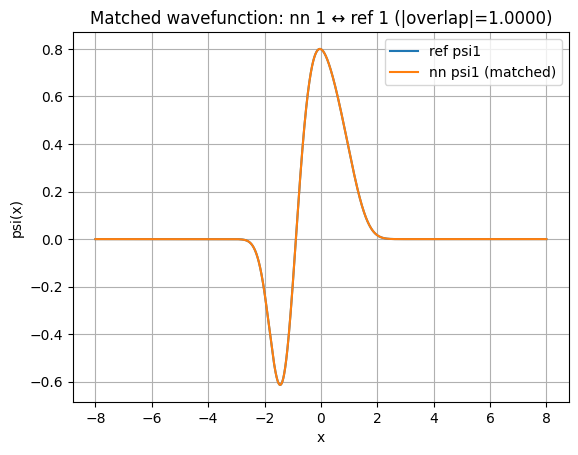

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/match_nn2_ref2_quartic_tilted_plain_mlp.png


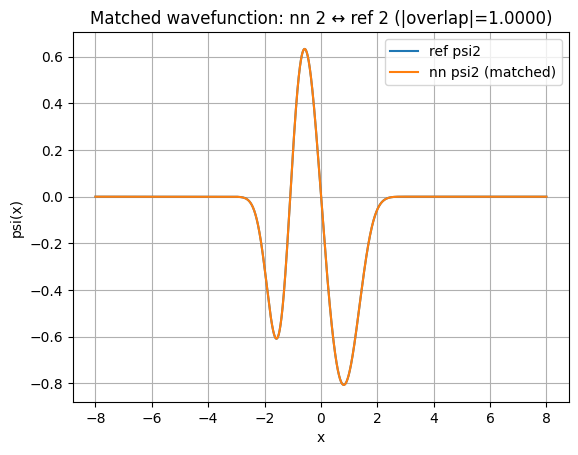

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_tilted_plain_mlp/figures/match_nn3_ref3_quartic_tilted_plain_mlp.png


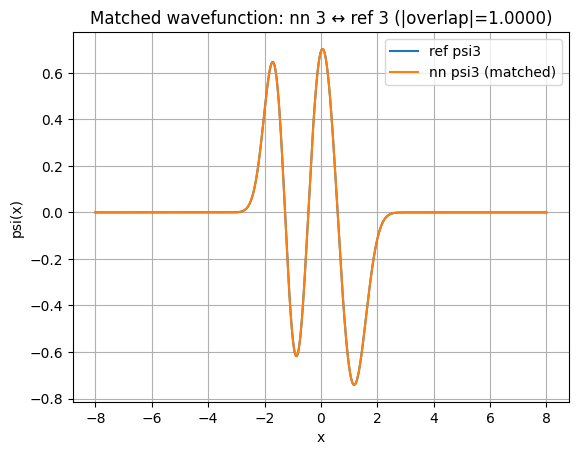

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/potential_harmonic.png


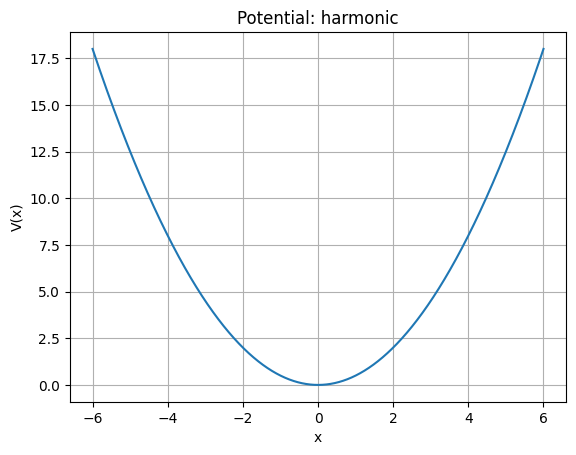

[state_00_plain_mlp] step=    1/4500 E=0.51552054 loss=0.51552054 bm=1.23e-09 elapsed=0.0s
[state_00_plain_mlp] step=  400/4500 E=0.50000156 loss=0.50000156 bm=5.64e-11 elapsed=2.0s
[state_00_plain_mlp] step=  800/4500 E=0.49999964 loss=0.49999964 bm=4.01e-11 elapsed=3.8s
[state_00_plain_mlp] step= 1200/4500 E=0.49999922 loss=0.49999922 bm=3.35e-11 elapsed=5.7s
[state_00_plain_mlp] step= 1600/4500 E=0.49999911 loss=0.49999911 bm=3.03e-11 elapsed=7.7s
[state_00_plain_mlp] step= 2000/4500 E=0.49999953 loss=0.49999953 bm=2.83e-11 elapsed=9.8s
[state_00_plain_mlp] step= 2400/4500 E=0.49999905 loss=0.49999905 bm=2.76e-11 elapsed=12.2s
[state_00_plain_mlp] step= 2800/4500 E=0.49999906 loss=0.49999906 bm=2.68e-11 elapsed=14.1s
[state_00_plain_mlp] step= 3200/4500 E=0.49999901 loss=0.49999901 bm=2.63e-11 elapsed=16.0s
[state_00_plain_mlp] step= 3600/4500 E=0.49999902 loss=0.49999902 bm=2.55e-11 elapsed=18.0s
[state_00_plain_mlp] step= 4000/4500 E=0.49999898 loss=0.49999898 bm=2.50e-11 elapsed=

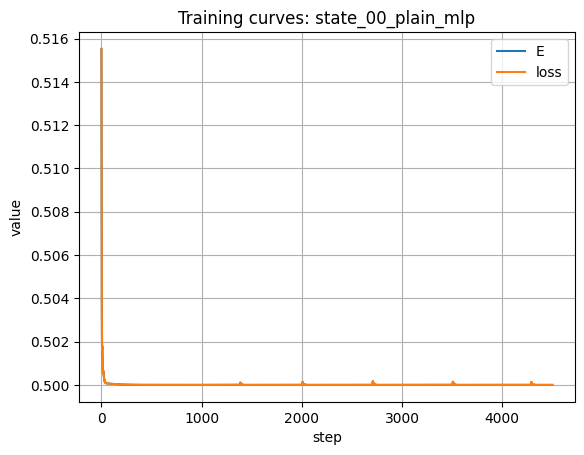

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/state_00_plain_mlp_boundary_mass.png


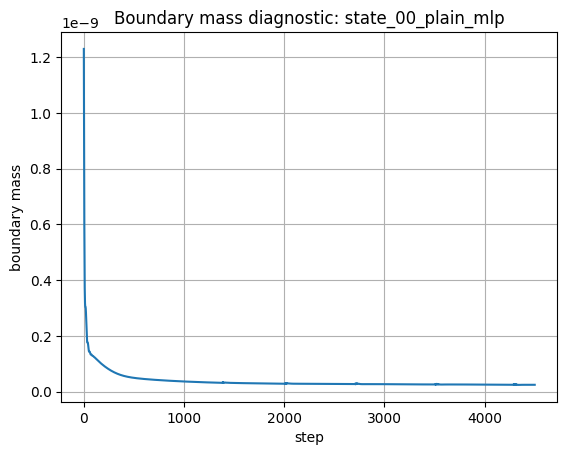

State 0: E=0.4999989745, boundary_mass=2.45e-11
[state_01_plain_mlp] step=    1/4500 E=0.65825138 loss=68.16876075 bm=6.68e-10 elapsed=0.0s
[state_01_plain_mlp] step=  400/4500 E=1.50766216 loss=1.53562299 bm=5.35e-09 elapsed=2.5s
[state_01_plain_mlp] step=  800/4500 E=1.50241339 loss=1.53480565 bm=6.15e-09 elapsed=4.5s
[state_01_plain_mlp] step= 1200/4500 E=1.50175912 loss=1.50529525 bm=6.38e-09 elapsed=6.6s
[state_01_plain_mlp] step= 1600/4500 E=1.50152567 loss=1.50331756 bm=6.25e-09 elapsed=8.6s
[state_01_plain_mlp] step= 2000/4500 E=1.50133777 loss=1.50382995 bm=6.05e-09 elapsed=10.6s
[state_01_plain_mlp] step= 2400/4500 E=1.50119494 loss=1.50285505 bm=5.87e-09 elapsed=12.9s
[state_01_plain_mlp] step= 2800/4500 E=1.50102779 loss=1.50248663 bm=5.67e-09 elapsed=15.5s
[state_01_plain_mlp] step= 3200/4500 E=1.50076623 loss=1.50371223 bm=5.23e-09 elapsed=17.5s
[state_01_plain_mlp] step= 3600/4500 E=1.50042375 loss=1.50303069 bm=4.26e-09 elapsed=19.5s
[state_01_plain_mlp] step= 4000/4500

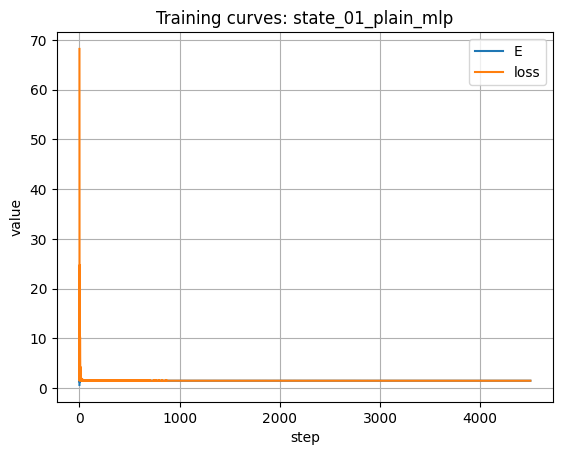

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/state_01_plain_mlp_boundary_mass.png


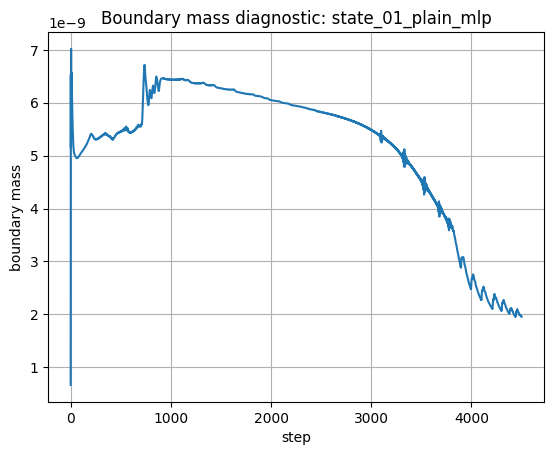

State 1: E=1.5000165447, boundary_mass=1.96e-09
[state_02_plain_mlp] step=    1/4500 E=1.08908447 loss=78.10105388 bm=8.02e-09 elapsed=0.0s
[state_02_plain_mlp] step=  400/4500 E=2.58602913 loss=3.17890137 bm=8.88e-09 elapsed=3.0s
[state_02_plain_mlp] step=  800/4500 E=2.54730684 loss=2.66637206 bm=1.25e-08 elapsed=5.4s
[state_02_plain_mlp] step= 1200/4500 E=2.53036506 loss=2.57857074 bm=1.50e-08 elapsed=7.6s
[state_02_plain_mlp] step= 1600/4500 E=2.52142485 loss=2.56439195 bm=1.66e-08 elapsed=9.8s
[state_02_plain_mlp] step= 2000/4500 E=2.51581804 loss=2.56143252 bm=1.78e-08 elapsed=12.0s
[state_02_plain_mlp] step= 2400/4500 E=2.51124803 loss=2.58993710 bm=1.85e-08 elapsed=14.4s
[state_02_plain_mlp] step= 2800/4500 E=2.50897597 loss=2.55094717 bm=1.95e-08 elapsed=17.1s
[state_02_plain_mlp] step= 3200/4500 E=2.50706930 loss=2.55016541 bm=2.02e-08 elapsed=19.3s
[state_02_plain_mlp] step= 3600/4500 E=2.50610056 loss=2.54362708 bm=2.06e-08 elapsed=21.5s
[state_02_plain_mlp] step= 4000/4500

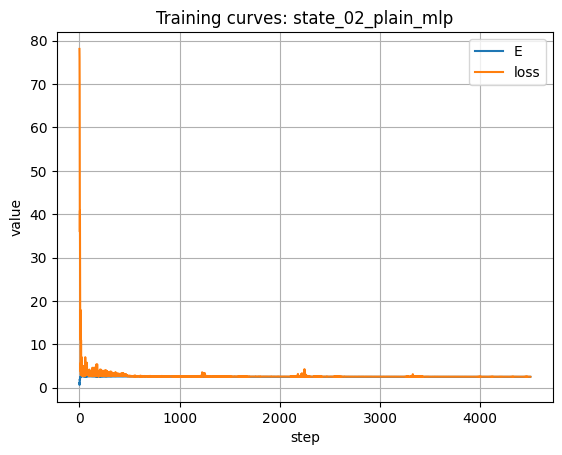

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/state_02_plain_mlp_boundary_mass.png


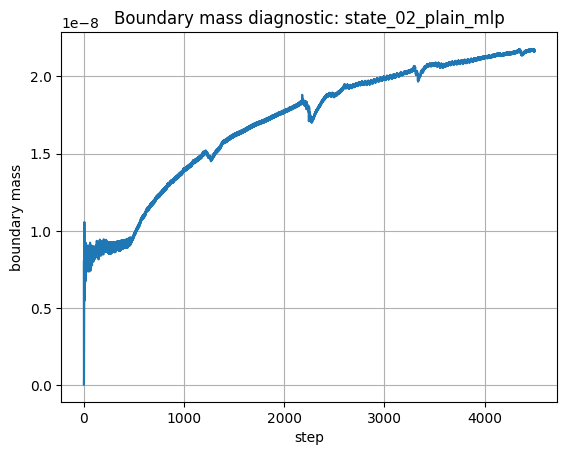

State 2: E=2.5000742525, boundary_mass=3.30e-08
[state_03_plain_mlp] step=    1/4500 E=0.81203039 loss=80.56961037 bm=4.67e-09 elapsed=0.0s
[state_03_plain_mlp] step=  400/4500 E=3.67666148 loss=3.99086799 bm=7.24e-08 elapsed=2.4s
[state_03_plain_mlp] step=  800/4500 E=3.62440256 loss=3.83140518 bm=7.59e-08 elapsed=4.8s
[state_03_plain_mlp] step= 1200/4500 E=3.58813596 loss=3.77518998 bm=8.25e-08 elapsed=7.2s
[state_03_plain_mlp] step= 1600/4500 E=3.56615562 loss=3.78419393 bm=8.32e-08 elapsed=9.5s
[state_03_plain_mlp] step= 2000/4500 E=3.55009120 loss=3.69147459 bm=8.81e-08 elapsed=12.7s
[state_03_plain_mlp] step= 2400/4500 E=3.53491201 loss=3.64802106 bm=9.16e-08 elapsed=15.1s
[state_03_plain_mlp] step= 2800/4500 E=3.53208982 loss=3.63044400 bm=8.72e-08 elapsed=17.4s
[state_03_plain_mlp] step= 3200/4500 E=3.52058870 loss=3.61026464 bm=1.01e-07 elapsed=19.8s
[state_03_plain_mlp] step= 3600/4500 E=3.52010227 loss=3.56904115 bm=1.04e-07 elapsed=22.1s
[state_03_plain_mlp] step= 4000/4500

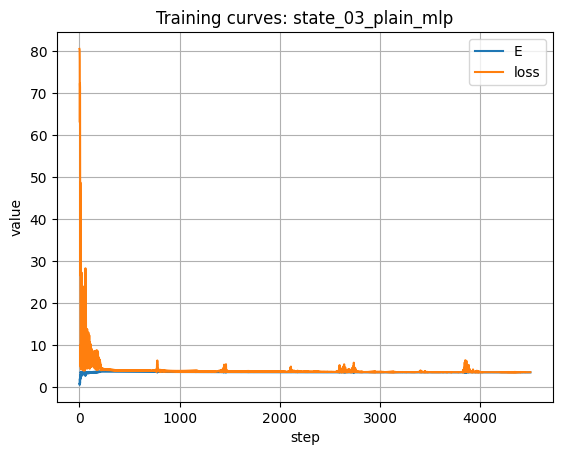

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/state_03_plain_mlp_boundary_mass.png


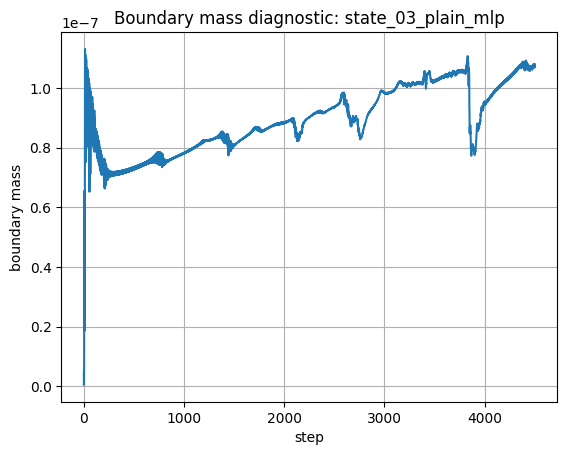

State 3: E=3.5000638814, boundary_mass=2.37e-07
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/nn_wavefunctions_plain_mlp.png


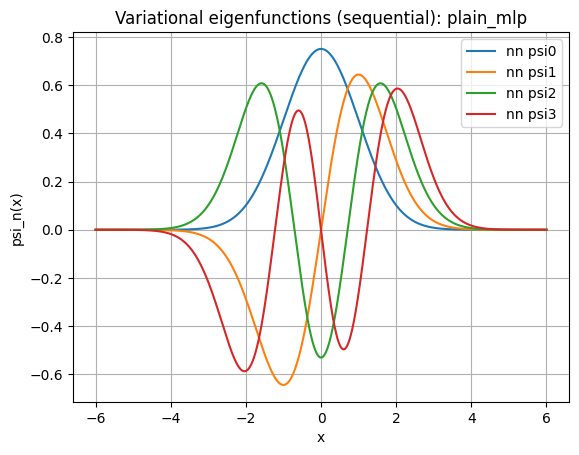

   nn_state  ref_state      E_nn     E_ref         delta  abs_overlap
0         0          0  0.499999  0.500000 -7.571259e-07     1.000000
1         1          1  1.500017  1.499999  1.788650e-05     0.999999
2         2          2  2.500074  2.499997  7.774108e-05     0.999993
3         3          3  3.500064  3.499993  7.059012e-05     0.999997
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/overlap_matrix_harmonic_plain_mlp.png


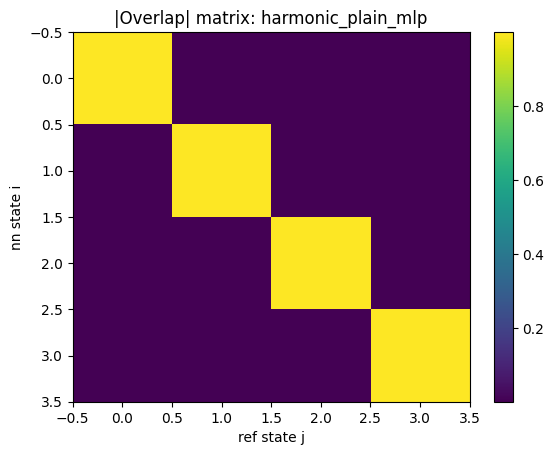

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/spectrum_comparison_harmonic_plain_mlp.png


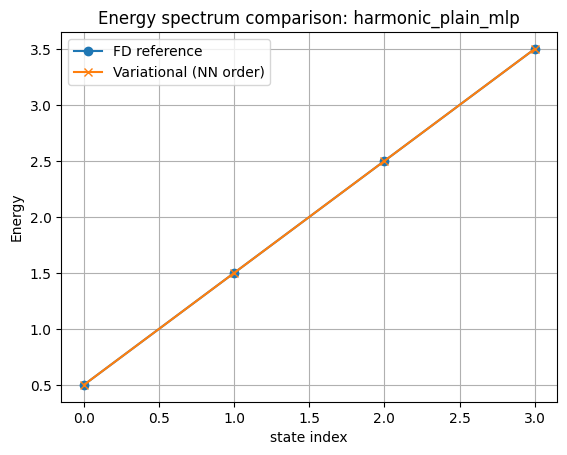

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/match_nn0_ref0_harmonic_plain_mlp.png


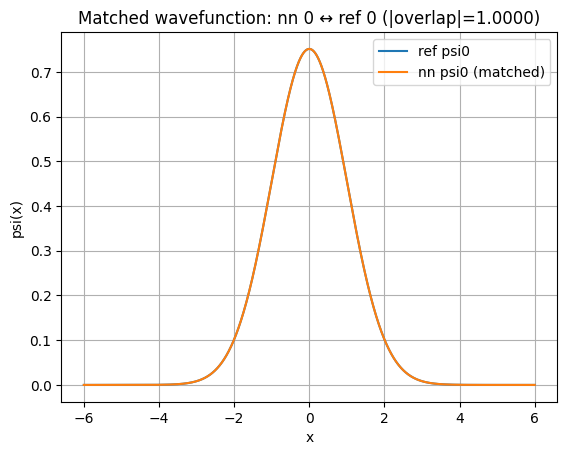

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/match_nn1_ref1_harmonic_plain_mlp.png


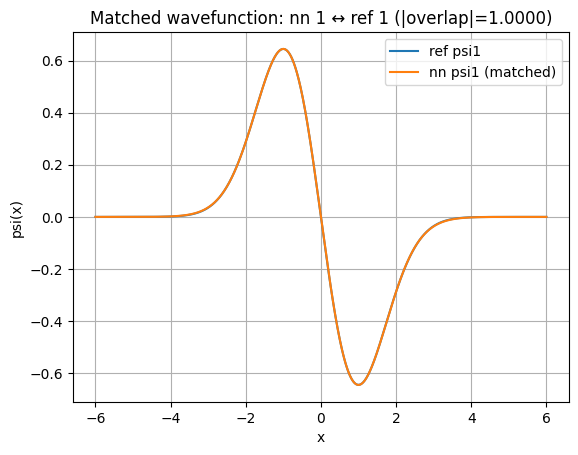

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/match_nn2_ref2_harmonic_plain_mlp.png


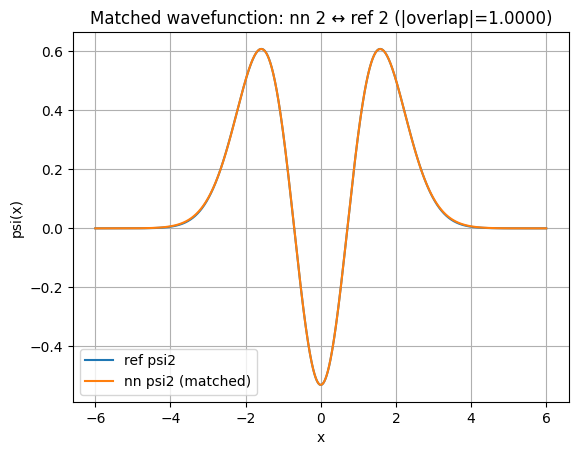

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_harmonic_plain_mlp/figures/match_nn3_ref3_harmonic_plain_mlp.png


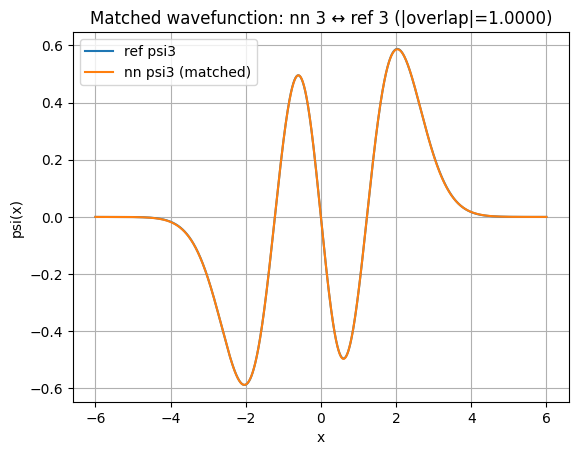

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/potential_double_well_a2.png


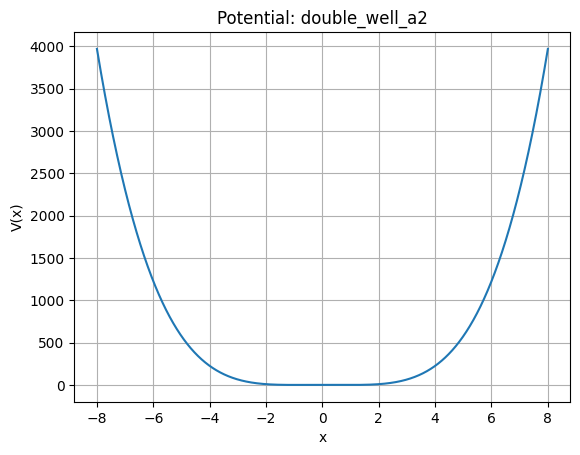

[state_00_plain_mlp] step=    1/4500 E=0.21288918 loss=0.21288918 bm=3.83e-15 elapsed=0.0s
[state_00_plain_mlp] step=  400/4500 E=-0.13037000 loss=-0.13037000 bm=1.56e-19 elapsed=2.4s
[state_00_plain_mlp] step=  800/4500 E=-0.13039999 loss=-0.13039999 bm=4.93e-20 elapsed=4.3s
[state_00_plain_mlp] step= 1200/4500 E=-0.13041124 loss=-0.13041124 bm=2.22e-20 elapsed=6.2s
[state_00_plain_mlp] step= 1600/4500 E=-0.13041669 loss=-0.13041669 bm=1.21e-20 elapsed=8.0s
[state_00_plain_mlp] step= 2000/4500 E=-0.13041942 loss=-0.13041942 bm=7.56e-21 elapsed=9.9s
[state_00_plain_mlp] step= 2400/4500 E=-0.13042098 loss=-0.13042098 bm=5.25e-21 elapsed=11.9s
[state_00_plain_mlp] step= 2800/4500 E=-0.13042182 loss=-0.13042182 bm=3.95e-21 elapsed=14.4s
[state_00_plain_mlp] step= 3200/4500 E=-0.13042254 loss=-0.13042254 bm=2.99e-21 elapsed=16.4s
[state_00_plain_mlp] step= 3600/4500 E=-0.13042293 loss=-0.13042293 bm=2.44e-21 elapsed=18.4s
[state_00_plain_mlp] step= 4000/4500 E=-0.13042316 loss=-0.13042316 

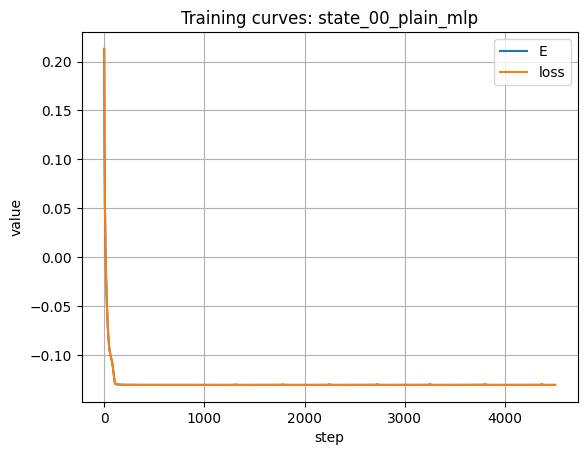

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/state_00_plain_mlp_boundary_mass.png


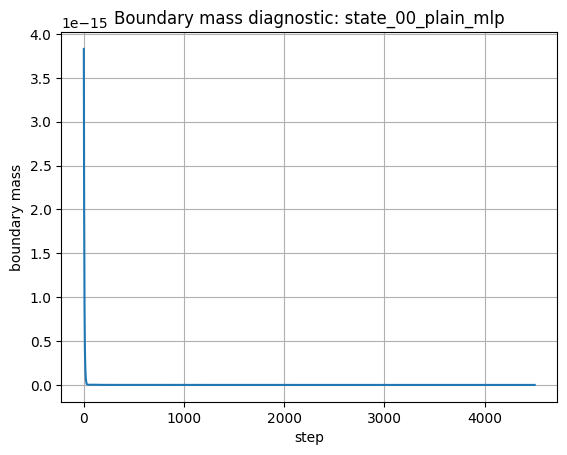

State 0: E=-0.1304233320, boundary_mass=1.73e-21
[state_01_plain_mlp] step=    1/4500 E=0.17466792 loss=71.98090509 bm=2.46e-15 elapsed=0.0s
[state_01_plain_mlp] step=  400/4500 E=0.71861097 loss=0.76424947 bm=3.24e-15 elapsed=2.3s
[state_01_plain_mlp] step=  800/4500 E=0.66461800 loss=0.66750559 bm=4.22e-16 elapsed=4.9s
[state_01_plain_mlp] step= 1200/4500 E=0.66146036 loss=0.66146038 bm=1.01e-17 elapsed=7.0s
[state_01_plain_mlp] step= 1600/4500 E=0.66143590 loss=0.66175092 bm=4.65e-18 elapsed=9.0s
[state_01_plain_mlp] step= 2000/4500 E=0.66151822 loss=0.66171346 bm=4.62e-18 elapsed=11.0s
[state_01_plain_mlp] step= 2400/4500 E=0.66143495 loss=0.66175007 bm=4.52e-18 elapsed=13.1s
[state_01_plain_mlp] step= 2800/4500 E=0.66143127 loss=0.66185182 bm=4.86e-18 elapsed=15.3s
[state_01_plain_mlp] step= 3200/4500 E=0.66143470 loss=0.66146208 bm=5.65e-18 elapsed=18.0s
[state_01_plain_mlp] step= 3600/4500 E=0.66142174 loss=0.66274523 bm=6.24e-18 elapsed=20.0s
[state_01_plain_mlp] step= 4000/450

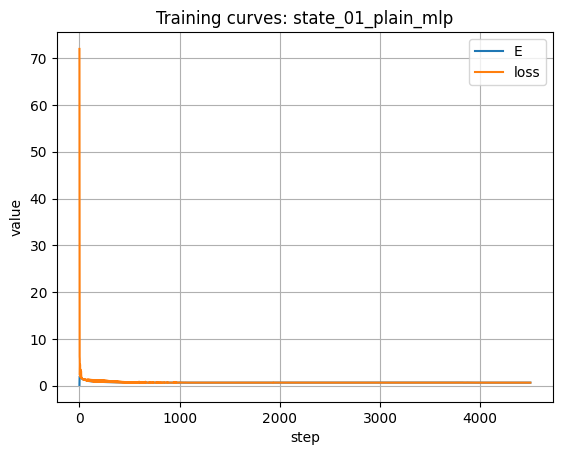

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/state_01_plain_mlp_boundary_mass.png


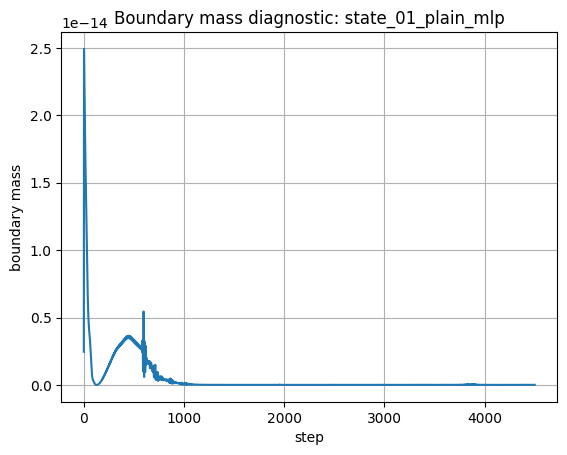

State 1: E=0.6614070749, boundary_mass=8.40e-18
[state_02_plain_mlp] step=    1/4500 E=1.67704322 loss=74.89201500 bm=1.38e-14 elapsed=0.0s
[state_02_plain_mlp] step=  400/4500 E=2.83241501 loss=3.06129871 bm=2.85e-16 elapsed=2.8s
[state_02_plain_mlp] step=  800/4500 E=2.59438761 loss=2.83303906 bm=1.09e-15 elapsed=5.2s
[state_02_plain_mlp] step= 1200/4500 E=2.56052697 loss=2.70288169 bm=1.65e-15 elapsed=7.5s
[state_02_plain_mlp] step= 1600/4500 E=2.55358210 loss=2.65171701 bm=1.43e-15 elapsed=9.7s
[state_02_plain_mlp] step= 2000/4500 E=2.55060062 loss=2.56919628 bm=9.86e-16 elapsed=11.9s
[state_02_plain_mlp] step= 2400/4500 E=2.54741375 loss=2.57125954 bm=6.68e-16 elapsed=14.3s
[state_02_plain_mlp] step= 2800/4500 E=2.54578283 loss=2.56307760 bm=4.60e-16 elapsed=17.0s
[state_02_plain_mlp] step= 3200/4500 E=2.54605913 loss=2.56484359 bm=3.19e-16 elapsed=19.2s
[state_02_plain_mlp] step= 3600/4500 E=2.54550990 loss=2.56469283 bm=2.67e-16 elapsed=21.4s
[state_02_plain_mlp] step= 4000/4500

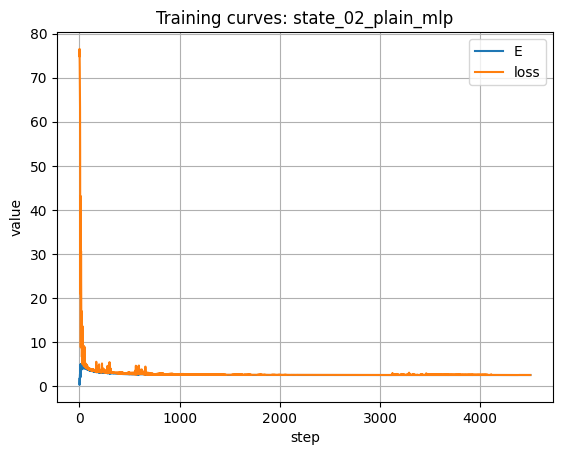

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/state_02_plain_mlp_boundary_mass.png


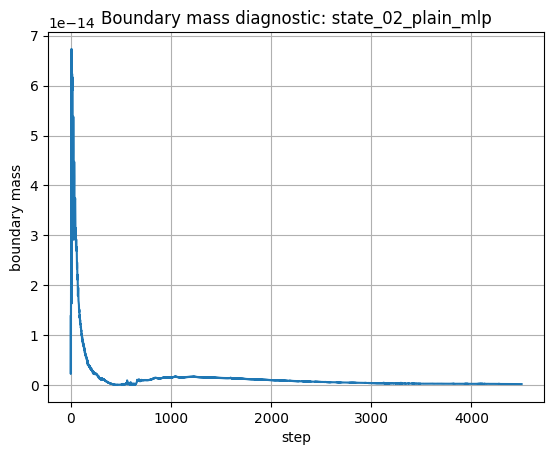

State 2: E=2.5437459958, boundary_mass=5.94e-16
[state_03_plain_mlp] step=    1/4500 E=0.33594048 loss=78.56161578 bm=2.72e-15 elapsed=0.0s
[state_03_plain_mlp] step=  400/4500 E=4.98595374 loss=5.43390269 bm=1.98e-15 elapsed=2.4s
[state_03_plain_mlp] step=  800/4500 E=4.76932935 loss=4.88241179 bm=1.34e-14 elapsed=4.8s
[state_03_plain_mlp] step= 1200/4500 E=4.73441994 loss=4.83327049 bm=1.81e-14 elapsed=7.2s
[state_03_plain_mlp] step= 1600/4500 E=4.69628530 loss=4.76053982 bm=1.01e-14 elapsed=10.0s
[state_03_plain_mlp] step= 2000/4500 E=4.68406929 loss=4.72915748 bm=3.97e-15 elapsed=12.7s
[state_03_plain_mlp] step= 2400/4500 E=4.67799471 loss=4.70189224 bm=1.64e-15 elapsed=15.0s
[state_03_plain_mlp] step= 2800/4500 E=4.67203419 loss=4.74332159 bm=1.71e-16 elapsed=17.4s
[state_03_plain_mlp] step= 3200/4500 E=4.67079834 loss=4.69382996 bm=1.10e-16 elapsed=19.8s
[state_03_plain_mlp] step= 3600/4500 E=4.66789238 loss=4.68426872 bm=1.95e-18 elapsed=22.6s
[state_03_plain_mlp] step= 4000/450

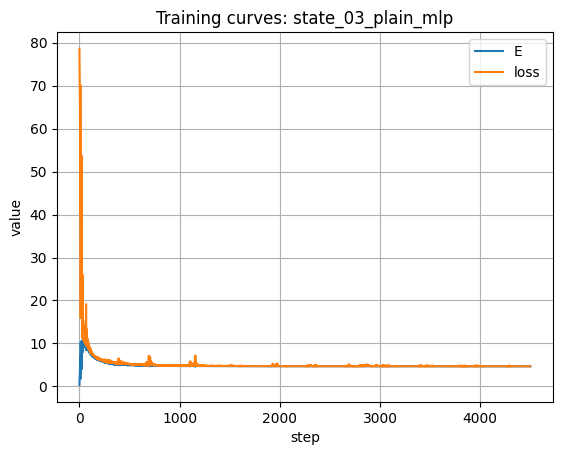

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/state_03_plain_mlp_boundary_mass.png


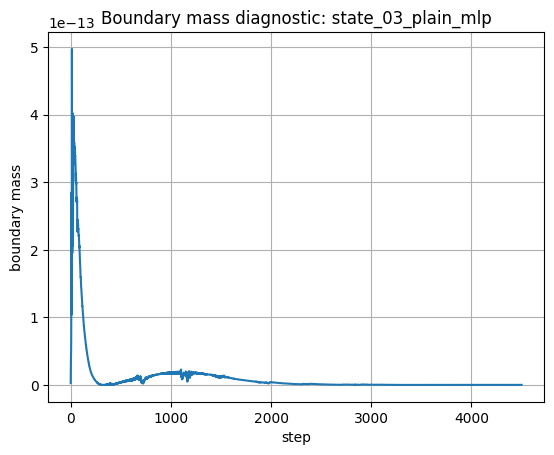

State 3: E=4.6652326805, boundary_mass=1.87e-16
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/nn_wavefunctions_plain_mlp.png


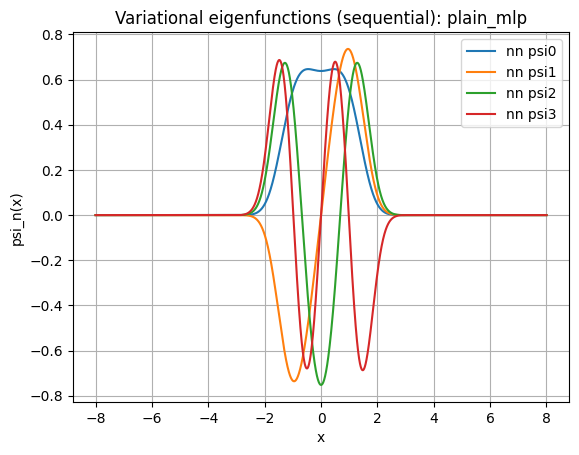

   nn_state  ref_state      E_nn     E_ref     delta  abs_overlap
0         0          0 -0.130423 -0.130420 -0.000003          1.0
1         1          1  0.661407  0.661423 -0.000016          1.0
2         2          2  2.543746  2.543774 -0.000028          1.0
3         3          3  4.665233  4.665338 -0.000105          1.0
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/overlap_matrix_double_well_a2_plain_mlp.png


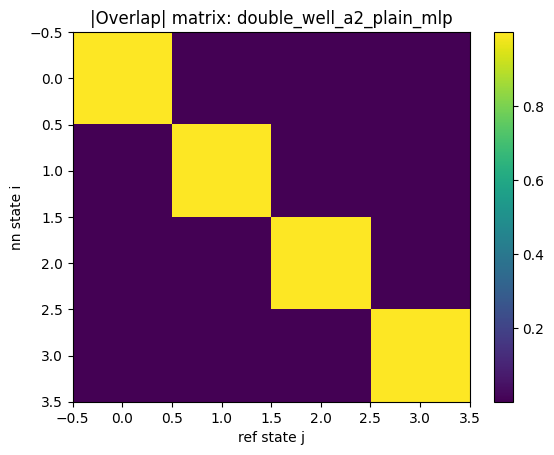

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/spectrum_comparison_double_well_a2_plain_mlp.png


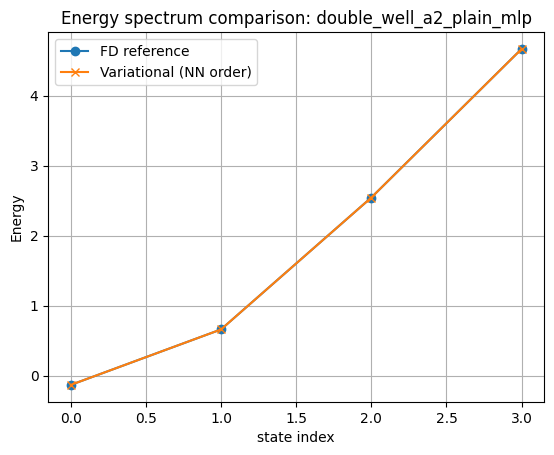

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/match_nn0_ref0_double_well_a2_plain_mlp.png


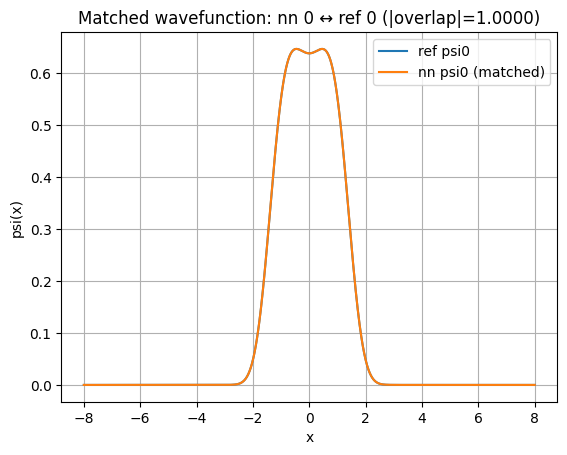

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/match_nn1_ref1_double_well_a2_plain_mlp.png


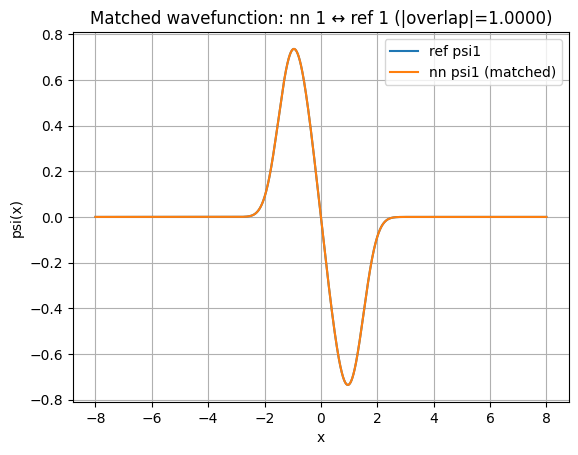

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/match_nn2_ref2_double_well_a2_plain_mlp.png


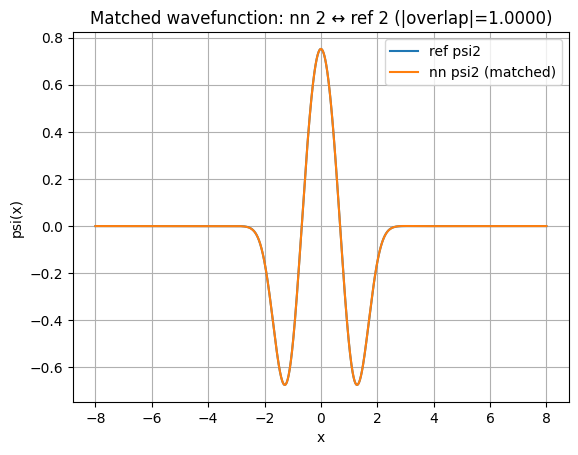

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_double_well_a2_plain_mlp/figures/match_nn3_ref3_double_well_a2_plain_mlp.png


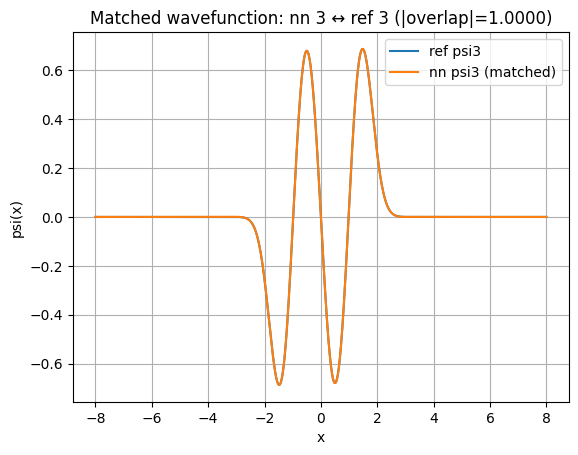

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/potential_quartic_plus_quadratic.png


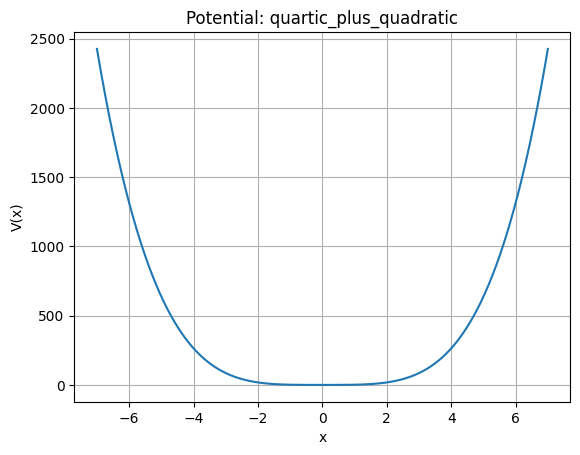

[state_00_plain_mlp] step=    1/4500 E=1.93050185 loss=1.93050185 bm=4.06e-12 elapsed=0.0s
[state_00_plain_mlp] step=  400/4500 E=0.80399972 loss=0.80399972 bm=2.14e-16 elapsed=2.0s
[state_00_plain_mlp] step=  800/4500 E=0.80384468 loss=0.80384468 bm=4.57e-17 elapsed=3.9s
[state_00_plain_mlp] step= 1200/4500 E=0.80379605 loss=0.80379605 bm=1.95e-17 elapsed=5.8s
[state_00_plain_mlp] step= 1600/4500 E=0.80378044 loss=0.80378044 bm=1.14e-17 elapsed=7.7s
[state_00_plain_mlp] step= 2000/4500 E=0.80378404 loss=0.80378404 bm=8.14e-18 elapsed=9.6s
[state_00_plain_mlp] step= 2400/4500 E=0.80377201 loss=0.80377201 bm=5.84e-18 elapsed=11.9s
[state_00_plain_mlp] step= 2800/4500 E=0.80377034 loss=0.80377034 bm=4.58e-18 elapsed=14.2s
[state_00_plain_mlp] step= 3200/4500 E=0.80376907 loss=0.80376907 bm=3.70e-18 elapsed=16.1s
[state_00_plain_mlp] step= 3600/4500 E=0.80376805 loss=0.80376805 bm=3.05e-18 elapsed=17.9s
[state_00_plain_mlp] step= 4000/4500 E=0.80376746 loss=0.80376746 bm=2.56e-18 elapsed=

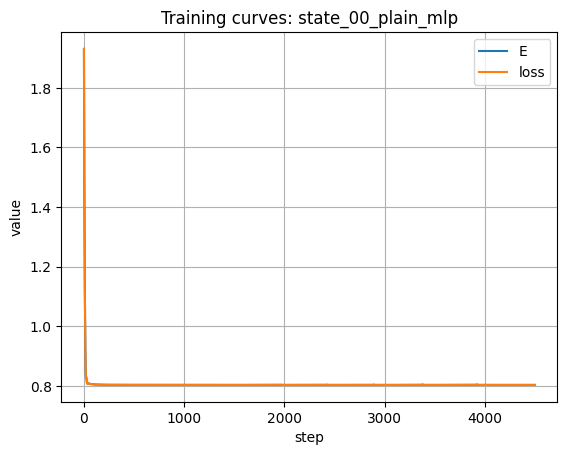

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/state_00_plain_mlp_boundary_mass.png


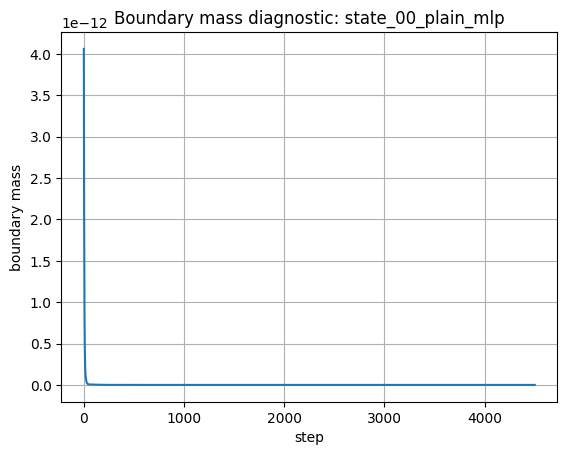

State 0: E=0.8037666151, boundary_mass=1.95e-18
[state_01_plain_mlp] step=    1/4500 E=1.82971575 loss=73.28309065 bm=4.30e-12 elapsed=0.0s
[state_01_plain_mlp] step=  400/4500 E=2.77222448 loss=2.89868654 bm=1.34e-12 elapsed=2.7s
[state_01_plain_mlp] step=  800/4500 E=2.74088492 loss=2.74501965 bm=1.68e-13 elapsed=5.0s
[state_01_plain_mlp] step= 1200/4500 E=2.74022242 loss=2.74498168 bm=2.25e-14 elapsed=7.0s
[state_01_plain_mlp] step= 1600/4500 E=2.74059755 loss=2.74710499 bm=8.25e-15 elapsed=9.1s
[state_01_plain_mlp] step= 2000/4500 E=2.73792579 loss=2.73955455 bm=2.13e-15 elapsed=11.1s
[state_01_plain_mlp] step= 2400/4500 E=2.73790801 loss=2.73794743 bm=4.39e-15 elapsed=13.2s
[state_01_plain_mlp] step= 2800/4500 E=2.73786582 loss=2.73786582 bm=6.10e-15 elapsed=15.8s
[state_01_plain_mlp] step= 3200/4500 E=2.73786569 loss=2.73788414 bm=5.02e-15 elapsed=18.0s
[state_01_plain_mlp] step= 3600/4500 E=2.73786538 loss=2.73791007 bm=4.44e-15 elapsed=20.1s
[state_01_plain_mlp] step= 4000/4500

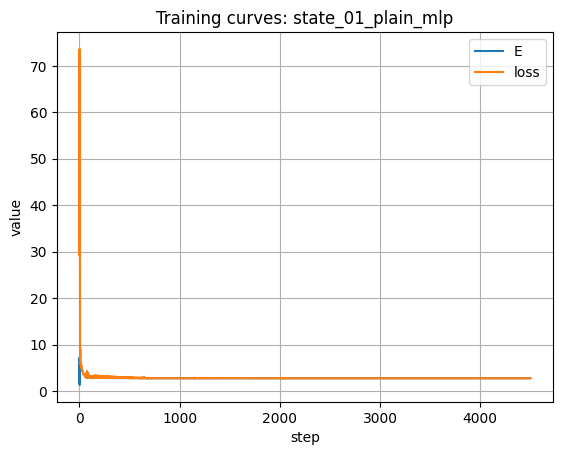

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/state_01_plain_mlp_boundary_mass.png


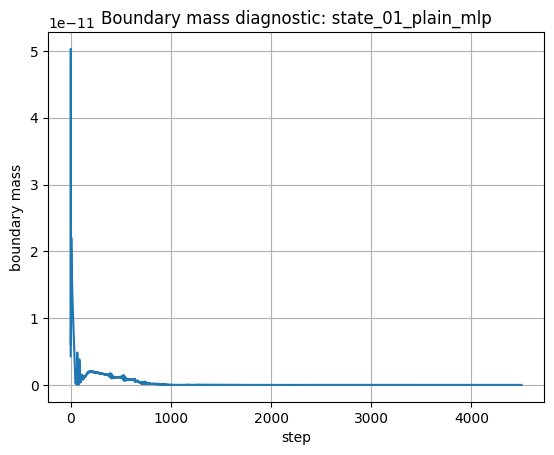

State 1: E=2.7378569145, boundary_mass=6.73e-16
[state_02_plain_mlp] step=    1/4500 E=1.11896319 loss=78.92685775 bm=9.40e-13 elapsed=0.0s
[state_02_plain_mlp] step=  400/4500 E=5.29227094 loss=5.57531857 bm=9.45e-13 elapsed=2.9s
[state_02_plain_mlp] step=  800/4500 E=5.25467289 loss=5.29672651 bm=1.10e-12 elapsed=5.2s
[state_02_plain_mlp] step= 1200/4500 E=5.20698735 loss=5.27064254 bm=7.78e-13 elapsed=7.4s
[state_02_plain_mlp] step= 1600/4500 E=5.17710124 loss=5.51445631 bm=5.61e-13 elapsed=9.7s
[state_02_plain_mlp] step= 2000/4500 E=5.18226998 loss=5.20596296 bm=9.88e-14 elapsed=11.9s
[state_02_plain_mlp] step= 2400/4500 E=5.18046462 loss=5.20351744 bm=1.83e-14 elapsed=14.3s
[state_02_plain_mlp] step= 2800/4500 E=5.18105446 loss=5.18503709 bm=5.05e-15 elapsed=17.1s
[state_02_plain_mlp] step= 3200/4500 E=5.18037965 loss=5.18470124 bm=5.61e-15 elapsed=19.3s
[state_02_plain_mlp] step= 3600/4500 E=5.17954830 loss=5.19481685 bm=1.17e-14 elapsed=21.5s
[state_02_plain_mlp] step= 4000/4500

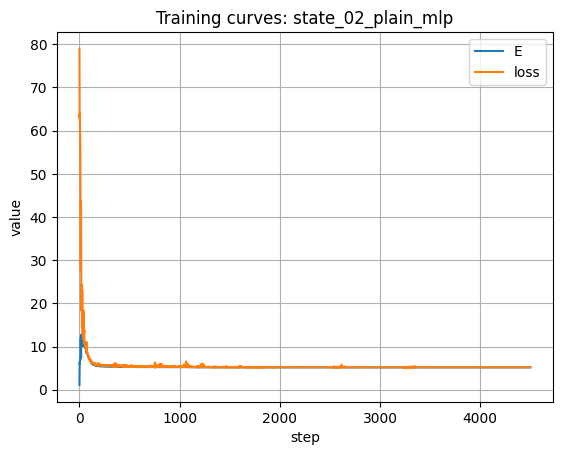

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/state_02_plain_mlp_boundary_mass.png


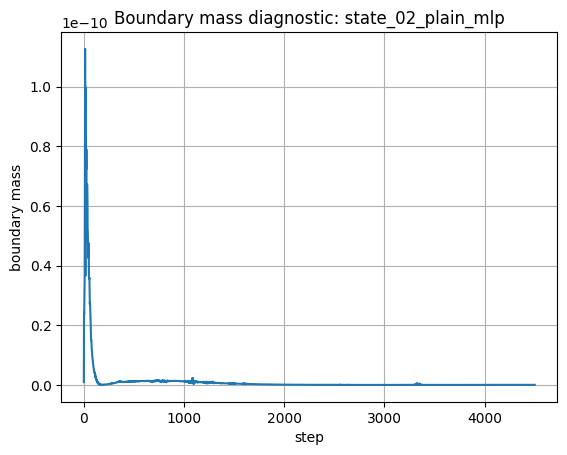

State 2: E=5.1792210269, boundary_mass=1.36e-13
[state_03_plain_mlp] step=    1/4500 E=3.24491943 loss=74.39792133 bm=7.62e-12 elapsed=0.0s
[state_03_plain_mlp] step=  400/4500 E=8.08935096 loss=8.57650647 bm=1.13e-12 elapsed=2.4s
[state_03_plain_mlp] step=  800/4500 E=7.98146159 loss=8.30851122 bm=2.43e-12 elapsed=4.8s
[state_03_plain_mlp] step= 1200/4500 E=8.00608875 loss=8.00925991 bm=1.22e-12 elapsed=7.2s
[state_03_plain_mlp] step= 1600/4500 E=7.94527147 loss=8.04892355 bm=1.03e-12 elapsed=10.2s
[state_03_plain_mlp] step= 2000/4500 E=7.94395451 loss=7.99044740 bm=5.69e-13 elapsed=12.8s
[state_03_plain_mlp] step= 2400/4500 E=7.94164117 loss=8.03317014 bm=2.78e-13 elapsed=15.2s
[state_03_plain_mlp] step= 2800/4500 E=7.94257920 loss=7.97100057 bm=2.47e-13 elapsed=17.7s
[state_03_plain_mlp] step= 3200/4500 E=7.93801409 loss=8.03265783 bm=1.74e-13 elapsed=20.1s
[state_03_plain_mlp] step= 3600/4500 E=7.94199084 loss=7.96532741 bm=2.10e-13 elapsed=23.0s
[state_03_plain_mlp] step= 4000/450

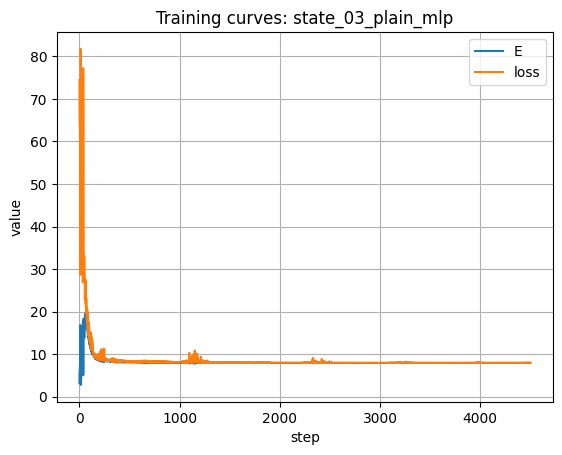

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/state_03_plain_mlp_boundary_mass.png


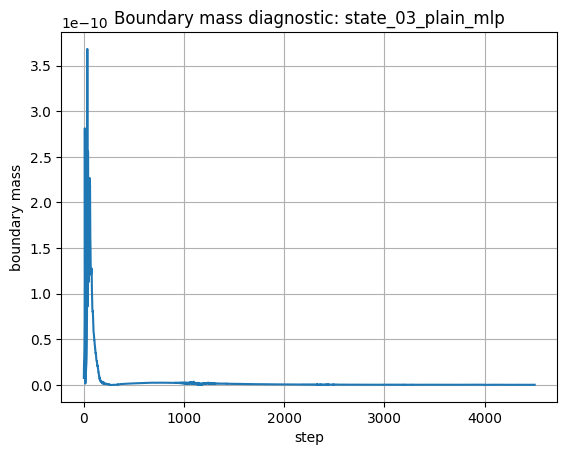

State 3: E=7.9421920981, boundary_mass=1.01e-15
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/nn_wavefunctions_plain_mlp.png


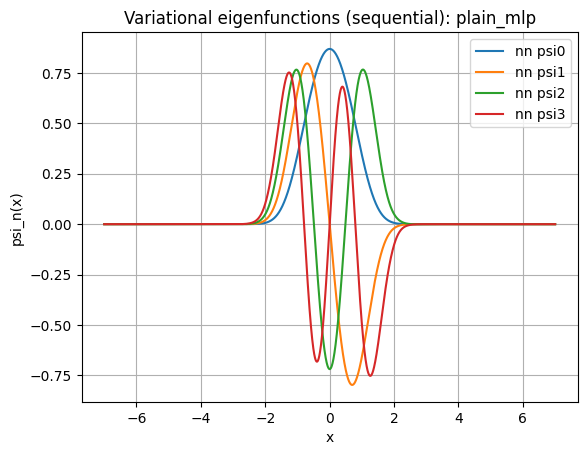

   nn_state  ref_state      E_nn     E_ref     delta  abs_overlap
0         0          0  0.803767  0.803769 -0.000003          1.0
1         1          1  2.737857  2.737883 -0.000026          1.0
2         2          2  5.179221  5.179262 -0.000041          1.0
3         3          3  7.942192  7.942335 -0.000143          1.0
Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/overlap_matrix_quartic_plus_quadratic_plain_mlp.png


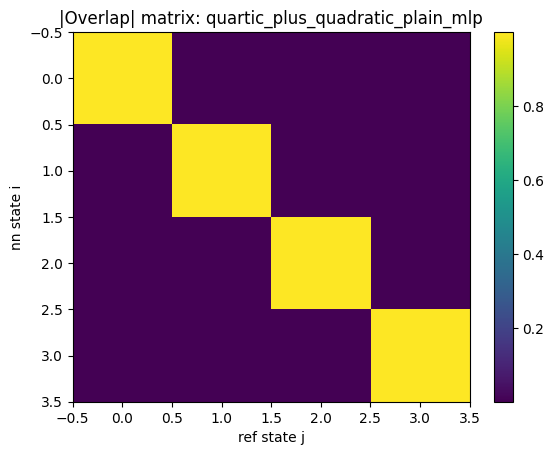

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/spectrum_comparison_quartic_plus_quadratic_plain_mlp.png


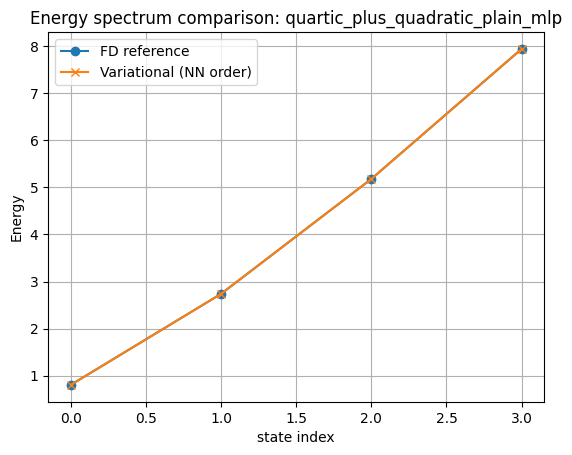

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/match_nn0_ref0_quartic_plus_quadratic_plain_mlp.png


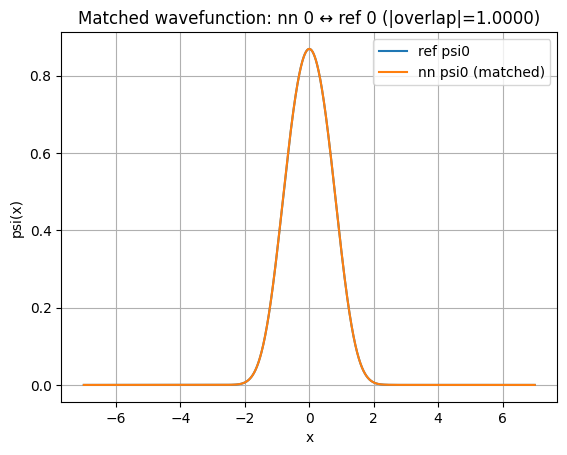

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/match_nn1_ref1_quartic_plus_quadratic_plain_mlp.png


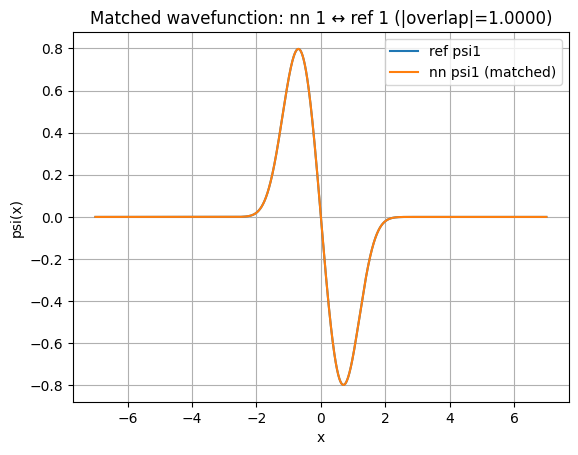

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/match_nn2_ref2_quartic_plus_quadratic_plain_mlp.png


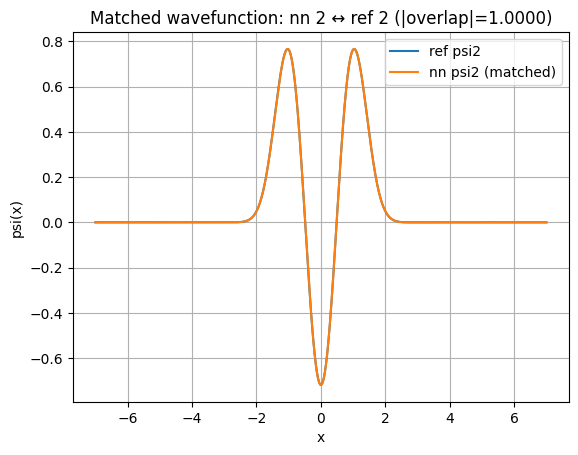

Saved figure: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_quartic_plus_quadratic_plain_mlp/figures/match_nn3_ref3_quartic_plus_quadratic_plain_mlp.png


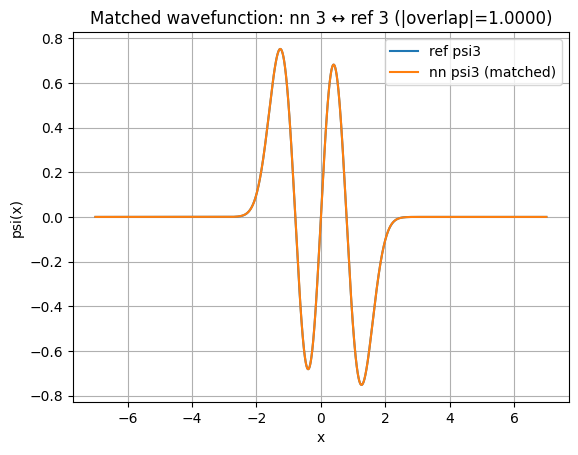

Saved: 1 - RESEARCH/PSITest/runs/20251215_002508/extensions/benchmark_summary.csv


,potential,model,E0_ref,E0_nn,delta0,overlap0
0,quartic_tilted,plain_mlp,-1.547381,-1.547394,-1.368235e-05,1.0
1,harmonic,plain_mlp,0.500000,0.499999,-7.571259e-07,1.0
2,double_well_a2,plain_mlp,-0.130420,-0.130423,-3.060307e-06,1.0
3,quartic_plus_quadratic,plain_mlp,0.803769,0.803767,-2.697753e-06,1.0


In [49]:
# ============================================
# Stage 16 — Multi-potential benchmark
# ============================================
# Purpose:
# - Run a consistent experiment template across different V(x)
# - Save per-potential results and a combined summary table
# - Produces plots comparing spectra across potentials
#
# Relation:
# - "Try different potentials" + "compare to eigensolver" in one harness. :contentReference[oaicite:16]{index=16}

def benchmark_potentials(
    pot_names: List[str],
    model_spec: ModelSpec,
    K_states: int = 4,
    steps: int = 5000,
):
    rows = []
    for pname in pot_names:
        pot = POTENTIALS[pname]
        out = exp_dir(f"benchmark_{pname}_{model_spec.name}")

        L = pot.recommended_L
        N = 4096
        x_np, x, dx = make_grid(L, N, device=device, dtype=torch.get_default_dtype())
        V_np = pot.fn_numpy(x_np)
        Vx = pot.fn_torch(x)

        plot_potential(x_np, V_np, out, pname)

        # Reference
        evals_ref, psis_ref = fd_eigensolve_k(x_np, V_np, dx, k=max(6, K_states))
        np.savez(out / "data" / "reference_fd_k.npz", x=x_np, V=V_np, evals=evals_ref, psis=psis_ref)

        # Variational states
        cfg = TrainConfig(steps=steps, lr=2e-3, lam_ortho=80.0, print_every=400, ckpt_every=2500, use_lbfgs=True)
        states = find_states_sequential(
            x_np=x_np, x=x, dx=dx, V_np=V_np, Vx=Vx,
            out_dir=out,
            model_spec=model_spec,
            K=K_states,
            train_cfg=cfg,
            model_kwargs={"hidden": 64, "depth": 3, "act": "tanh", "a": 0.35},
        )

        # Compare
        df_cmp, O = compare_to_reference(
            x_np=x_np, dx=dx,
            evals_ref=evals_ref, psis_ref=psis_ref,
            states=states,
            out_dir=out,
            tag=f"{pname}_{model_spec.name}",
        )

        # Summary row (ground state)
        # Take best-matched row where ref_state==0
        g = df_cmp[df_cmp["ref_state"] == 0].iloc[0]
        rows.append({
            "potential": pname,
            "model": model_spec.name,
            "E0_ref": float(g["E_ref"]),
            "E0_nn": float(g["E_nn"]),
            "delta0": float(g["delta"]),
            "overlap0": float(g["abs_overlap"]),
        })

    df_sum = pd.DataFrame(rows)
    df_sum.to_csv(EXT_DIR / "benchmark_summary.csv", index=False)
    print("Saved:", EXT_DIR / "benchmark_summary.csv")
    return df_sum

# Example:
df_bench = benchmark_potentials(
    pot_names=["quartic_tilted", "harmonic", "double_well_a2", "quartic_plus_quadratic"],
    model_spec=MODEL_SPECS["plain_mlp"],
    K_states=4,
    steps=4500,
)
df_bench
